In [4]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import Bio.PDB as pdb
from Bio.PDB import calc_angle, calc_dihedral
import lightgbm as lgbm
from keras.layers import Input, Dense, Flatten, Reshape
from keras.models import Model
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import json
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [ ]:
from keras import layers
from keras import activations
from keras.models import load_model
import matplotlib.pyplot as plt

import seaborn as sns

In [ ]:
import keras, keras.layers as L, keras.backend as K
from keras.utils import to_categorical
from keras.layers import Conv2D, BatchNormalization, Dropout, LeakyReLU, Dense, Conv1D, Activation, MaxPooling2D, MaxPooling1D
from keras.models import Sequential

### 1. Функции для подсчета доверительного интервала, присвоения класса угла, построения модели CNN, получения скрытого вектора AutoEncoder, построения модели полносвязной нейросети.

In [5]:
def find_confidence_interval(data, confidence=0.95):
    n = data.shape[0]
    m = np.mean(data)
    std_err = np.std(data)
    h = (1 + confidence) * std_err

    return [m - h, m + h]

In [8]:
def getChiClass(amino, chi_x, angle, bounds):
    b = [-180] + bounds[amino][chi_x - 1]
    for i in range(len(b) - 1):
        if angle > b[i] and angle < b[i + 1]:
            return i
    return 0

In [9]:
def make_model_2d(a, b, num_classes):
    model = Sequential()
    num_layers = 4
    num_filters = 2
    
    for n in range(num_layers):
        if n == 0:
            model.add(Conv2D(filters= num_filters ,kernel_size=(4,4), input_shape=(a, b, 1), strides= (1, 1), padding='same'))
        else:
            model.add(Conv2D(filters= num_filters ,kernel_size=(4, 4), strides= (1, 1), padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        num_filters *= 2

    model.add(Flatten())    
    model.add(Dense(num_classes))
    model.add(Activation("softmax"))
    return model

In [10]:
def make_model_coder(shape, code_size):    
    encoder = Sequential()
    encoder.add(L.InputLayer(shape))
    encoder.add(L.Dense(code_size))

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(shape))) # np.prod for 2d
    
    return encoder,decoder

In [11]:
def make_full_connected(a, num_classes):
    model = Sequential()
    model.add(Dense(128, input_shape=(a,)))
    model.add(layers.Activation(activations.relu))
    model.add(Dense(128, input_shape=(a,)))
    model.add(layers.Activation(activations.relu))
    model.add(Dense(128, input_shape=(a,)))
    model.add(layers.Activation(activations.relu))
    model.add(Dense(128, input_shape=(a,)))
    model.add(layers.Activation(activations.relu))
    model.add(Dense(num_classes))
    model.add(Activation("softmax"))
    return model

### 2. Обучение моделей для каждого угла всех аминокислот.

In [1]:
amino_arr = ['ARG', 'LYS', 'GLN', 'MET', 'HIS', 'ILE','LEU', 'ASP', 'ASN', 'PHE', 'PRO', 'TRP', 'TYR', 'CYS', 'SER', 'THR', 'VAL']

In [8]:
for amino in amino_arr:
    train_data = pd.read_csv(amino + '_train_data.csv')
    train_data = train_data.drop(columns=["Unnamed: 0", "pbd_indx"])
    test_data = pd.read_csv(amino + '_test_data.csv')
    test_data = test_data.drop(columns=["Unnamed: 0", "pbd_indx"])
    
    path = 'chi_bounds.json'
    with open(path, 'r') as f:
        bounds = json.loads(f.read())

    count = 0
    cols = train_data.columns.tolist()
    
    for i in range(len(cols)):
        words = cols[i].split('_')
        if ('chi' in words):
            count += 1
    
    for ind in range(count):
        train_data['chi_class_'+str(ind+1)] = train_data['chi_'+str(ind+1)].apply(lambda x:getChiClass(amino, ind+1, x, bounds))
        test_data['chi_class_'+str(ind+1)] = test_data['chi_'+str(ind+1)].apply(lambda x:getChiClass(amino, ind+1, x, bounds))
    
    chi_columns = ["chi_1", "chi_2", "chi_3", "chi_4", "chi_5"]
    chi_col_list = ['chi_class_1', 'chi_class_2', 'chi_class_3', 'chi_class_4', 'chi_class_5']
    
    train_data = train_data.drop(columns=chi_columns[:count])
    test_data = test_data.drop(columns=chi_columns[:count])
    
    y_train_list = []
    y_test_list = []
    for i in range(count):
        y_train_list.append(train_data[chi_col_list[i]])
        y_train_list[i] = np.array(y_train_list[i].values.tolist())
        y_test_list.append(test_data[chi_col_list[i]])
        y_test_list[i] = np.array(y_test_list[i].values.tolist())
        
    train_data = train_data.drop(columns=chi_col_list[:count])
    test_data = test_data.drop(columns=chi_col_list[:count])
    
    categorical = list()
    numeric = list()
    column_array = list(train_data.columns)
    for col in column_array:
        if type(train_data[col][0]) == str:
            categorical.append(col)
        else:
            numeric.append(col)
    
    categorical_train = train_data[categorical]
    one_hot_encoder = OneHotEncoder()
    X_train_new = one_hot_encoder.fit_transform(categorical_train)
    X_train_new = X_train_new.toarray()

    categorical_test = test_data[categorical]
    one_hot_encoder = OneHotEncoder()
    X_test_new = one_hot_encoder.fit_transform(categorical_test)
    X_test_new = X_test_new.toarray()

    X_train_new_main = train_data.drop(columns=categorical)
    X_test_new_main = test_data.drop(columns=categorical)

    X_train_new_main = np.hstack((X_train_new_main.values, X_train_new))
    X_test_new_main = np.hstack((X_test_new_main.values, X_test_new))
    
    cols = ['True', 'LightGBM', 'CNN', 'AutoEncoder']
    result_table = pd.DataFrame(columns=cols)
    
    if (count >= 1):
        y_train = y_train_list[0]
        y_test = y_test_list[0]
        
        num_classes = np.unique(y_train).size
        
        result_table['True'] = y_test
        
        clf = lgbm.LGBMClassifier(n_estimators=2170, num_leaves = 88, max_depth = 16, min_child_samples = 1358, reg_alpha = 28.532, learning_rate = 0.26461, random_state = 42)
        clf.fit(X_train_new_main, y_train)
        predict = clf.predict(X_test_new_main)
        clf.booster_.save_model(amino + '_lgbm_1.txt')
        
        result_table['LightGBM'] = predict
        
        X_train_conv = np.append(X_train_new_main, np.zeros(X_train_new_main.shape[0]).reshape(X_train_new_main.shape[0], 1), axis = 1)
        X_train_conv = X_train_conv.reshape((-1, 31, 36))
        X_test_conv = np.append(X_test_new_main, np.zeros(X_test_new_main.shape[0]).reshape(X_test_new_main.shape[0], 1), axis = 1)
        X_test_conv = X_test_conv.reshape((-1, 31, 36))
        
        model = make_model_2d(X_train_conv.shape[1], X_train_conv.shape[2], num_classes)
        model.compile(loss='categorical_crossentropy', optimizer='adam')
        data = X_train_conv.reshape(X_train_conv.shape[0], X_train_conv.shape[1], X_train_conv.shape[2], 1)
        test = X_test_conv.reshape(X_test_conv.shape[0], X_test_conv.shape[1], X_test_conv.shape[2], 1)
        target = to_categorical(y_train, num_classes)
        model.fit(data, target, nb_epoch=5, verbose = 2, batch_size = 64)
        prediction = model.predict_classes(test)
        model.save(amino + '_cnn_1.h5')
        
        result_table['CNN'] = prediction
        
        shape = (X_train_new_main.shape[1], )
        code_size = 128
        encoder, decoder = make_model_coder(shape, code_size)
        encoded = encoder.predict(X_test_new_main)
        encoded_1 = encoder.predict(X_train_new_main)
        full_model = make_full_connected(encoded_1.shape[1], num_classes)
        full_model.compile(loss='categorical_crossentropy', optimizer='adam')
        target = to_categorical(y_train, num_classes)
        full_model.fit(encoded_1, target, nb_epoch=10, verbose = 2, batch_size = 128)
        prediction_1 = full_model.predict_classes(encoded)
        model.save(amino + '_coder_1.h5')
        
        result_table['AutoEncoder'] = prediction_1
        
        result_table.to_csv(amino + '_chi_1.csv')
        
    if (count >= 2):
        y_train = y_train_list[1]
        y_test = y_test_list[1]
        
        num_classes = np.unique(y_train).size
        
        result_table['True'] = y_test
        
        X_train_new_main = np.append(X_train_new_main, y_train_list[0].reshape(y_train_list[0].shape[0], 1), axis = 1)
        X_test_new_main = np.append(X_test_new_main, y_test_list[0].reshape(y_test_list[0].shape[0], 1), axis = 1)
        
        clf = lgbm.LGBMClassifier(n_estimators=2170, num_leaves = 88, max_depth = 16, min_child_samples = 1358, reg_alpha = 28.532, learning_rate = 0.26461, random_state = 42)
        clf.fit(X_train_new_main, y_train)
        predict = clf.predict(X_test_new_main)
        clf.booster_.save_model(amino + '_lgbm_2.txt')
        
        result_table['LightGBM'] = predict
        
        X_train_conv = X_train_new_main.reshape((-1, 31, 36))
        X_test_conv = X_test_new_main.reshape((-1, 31, 36))

        model = make_model_2d(X_train_conv.shape[1], X_train_conv.shape[2], num_classes)
        model.compile(loss='categorical_crossentropy', optimizer='adam')

        data = X_train_conv.reshape(X_train_conv.shape[0], X_train_conv.shape[1], X_train_conv.shape[2], 1)
        test = X_test_conv.reshape(X_test_conv.shape[0], X_test_conv.shape[1], X_test_conv.shape[2], 1)
        target = to_categorical(y_train, num_classes)
        
        model.fit(data, target, nb_epoch=5, verbose = 2, batch_size = 64)
        prediction = model.predict_classes(test)
        model.save(amino + '_cnn_2.h5')
        
        result_table['CNN'] = prediction
        
        shape = (X_train_new_main.shape[1], )
        code_size = 128
        encoder, decoder = make_model_coder(shape, code_size)
        encoded = encoder.predict(X_test_new_main)
        encoded_1 = encoder.predict(X_train_new_main)
        full_model = make_full_connected(encoded_1.shape[1], num_classes)
        full_model.compile(loss='categorical_crossentropy', optimizer='adam')
        target = to_categorical(y_train, num_classes)
        full_model.fit(encoded_1, target, nb_epoch=10, verbose = 2, batch_size = 128)
        prediction_1 = full_model.predict_classes(encoded)
        model.save(amino + '_coder_2.h5')
        
        result_table['AutoEncoder'] = prediction_1
        
        result_table.to_csv(amino + '_chi_2.csv')
        
    if (count >= 3):
        y_train = y_train_list[2]
        y_test = y_test_list[2]
        
        num_classes = np.unique(y_train).size
        
        result_table['True'] = y_test
        
        X_train_new_main = np.append(X_train_new_main, y_train_list[1].reshape(y_train_list[1].shape[0], 1), axis = 1)
        X_test_new_main = np.append(X_test_new_main, y_test_list[1].reshape(y_test_list[1].shape[0], 1), axis = 1)
        
        clf = lgbm.LGBMClassifier(n_estimators=2170, num_leaves = 88, max_depth = 16, min_child_samples = 1358, reg_alpha = 28.532, learning_rate = 0.26461, random_state = 42)
        clf.fit(X_train_new_main, y_train)
        predict = clf.predict(X_test_new_main)
        clf.booster_.save_model(amino + '_lgbm_3.txt')
        
        result_table['LightGBM'] = predict
        
        X_train_conv = np.append(X_train_new_main, np.zeros(X_train_new_main.shape[0]).reshape(X_train_new_main.shape[0], 1), axis = 1)
        X_train_conv = X_train_conv.reshape((-1, 26, 43))
        X_test_conv = np.append(X_test_new_main, np.zeros(X_test_new_main.shape[0]).reshape(X_test_new_main.shape[0], 1), axis = 1)
        X_test_conv = X_test_conv.reshape((-1, 26, 43))

        model = make_model_2d(X_train_conv.shape[1], X_train_conv.shape[2], num_classes)
        model.compile(loss='categorical_crossentropy', optimizer='adam')

        data = X_train_conv.reshape(X_train_conv.shape[0], X_train_conv.shape[1], X_train_conv.shape[2], 1)
        test = X_test_conv.reshape(X_test_conv.shape[0], X_test_conv.shape[1], X_test_conv.shape[2], 1)
        target = to_categorical(y_train, num_classes)
        
        model.fit(data, target, nb_epoch=5, verbose = 2, batch_size = 64)
        prediction = model.predict_classes(test)
        model.save(amino + '_cnn_3.h5')
        
        result_table['CNN'] = prediction
        
        shape = (X_train_new_main.shape[1], )
        code_size = 128
        encoder, decoder = make_model_coder(shape, code_size)
        encoded = encoder.predict(X_test_new_main)
        encoded_1 = encoder.predict(X_train_new_main)
        full_model = make_full_connected(encoded_1.shape[1], num_classes)
        full_model.compile(loss='categorical_crossentropy', optimizer='adam')
        target = to_categorical(y_train, num_classes)
        full_model.fit(encoded_1, target, nb_epoch=10, verbose = 2, batch_size = 128)
        prediction_1 = full_model.predict_classes(encoded)
        model.save(amino + '_coder_3.h5')
        
        result_table['AutoEncoder'] = prediction_1
        
        result_table.to_csv(amino + '_chi_3.csv')
        
    if (count >= 4):
        y_train = y_train_list[3]
        y_test = y_test_list[3]
        
        num_classes = np.unique(y_train).size

        result_table['True'] = y_test

        X_train_new_main = np.append(X_train_new_main, y_train_list[2].reshape(y_train_list[2].shape[0], 1), axis = 1)
        X_test_new_main = np.append(X_test_new_main, y_test_list[2].reshape(y_test_list[2].shape[0], 1), axis = 1)

        clf = lgbm.LGBMClassifier(n_estimators=2170, num_leaves = 88, max_depth = 16, min_child_samples = 1358, reg_alpha = 28.532, learning_rate = 0.26461, random_state = 42)
        clf.fit(X_train_new_main, y_train)
        predict = clf.predict(X_test_new_main)
        clf.booster_.save_model(amino + '_lgbm_4.txt')

        result_table['LightGBM'] = predict

        X_train_conv = X_train_new_main.reshape((-1, 26, 43))
        X_test_conv = X_test_new_main.reshape((-1, 26, 43))

        model = make_model_2d(X_train_conv.shape[1], X_train_conv.shape[2], num_classes)
        model.compile(loss='categorical_crossentropy', optimizer='adam')

        data = X_train_conv.reshape(X_train_conv.shape[0], X_train_conv.shape[1], X_train_conv.shape[2], 1)
        test = X_test_conv.reshape(X_test_conv.shape[0], X_test_conv.shape[1], X_test_conv.shape[2], 1)
        target = to_categorical(y_train, num_classes)

        model.fit(data, target, nb_epoch=5, verbose = 2, batch_size = 64)
        prediction = model.predict_classes(test)
        model.save(amino + '_cnn_4.h5')

        result_table['CNN'] = prediction

        shape = (X_train_new_main.shape[1], )
        code_size = 128
        encoder, decoder = make_model_coder(shape, code_size)
        encoded = encoder.predict(X_test_new_main)
        encoded_1 = encoder.predict(X_train_new_main)
        full_model = make_full_connected(encoded_1.shape[1], num_classes)
        full_model.compile(loss='categorical_crossentropy', optimizer='adam')
        target = to_categorical(y_train, num_classes)
        full_model.fit(encoded_1, target, nb_epoch=10, verbose = 2, batch_size = 128)
        prediction_1 = full_model.predict_classes(encoded)
        model.save(amino + '_coder_4.h5')

        result_table['AutoEncoder'] = prediction_1

        result_table.to_csv(amino + '_chi_4.csv')
        
    if (count >= 5):
        y_train = y_train_list[4]
        y_test = y_test_list[4]
        
        num_classes = np.unique(y_train).size
        
        result_table['True'] = y_test
        
        X_train_new_main = np.append(X_train_new_main, y_train_list[3].reshape(y_train_list[3].shape[0], 1), axis = 1)
        X_test_new_main = np.append(X_test_new_main, y_test_list[3].reshape(y_test_list[3].shape[0], 1), axis = 1)
        
        clf = lgbm.LGBMClassifier(n_estimators=2170, num_leaves = 88, max_depth = 16, min_child_samples = 1358, reg_alpha = 28.532, learning_rate = 0.26461, random_state = 42)
        clf.fit(X_train_new_main, y_train)
        predict = clf.predict(X_test_new_main)
        clf.booster_.save_model(amino + '_lgbm_5.txt')
        
        result_table['LightGBM'] = predict
        
        X_train_conv = np.append(X_train_new_main, np.zeros(X_train_new_main.shape[0]).reshape(X_train_new_main.shape[0], 1), axis = 1)
        X_train_conv = X_train_conv.reshape((-1, 32, 35))
        X_test_conv = np.append(X_test_new_main, np.zeros(X_test_new_main.shape[0]).reshape(X_test_new_main.shape[0], 1), axis = 1)
        X_test_conv = X_test_conv.reshape((-1, 32, 35))

        model = make_model_2d(X_train_conv.shape[1], X_train_conv.shape[2], num_classes)
        model.compile(loss='categorical_crossentropy', optimizer='adam')

        data = X_train_conv.reshape(X_train_conv.shape[0], X_train_conv.shape[1], X_train_conv.shape[2], 1)
        test = X_test_conv.reshape(X_test_conv.shape[0], X_test_conv.shape[1], X_test_conv.shape[2], 1)
        target = to_categorical(y_train, num_classes)
        
        model.fit(data, target, nb_epoch=5, verbose = 2, batch_size = 64)
        prediction = model.predict_classes(test)
        model.save(amino + '_cnn_5.h5')
        
        result_table['CNN'] = prediction
        
        shape = (X_train_new_main.shape[1], )
        code_size = 128
        encoder, decoder = make_model_coder(shape, code_size)
        encoded = encoder.predict(X_test_new_main)
        encoded_1 = encoder.predict(X_train_new_main)
        full_model = make_full_connected(encoded_1.shape[1], num_classes)
        full_model.compile(loss='categorical_crossentropy', optimizer='adam')
        target = to_categorical(y_train, num_classes)
        full_model.fit(encoded_1, target, nb_epoch=10, verbose = 2, batch_size = 128)
        prediction_1 = full_model.predict_classes(encoded)
        model.save(amino + '_coder_5.h5')
        
        result_table['AutoEncoder'] = prediction_1
        
        result_table.to_csv(amino + '_chi_5.csv')

Epoch 1/5
 - 129s - loss: 0.7352
Epoch 2/5
 - 123s - loss: 0.6270
Epoch 3/5
 - 128s - loss: 0.6107
Epoch 4/5
 - 123s - loss: 0.5845
Epoch 5/5
 - 122s - loss: 0.5710
Epoch 1/10
 - 3s - loss: 2.4902
Epoch 2/10
 - 2s - loss: 0.8962
Epoch 3/10
 - 2s - loss: 0.7720
Epoch 4/10
 - 2s - loss: 0.7262
Epoch 5/10
 - 2s - loss: 0.6950
Epoch 6/10
 - 2s - loss: 0.6758
Epoch 7/10
 - 2s - loss: 0.6608
Epoch 8/10
 - 2s - loss: 0.6505
Epoch 9/10
 - 2s - loss: 0.6369
Epoch 10/10
 - 2s - loss: 0.6337
Epoch 1/5
 - 126s - loss: 0.7914
Epoch 2/5
 - 121s - loss: 0.7427
Epoch 3/5
 - 125s - loss: 0.7240
Epoch 4/5
 - 126s - loss: 0.7008
Epoch 5/5
 - 129s - loss: 0.6988
Epoch 1/10
 - 3s - loss: 2.6793
Epoch 2/10
 - 2s - loss: 0.9706
Epoch 3/10
 - 2s - loss: 0.8379
Epoch 4/10
 - 2s - loss: 0.7987
Epoch 5/10
 - 2s - loss: 0.7702
Epoch 6/10
 - 2s - loss: 0.7512
Epoch 7/10
 - 2s - loss: 0.7445
Epoch 8/10
 - 2s - loss: 0.7291
Epoch 9/10
 - 2s - loss: 0.7240
Epoch 10/10
 - 2s - loss: 0.7155
Epoch 1/5
 - 183s - loss: 0.

### 3. Сбор статистик для каждой аминокислоты, каждого угла:

#### 3.1. Статистика для каждого метода отдельно. Какая доля ошибок у каждого метода? Какой метод предсказывает правильно чаще всех, какой реже всех?
#### 3.2. Какая доля согласованных предсказаний (все методы вернули одно и то же)? Посмотреть, какая доля правильных / ошибочных предсказаний среди этих.
#### 3.3. Выбрать из п.1 лучший метод. Посмотреть, в какой доле примеров другие методы (отдельно каждый другой метод или оба других) согласны с ним.



In [138]:
cols_stat = ['LightGBM', 'CNN', 'AutoEncoder', 'True prediction 1', 'True prediction 2' , 'True prediction 3', 'Same pred', 'True same pred', 'False same pred', 'pred 1 and 2', 'pred 1 and 3']

In [166]:
for amino in amino_arr:
    train_data = pd.read_csv(amino + '_train_data.csv')
    train_data = train_data.drop(columns=["Unnamed: 0", "pbd_indx"])
    
    count = 0
    cols = train_data.columns.tolist()
    
    for i in range(len(cols)):
        words = cols[i].split('_')
        if ('chi' in words):
            count += 1
    for i in range(count):
        res_table = pd.DataFrame(columns=cols_stat)
        table = pd.read_csv(amino+ '_chi_'+ str(i + 1) + '.csv')
        ac_l = accuracy_score(table['True'], table['LightGBM'])
        ac_c = accuracy_score(table['True'], table['CNN'])
        ac_a = accuracy_score(table['True'], table['AutoEncoder'])
        
        res_table['LightGBM'] = [ac_l]
        res_table['CNN'] = [ac_c]
        res_table['AutoEncoder'] = [ac_a]
        
        arr_method = ['LightGBM', 'CNN', 'AutoEncoder']
        srt = np.argsort([ac_l, ac_c, ac_a])
        arr = np.array(arr_method)
        arr = arr[srt]

            
        res_table['True prediction 1'] = [arr[2]]
        res_table['True prediction 2'] = [arr[1]]
        res_table['True prediction 3'] = [arr[0]]

        same_pd = table[table['LightGBM'] == table['CNN']][table['LightGBM'] == table['AutoEncoder']]

        same_proportion = same_pd.shape[0] / table.shape[0]
        
        res_table['Same pred'] = [same_proportion]

        right_pred = same_pd[same_pd['True'] == same_pd['LightGBM']]

        right_proportion = right_pred.shape[0] / same_pd.shape[0]

        res_table['True same pred'] = [right_proportion]
        
        wrong_proportion = same_pd[same_pd['True'] != same_pd['LightGBM']].shape[0] / same_pd.shape[0]

        res_table['False same pred'] = [wrong_proportion]
        
        prop_1 = table[table[arr[2]] == table[arr[1]]].shape[0] / table.shape[0]
        res_table['pred 1 and 2'] = [prop_1]
        prop_2 = table[table[arr[2]] == table[arr[0]]].shape[0] / table.shape[0]
        res_table['pred 1 and 3'] = [prop_2]
        res_table.to_csv(amino + '_chi_' + str(i + 1) +'_stats.csv')

In [176]:
cols_stats = ['LightGBM', 'CNN', 'True prediction 1', 'True prediction 2' , 'Same pred', 'True same pred', 'False same pred']

In [183]:
for amino in amino_arr:
    train_data = pd.read_csv(amino + '_train_data.csv')
    train_data = train_data.drop(columns=["Unnamed: 0", "pbd_indx"])
    
    count = 0
    cols = train_data.columns.tolist()
    
    for i in range(len(cols)):
        words = cols[i].split('_')
        if ('chi' in words):
            count += 1
    for i in range(count):
        res_table = pd.DataFrame(columns=cols_stats)
        table = pd.read_csv(amino+ '_chi_'+ str(i + 1) + '.csv')
        ac_l = accuracy_score(table['True'], table['LightGBM'])
        ac_c = accuracy_score(table['True'], table['CNN'])
        ac_a = accuracy_score(table['True'], table['AutoEncoder'])
        
        res_table['LightGBM'] = [ac_l]
        res_table['CNN'] = [ac_c]
        res_table['AutoEncoder'] = [ac_a]
        
        arr_method = ['LightGBM', 'CNN']
        srt = np.argsort([ac_l, ac_c])
        arr = np.array(arr_method)
        arr = arr[srt]

        
        res_table['True prediction 1'] = [arr[1]]
        res_table['True prediction 2'] = [arr[0]]

        same_pd = table[table['LightGBM'] == table['CNN']]

        same_proportion = same_pd.shape[0] / table.shape[0]
        
        res_table['Same pred'] = [same_proportion]

        right_pred = same_pd[same_pd['True'] == same_pd['LightGBM']]

        right_proportion = right_pred.shape[0] / same_pd.shape[0]

        res_table['True same pred'] = [right_proportion]
        
        wrong_proportion = same_pd[same_pd['True'] != same_pd['LightGBM']].shape[0] / same_pd.shape[0]

        res_table['False same pred'] = [wrong_proportion]

        res_table.to_csv(amino + '_chi_' + str(i + 1) +'light_cnn.csv')

### 4. Результаты predict_proba у всех методов:
#### 4.1. Насколько сильно у каждого метода отличается предсказание "первого места" от "второго"? Как часто возникают ситуации, когда класс, выдающийся победителем, ненамного лучше другого (например, в пределах 1%)?
#### 4.2. Какая доля примеров, когда вероятность какого-то класса сильно доминирующая (>0.6/0.7/0.8, например), но этот класс неверный?

In [19]:
columns_2 = ['L_1', 'L_2', 'C_1', 'C_2', 'A_1', 'A_2']
columns_3 = ['L_1', 'L_2', 'L_3', 'C_1', 'C_2', 'C_3', 'A_1', 'A_2', 'A_3']
columns_4 = ['L_1', 'L_2', 'L_3', 'L_4' ,'C_1', 'C_2', 'C_3', 'C_4', 'A_1', 'A_2', 'A_3', 'A_4']

In [36]:
for amino in amino_arr:
    train_data = pd.read_csv(amino + '_train_data.csv')
    train_data = train_data.drop(columns=["Unnamed: 0", "pbd_indx"])
    test_data = pd.read_csv(amino + '_test_data.csv')
    test_data = test_data.drop(columns=["Unnamed: 0", "pbd_indx"])
    
    path = 'chi_bounds.json'
    with open(path, 'r') as f:
        bounds = json.loads(f.read())

    count = 0
    cols = train_data.columns.tolist()
    
    for i in range(len(cols)):
        words = cols[i].split('_')
        if ('chi' in words):
            count += 1
    
    for ind in range(count):
        train_data['chi_class_'+str(ind+1)] = train_data['chi_'+str(ind+1)].apply(lambda x:getChiClass(amino, ind+1, x, bounds))
        test_data['chi_class_'+str(ind+1)] = test_data['chi_'+str(ind+1)].apply(lambda x:getChiClass(amino, ind+1, x, bounds))
    
    chi_columns = ["chi_1", "chi_2", "chi_3", "chi_4", "chi_5"]
    chi_col_list = ['chi_class_1', 'chi_class_2', 'chi_class_3', 'chi_class_4', 'chi_class_5']
    
    train_data = train_data.drop(columns=chi_columns[:count])
    test_data = test_data.drop(columns=chi_columns[:count])
    
    y_train_list = []
    y_test_list = []
    for i in range(count):
        y_train_list.append(train_data[chi_col_list[i]])
        y_train_list[i] = np.array(y_train_list[i].values.tolist())
        y_test_list.append(test_data[chi_col_list[i]])
        y_test_list[i] = np.array(y_test_list[i].values.tolist())
        
    train_data = train_data.drop(columns=chi_col_list[:count])
    test_data = test_data.drop(columns=chi_col_list[:count])
    
    categorical = list()
    numeric = list()
    column_array = list(train_data.columns)
    for col in column_array:
        if type(train_data[col][0]) == str:
            categorical.append(col)
        else:
            numeric.append(col)
    
    categorical_train = train_data[categorical]
    one_hot_encoder = OneHotEncoder()
    X_train_new = one_hot_encoder.fit_transform(categorical_train)
    X_train_new = X_train_new.toarray()

    categorical_test = test_data[categorical]
    one_hot_encoder = OneHotEncoder()
    X_test_new = one_hot_encoder.fit_transform(categorical_test)
    X_test_new = X_test_new.toarray()

    X_train_new_main = train_data.drop(columns=categorical)
    X_test_new_main = test_data.drop(columns=categorical)

    X_train_new_main = np.hstack((X_train_new_main.values, X_train_new))
    X_test_new_main = np.hstack((X_test_new_main.values, X_test_new))
    
    cols = ['True', 'LightGBM', 'CNN', 'AutoEncoder']
    result_table = pd.DataFrame(columns=cols)
    
    if (count >= 1):
        y_train = y_train_list[0]
        y_test = y_test_list[0]
        
        num_classes = np.unique(y_train).size
        if num_classes == 2:
            res_table = pd.DataFrame(columns=columns_2)
        elif num_classes == 3:
            res_table = pd.DataFrame(columns=columns_3)
        else:
            res_table = pd.DataFrame(columns=columns_4)
        model_l = lgbm.Booster(model_file=amino + '_lgbm_1.txt')
        predict_l = model_l.predict(X_test_new_main)
        if num_classes == 2:
            predict_l = predict_l.reshape(predict_l.shape[0], 1)
            predict_l = predict_l.T
            res_table['L_1'] = predict_l[0]
            res_table['L_2'] = 1 - predict_l[0]
        elif num_classes == 3:
            predict_l = predict_l.T
            res_table['L_1'] = predict_l[0]
            res_table['L_2'] = predict_l[1]
            res_table['L_3'] = predict_l[2]
        else:
            predict_l = predict_l.T
            res_table['L_1'] = predict_l[0]
            res_table['L_2'] = predict_l[1]
            res_table['L_3'] = predict_l[2]
            res_table['L_4'] = predict_l[3]
            

        X_train_conv = np.append(X_train_new_main, np.zeros(X_train_new_main.shape[0]).reshape(X_train_new_main.shape[0], 1), axis = 1)
        X_train_conv = X_train_conv.reshape((-1, 31, 36))
        X_test_conv = np.append(X_test_new_main, np.zeros(X_test_new_main.shape[0]).reshape(X_test_new_main.shape[0], 1), axis = 1)
        X_test_conv = X_test_conv.reshape((-1, 31, 36))

        model_c = load_model(amino + '_cnn_1.h5')
        test = X_test_conv.reshape(X_test_conv.shape[0], X_test_conv.shape[1], X_test_conv.shape[2], 1)
        predict_c = model_c.predict_proba(test)
        predict_c = predict_c.T
        res_table['C_1'] = predict_c[0]
        res_table['C_2'] = predict_c[1]
        if num_classes == 3:
            res_table['C_3'] = predict_c[2]
        elif num_classes == 4:
            res_table['C_3'] = predict_c[2]
            res_table['C_4'] = predict_c[3]

        shape = (X_train_new_main.shape[1], )
        code_size = 128
        encoder, decoder = make_model_coder(shape, code_size)
        encoded = encoder.predict(X_test_new_main)
        model_a = load_model(amino + '_coder_1.h5')
        predict_a = model_a.predict_proba(encoded)
        predict_a = predict_a.T
        res_table['A_1'] = predict_a[0]
        res_table['A_2'] = predict_a[1]
        if num_classes == 3:
            res_table['A_3'] = predict_a[2]
        elif num_classes == 4:
            res_table['A_3'] = predict_a[2]
            res_table['A_4'] = predict_a[3]
        
        res_table.to_csv(amino + 'probas_chi_1.csv')

    if (count >= 2):
        y_train = y_train_list[1]
        y_test = y_test_list[1]
        
        num_classes = np.unique(y_train).size
        
        X_train_new_main = np.append(X_train_new_main, y_train_list[0].reshape(y_train_list[0].shape[0], 1), axis = 1)
        X_test_new_main = np.append(X_test_new_main, y_test_list[0].reshape(y_test_list[0].shape[0], 1), axis = 1)
        
        if num_classes == 2:
            res_table = pd.DataFrame(columns=columns_2)
        elif num_classes == 3:
            res_table = pd.DataFrame(columns=columns_3)
        else:
            res_table = pd.DataFrame(columns=columns_4)
        
        model_l = lgbm.Booster(model_file=amino + '_lgbm_2.txt')
        predict_l = model_l.predict(X_test_new_main)
        if num_classes == 2:
            predict_l = predict_l.reshape(predict_l.shape[0], 1)
            predict_l = predict_l.T
            res_table['L_1'] = predict_l[0]
            res_table['L_2'] = 1 - predict_l[0]
        elif num_classes == 3:
            predict_l = predict_l.T
            res_table['L_1'] = predict_l[0]
            res_table['L_2'] = predict_l[1]
            res_table['L_3'] = predict_l[2]
        else:
            predict_l = predict_l.T
            res_table['L_1'] = predict_l[0]
            res_table['L_2'] = predict_l[1]
            res_table['L_3'] = predict_l[2]
            res_table['L_4'] = predict_l[3]
        
        X_train_conv = X_train_new_main.reshape((-1, 31, 36))
        X_test_conv = X_test_new_main.reshape((-1, 31, 36))

        model_c = load_model(amino + '_cnn_2.h5')
        test = X_test_conv.reshape(X_test_conv.shape[0], X_test_conv.shape[1], X_test_conv.shape[2], 1)
        predict_c = model_c.predict_proba(test)
        predict_c = predict_c.T
        res_table['C_1'] = predict_c[0]
        res_table['C_2'] = predict_c[1]
        if num_classes == 3:
            res_table['C_3'] = predict_c[2]

        shape = (X_train_new_main.shape[1], )
        code_size = 128
        encoder, decoder = make_model_coder(shape, code_size)
        encoded = encoder.predict(X_test_new_main)
        model_a = load_model(amino + '_coder_2.h5')
        predict_a = model_a.predict_proba(encoded)
        predict_a = predict_a.T
        res_table['A_1'] = predict_a[0]
        res_table['A_2'] = predict_a[1]
        if num_classes == 3:
            res_table['A_3'] = predict_a[2]
        elif num_classes == 4:
            res_table['A_3'] = predict_a[2]
            res_table['A_4'] = predict_a[3]
        res_table.to_csv(amino + 'probas_chi_2.csv')
    
        
    if (count >= 3):
        y_train = y_train_list[2]
        y_test = y_test_list[2]
        
        num_classes = np.unique(y_train).size
        
        
        X_train_new_main = np.append(X_train_new_main, y_train_list[1].reshape(y_train_list[1].shape[0], 1), axis = 1)
        X_test_new_main = np.append(X_test_new_main, y_test_list[1].reshape(y_test_list[1].shape[0], 1), axis = 1)
        
        if num_classes == 2:
            res_table = pd.DataFrame(columns=columns_2)
        elif num_classes == 3:
            res_table = pd.DataFrame(columns=columns_3)
        else:
            res_table = pd.DataFrame(columns=columns_4)
        
        model_l = lgbm.Booster(model_file=amino + '_lgbm_3.txt')
        predict_l = model_l.predict(X_test_new_main)
        if num_classes == 2:
            predict_l = predict_l.reshape(predict_l.shape[0], 1)
            predict_l = predict_l.T
            res_table['L_1'] = predict_l[0]
            res_table['L_2'] = 1 - predict_l[0]
        elif num_classes == 3:
            predict_l = predict_l.T
            res_table['L_1'] = predict_l[0]
            res_table['L_2'] = predict_l[1]
            res_table['L_3'] = predict_l[2]
        else:
            predict_l = predict_l.T
            res_table['L_1'] = predict_l[0]
            res_table['L_2'] = predict_l[1]
            res_table['L_3'] = predict_l[2]
            res_table['L_4'] = predict_l[3]
        
        X_train_conv = np.append(X_train_new_main, np.zeros(X_train_new_main.shape[0]).reshape(X_train_new_main.shape[0], 1), axis = 1)
        X_train_conv = X_train_conv.reshape((-1, 26, 43))
        X_test_conv = np.append(X_test_new_main, np.zeros(X_test_new_main.shape[0]).reshape(X_test_new_main.shape[0], 1), axis = 1)
        X_test_conv = X_test_conv.reshape((-1, 26, 43))

        model_c = load_model(amino + '_cnn_3.h5')
        test = X_test_conv.reshape(X_test_conv.shape[0], X_test_conv.shape[1], X_test_conv.shape[2], 1)
        predict_c = model_c.predict_proba(test)
        predict_c = predict_c.T
        res_table['C_1'] = predict_c[0]
        res_table['C_2'] = predict_c[1]
        if num_classes == 3:
            res_table['C_3'] = predict_c[2]

        shape = (X_train_new_main.shape[1], )
        code_size = 128
        encoder, decoder = make_model_coder(shape, code_size)
        encoded = encoder.predict(X_test_new_main)
        model_a = load_model(amino + '_coder_3.h5')
        predict_a = model_a.predict_proba(encoded)
        predict_a = predict_a.T
        res_table['A_1'] = predict_a[0]
        res_table['A_2'] = predict_a[1]
        if num_classes == 3:
            res_table['A_3'] = predict_a[2]
        elif num_classes == 4:
            res_table['A_3'] = predict_a[2]
            res_table['A_4'] = predict_a[3]
        res_table.to_csv(amino + 'probas_chi_3.csv')
        
    if (count >= 4):
        y_train = y_train_list[3]
        y_test = y_test_list[3]
        
        num_classes = np.unique(y_train).size


        X_train_new_main = np.append(X_train_new_main, y_train_list[2].reshape(y_train_list[2].shape[0], 1), axis = 1)
        X_test_new_main = np.append(X_test_new_main, y_test_list[2].reshape(y_test_list[2].shape[0], 1), axis = 1)

        if num_classes == 2:
            res_table = pd.DataFrame(columns=columns_2)
        elif num_classes == 3:
            res_table = pd.DataFrame(columns=columns_3)
        else:
            res_table = pd.DataFrame(columns=columns_4)
        
        model_l = lgbm.Booster(model_file=amino + '_lgbm_4.txt')
        predict_l = model_l.predict(X_test_new_main)
        if num_classes == 2:
            predict_l = predict_l.reshape(predict_l.shape[0], 1)
            predict_l = predict_l.T
            res_table['L_1'] = predict_l[0]
            res_table['L_2'] = 1 - predict_l[0]
        elif num_classes == 3:
            predict_l = predict_l.T
            res_table['L_1'] = predict_l[0]
            res_table['L_2'] = predict_l[1]
            res_table['L_3'] = predict_l[2]
        else:
            predict_l = predict_l.T
            res_table['L_1'] = predict_l[0]
            res_table['L_2'] = predict_l[1]
            res_table['L_3'] = predict_l[2]
            res_table['L_4'] = predict_l[3]
        

        X_train_conv = X_train_new_main.reshape((-1, 26, 43))
        X_test_conv = X_test_new_main.reshape((-1, 26, 43))

        model_c = load_model(amino + '_cnn_4.h5')
        test = X_test_conv.reshape(X_test_conv.shape[0], X_test_conv.shape[1], X_test_conv.shape[2], 1)
        predict_c = model_c.predict_proba(test)
        predict_c = predict_c.T
        res_table['C_1'] = predict_c[0]
        res_table['C_2'] = predict_c[1]
        if num_classes == 3:
            res_table['C_3'] = predict_c[2]

        shape = (X_train_new_main.shape[1], )
        code_size = 128
        encoder, decoder = make_model_coder(shape, code_size)
        encoded = encoder.predict(X_test_new_main)
        model_a = load_model(amino + '_coder_4.h5')
        predict_a = model_a.predict_proba(encoded)
        predict_a = predict_a.T
        res_table['A_1'] = predict_a[0]
        res_table['A_2'] = predict_a[1]
        if num_classes == 3:
            res_table['A_3'] = predict_a[2]
        elif num_classes == 4:
            res_table['A_3'] = predict_a[2]
            res_table['A_4'] = predict_a[3]
        res_table.to_csv(amino + 'probas_chi_4.csv')
        
    if (count >= 5):
        y_train = y_train_list[4]
        y_test = y_test_list[4]
        
        num_classes = np.unique(y_train).size
    
        
        X_train_new_main = np.append(X_train_new_main, y_train_list[3].reshape(y_train_list[3].shape[0], 1), axis = 1)
        X_test_new_main = np.append(X_test_new_main, y_test_list[3].reshape(y_test_list[3].shape[0], 1), axis = 1)
        
        if num_classes == 2:
            res_table = pd.DataFrame(columns=columns_2)
        elif num_classes == 3:
            res_table = pd.DataFrame(columns=columns_3)
        else:
            res_table = pd.DataFrame(columns=columns_4)
        
        model_l = lgbm.Booster(model_file=amino + '_lgbm_5.txt')
        predict_l = model_l.predict(X_test_new_main)
        if num_classes == 2:
            predict_l = predict_l.reshape(predict_l.shape[0], 1)
            predict_l = predict_l.T
            res_table['L_1'] = predict_l[0]
            res_table['L_2'] = 1 - predict_l[0]
        elif num_classes == 3:
            predict_l = predict_l.T
            res_table['L_1'] = predict_l[0]
            res_table['L_2'] = predict_l[1]
            res_table['L_3'] = predict_l[2]
        else:
            predict_l = predict_l.T
            res_table['L_1'] = predict_l[0]
            res_table['L_2'] = predict_l[1]
            res_table['L_3'] = predict_l[2]
            res_table['L_4'] = predict_l[3]
        
        X_train_conv = np.append(X_train_new_main, np.zeros(X_train_new_main.shape[0]).reshape(X_train_new_main.shape[0], 1), axis = 1)
        X_train_conv = X_train_conv.reshape((-1, 32, 35))
        X_test_conv = np.append(X_test_new_main, np.zeros(X_test_new_main.shape[0]).reshape(X_test_new_main.shape[0], 1), axis = 1)
        X_test_conv = X_test_conv.reshape((-1, 32, 35))

        model_c = load_model(amino + '_cnn_5.h5')
        test = X_test_conv.reshape(X_test_conv.shape[0], X_test_conv.shape[1], X_test_conv.shape[2], 1)
        predict_c = model_c.predict_proba(test)
        predict_c = predict_c.T
        res_table['C_1'] = predict_c[0]
        res_table['C_2'] = predict_c[1]
        if num_classes == 3:
            res_table['C_3'] = predict_c[2]

        shape = (X_train_new_main.shape[1], )
        code_size = 128
        encoder, decoder = make_model_coder(shape, code_size)
        encoded = encoder.predict(X_test_new_main)
        model_a = load_model(amino + '_coder_5.h5')
        predict_a = model_a.predict_proba(encoded)
        predict_a = predict_a.T
        res_table['A_1'] = predict_a[0]
        res_table['A_2'] = predict_a[1]
        if num_classes == 3:
            res_table['A_3'] = predict_a[2]
        elif num_classes == 4:
            res_table['A_3'] = predict_a[2]
            res_table['A_4'] = predict_a[3]
        res_table.to_csv(amino + 'probas_chi_5.csv')

In [ ]:
for amino in amino_arr:
    train_data = pd.read_csv(amino + '_train_data.csv')
    train_data = train_data.drop(columns=["Unnamed: 0", "pbd_indx"])
    test_data = pd.read_csv(amino + '_test_data.csv')
    test_data = test_data.drop(columns=["Unnamed: 0", "pbd_indx"])
    
    path = 'chi_bounds.json'
    with open(path, 'r') as f:
        bounds = json.loads(f.read())

    count = 0
    cols = train_data.columns.tolist()
    
    for i in range(len(cols)):
        words = cols[i].split('_')
        if ('chi' in words):
            count += 1
    
    for ind in range(count):
        train_data['chi_class_'+str(ind+1)] = train_data['chi_'+str(ind+1)].apply(lambda x:getChiClass(amino, ind+1, x, bounds))
        test_data['chi_class_'+str(ind+1)] = test_data['chi_'+str(ind+1)].apply(lambda x:getChiClass(amino, ind+1, x, bounds))
    
    chi_columns = ["chi_1", "chi_2", "chi_3", "chi_4", "chi_5"]
    chi_col_list = ['chi_class_1', 'chi_class_2', 'chi_class_3', 'chi_class_4', 'chi_class_5']
    
    train_data = train_data.drop(columns=chi_columns[:count])
    test_data = test_data.drop(columns=chi_columns[:count])
    
    y_train_list = []
    y_test_list = []
    
    for i in range(count):
        y_test_list.append(test_data[chi_col_list[i]])
        y_test_list[i] = np.array(y_test_list[i].values.tolist())
        df = pd.read_csv(amino + '_probas_chi_' + str(i + 1) +'.csv')
        df = df.drop(columns=["Unnamed: 0"])
        df_2 = pd.DataFrame({'True': y_test_list[i]})
        df_3 = df_2.join(df)
        df_3.to_csv(amino + '_probas_chi_' + str(i + 1) + '.csv')

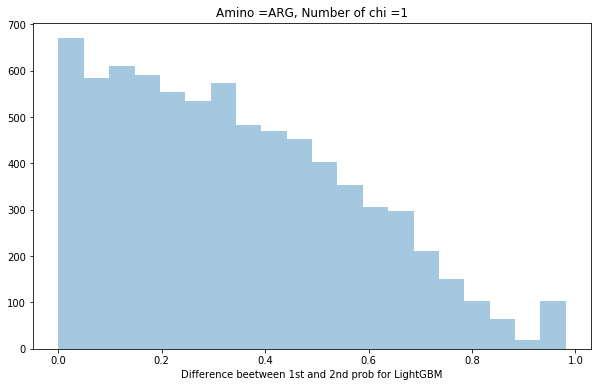

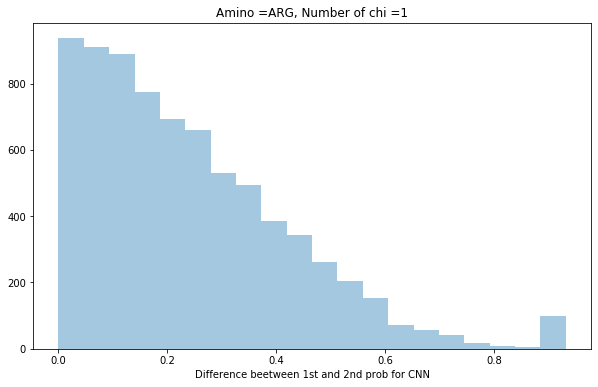

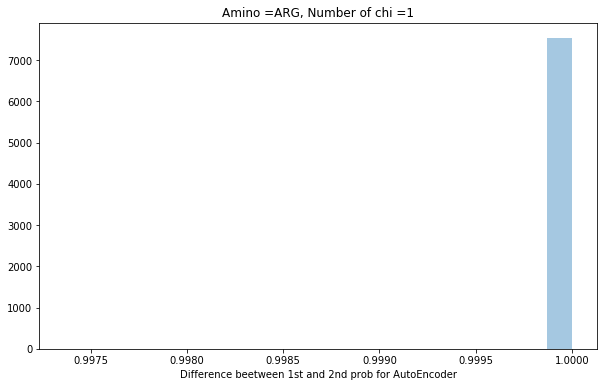

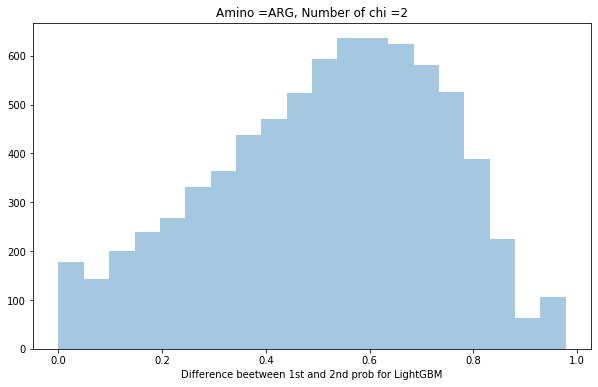

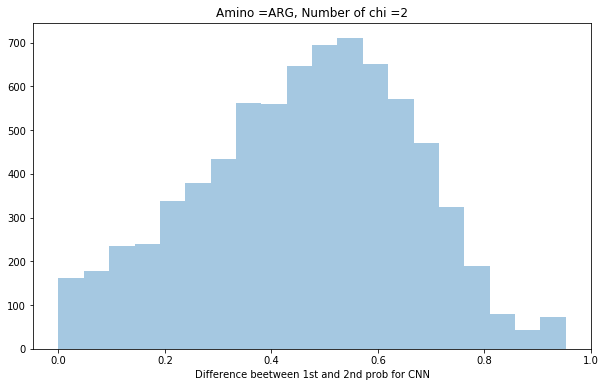

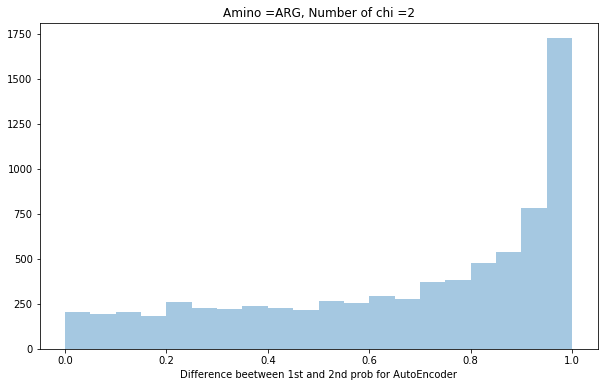

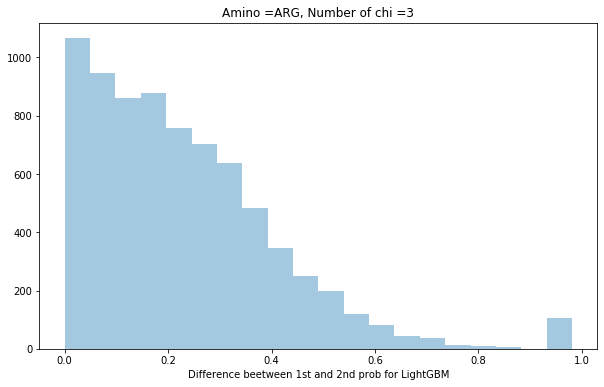

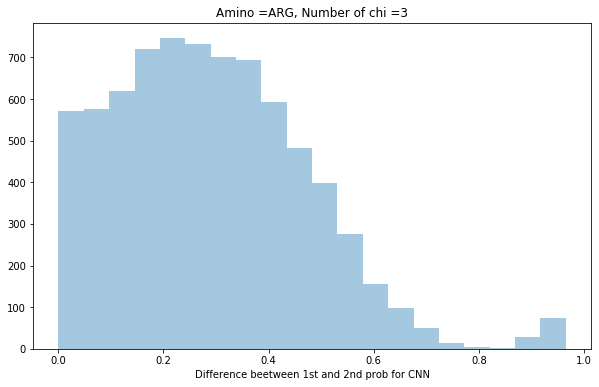

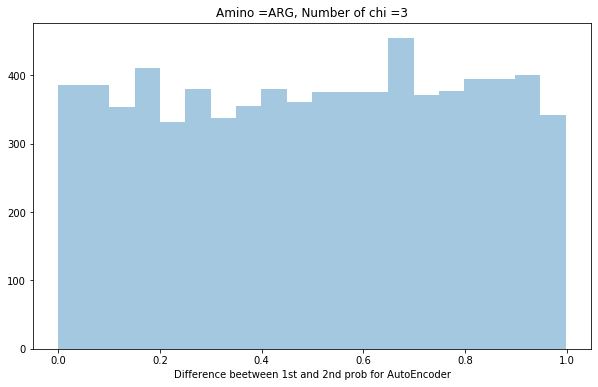

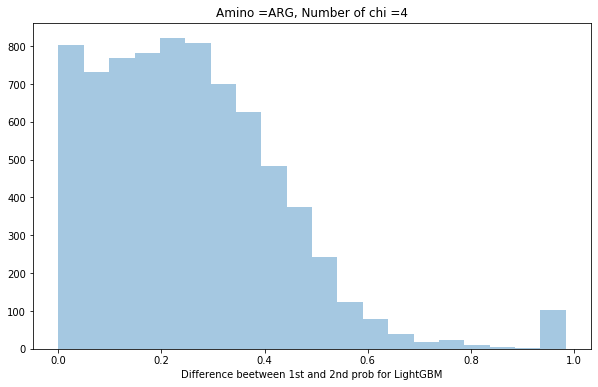

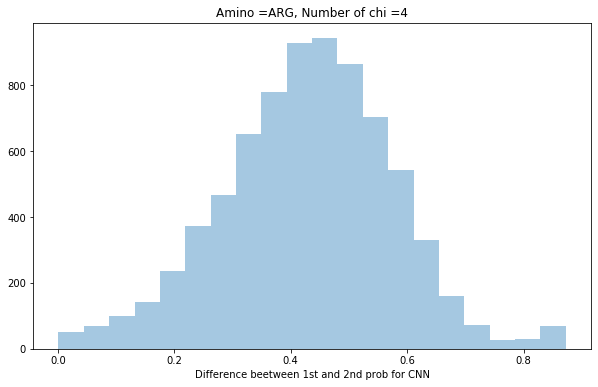

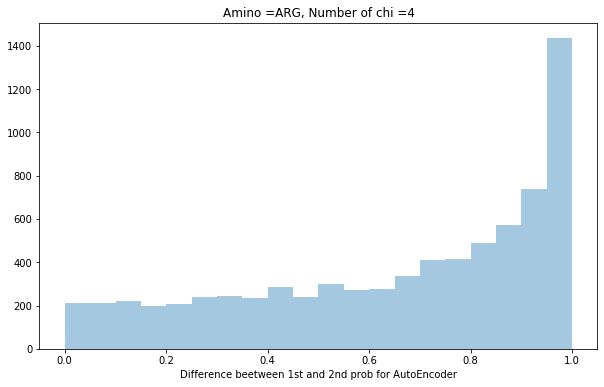

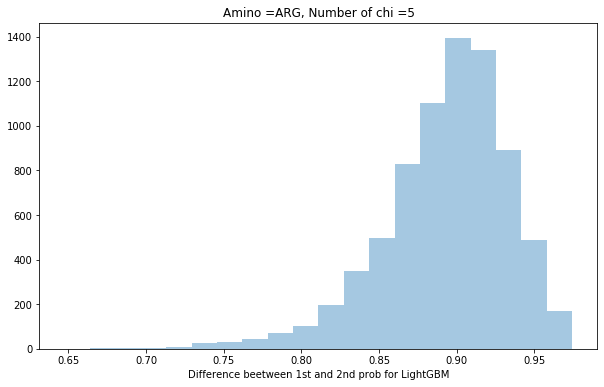

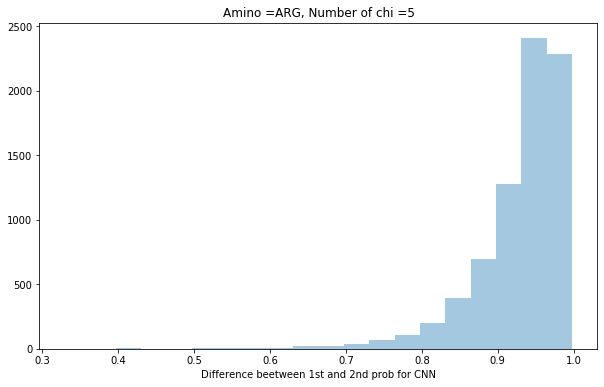

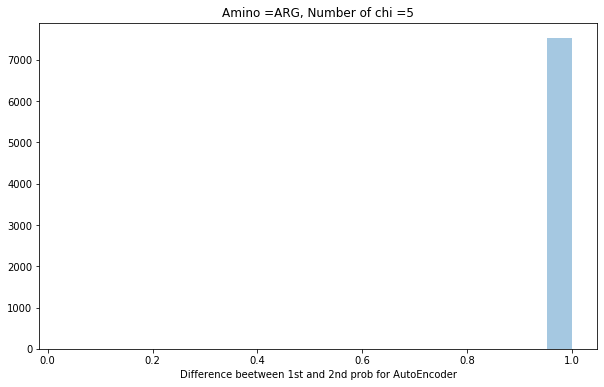

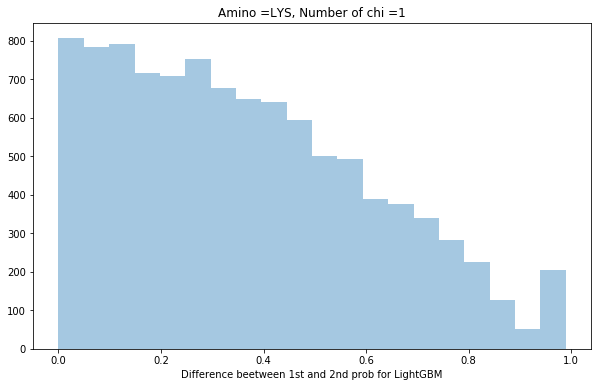

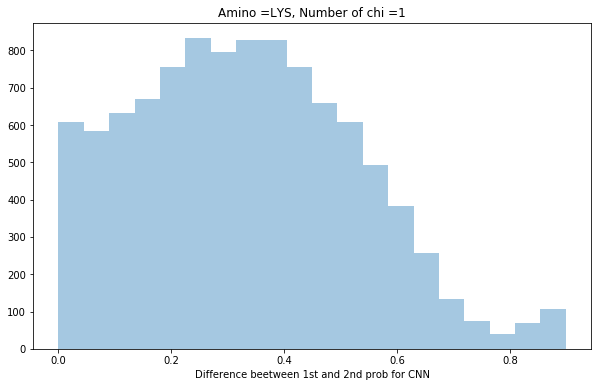

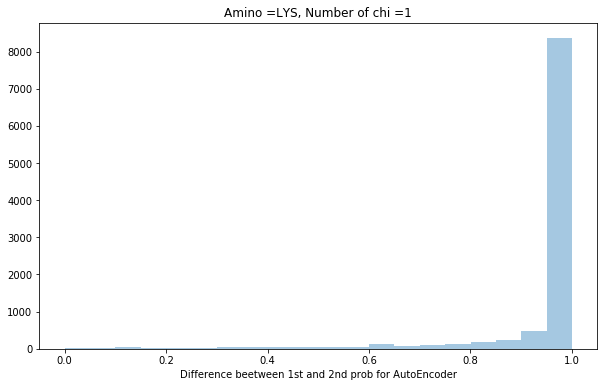

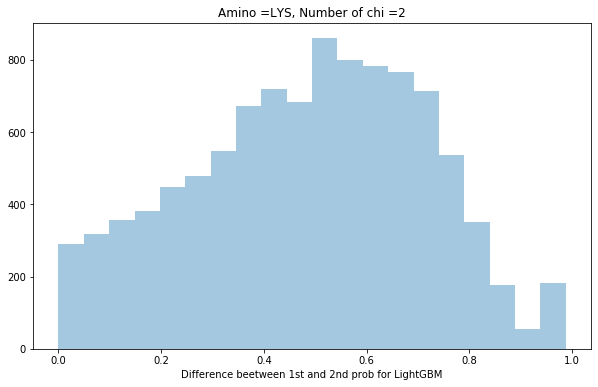

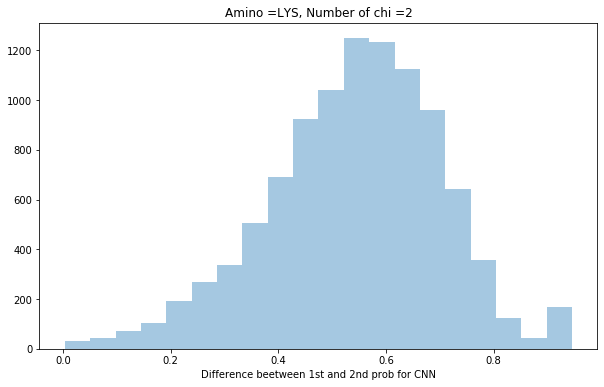

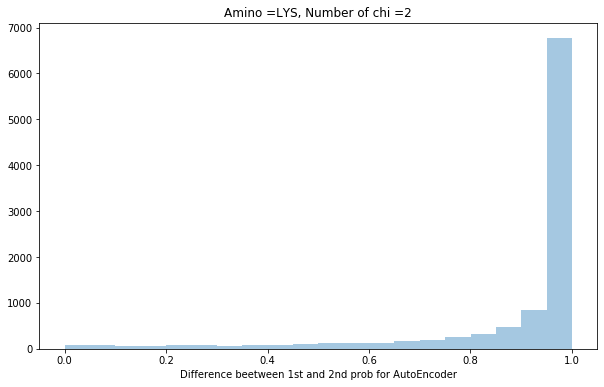

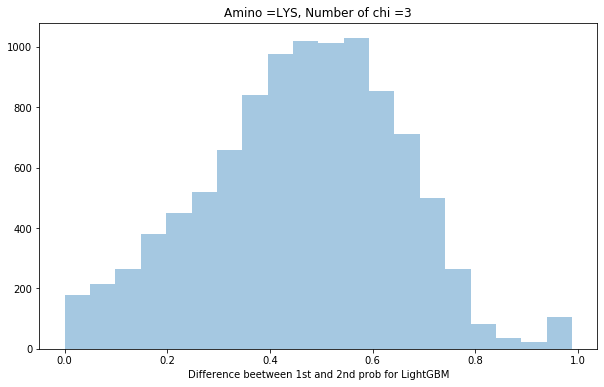

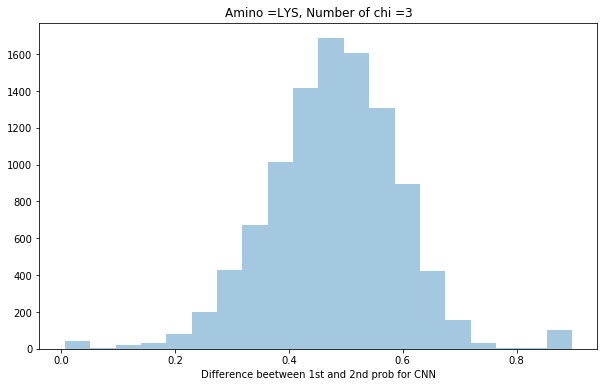

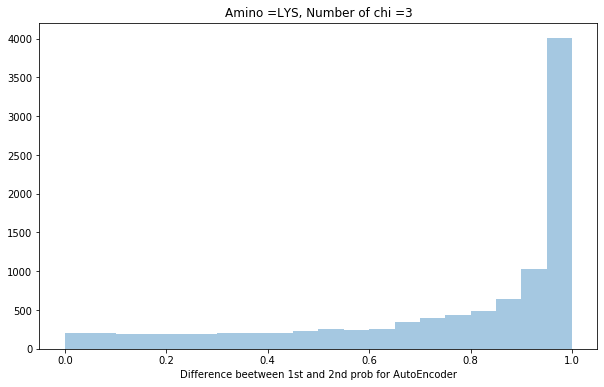

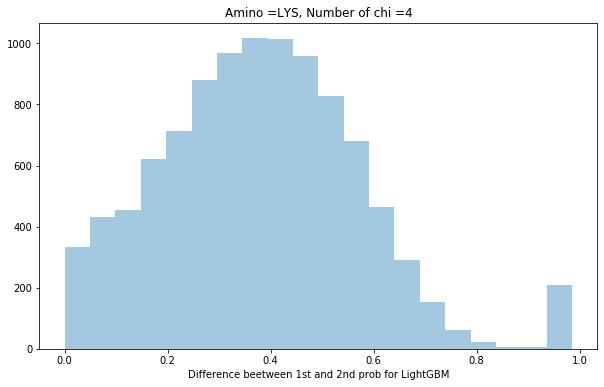

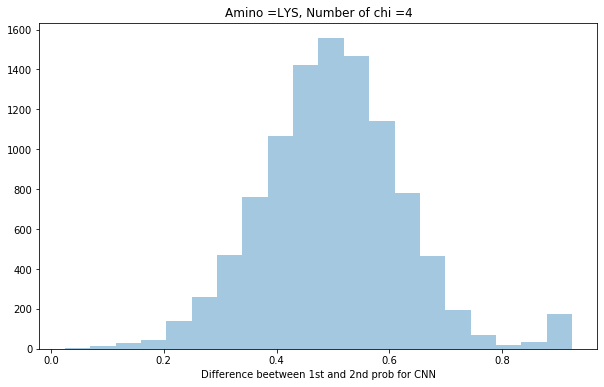

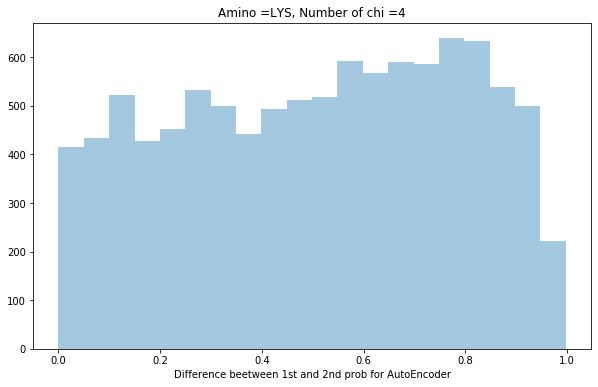

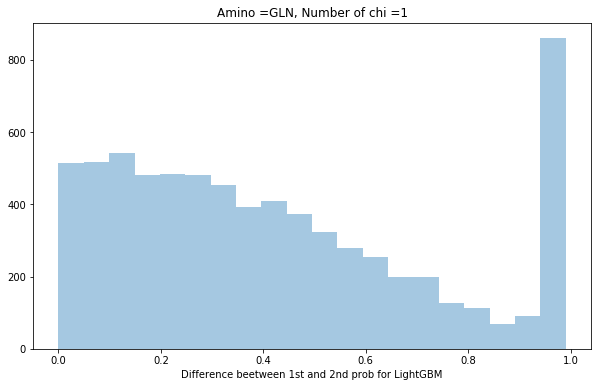

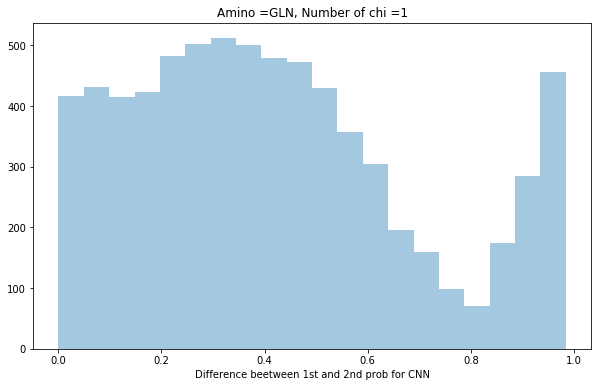

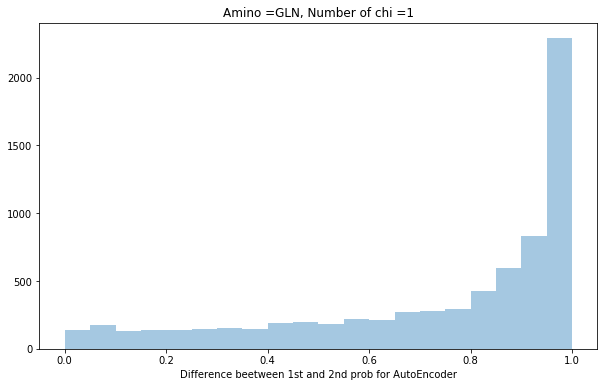

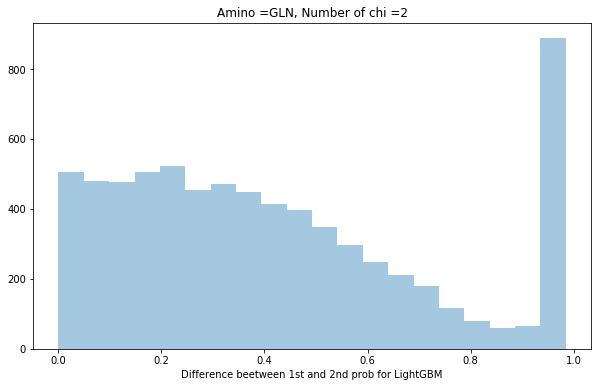

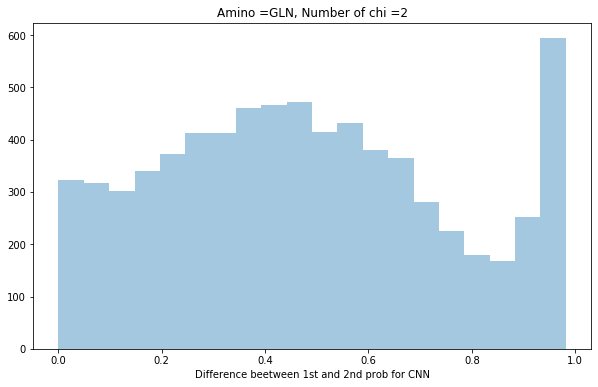

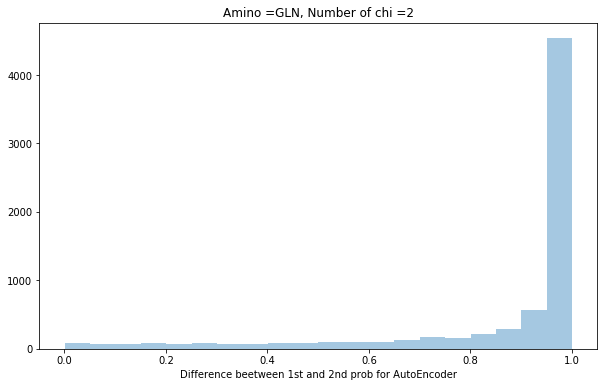

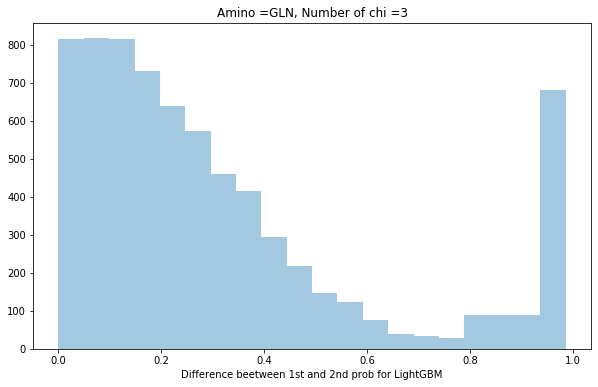

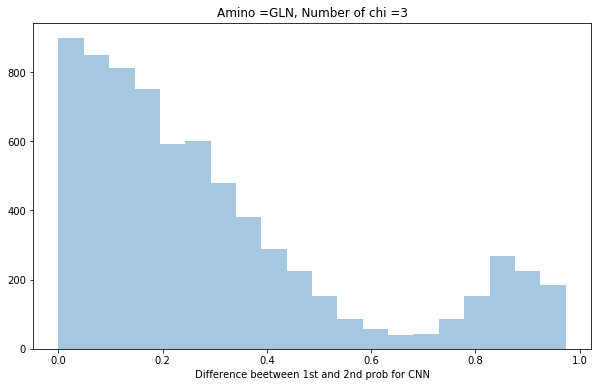

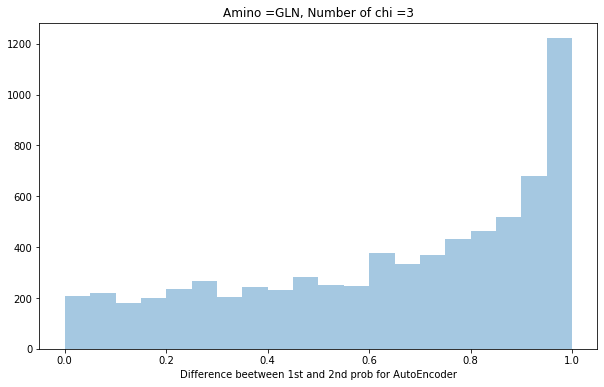

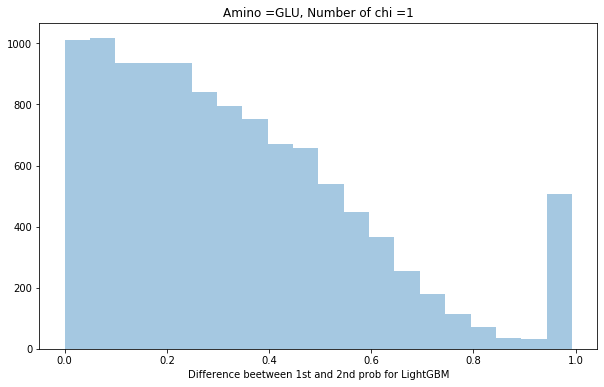

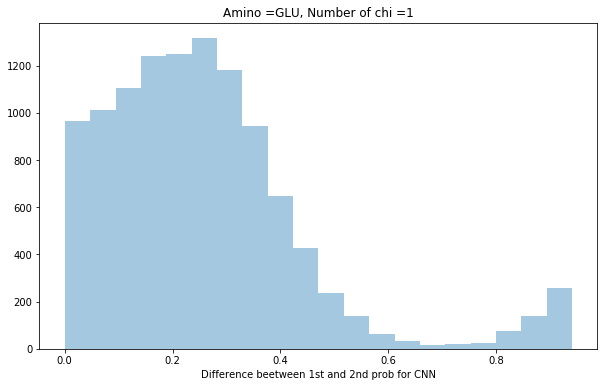

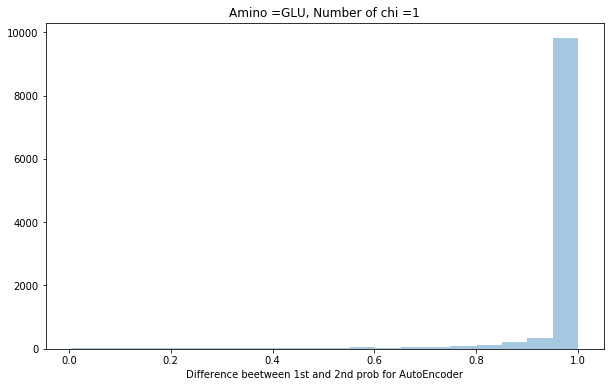

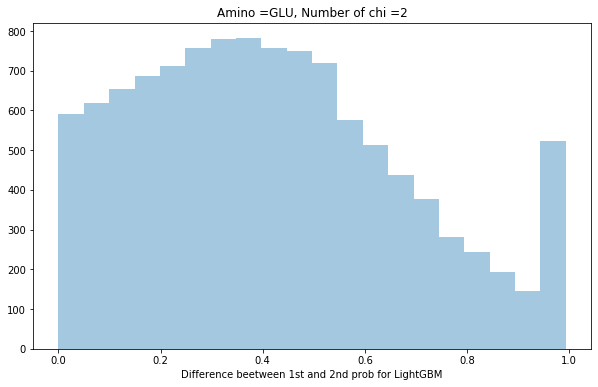

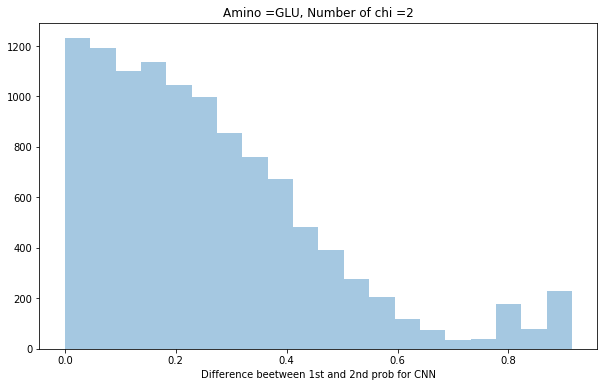

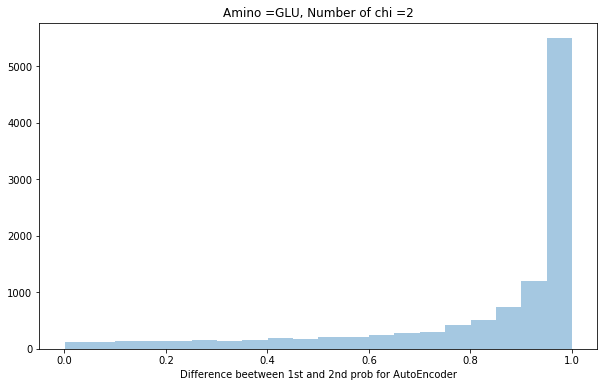

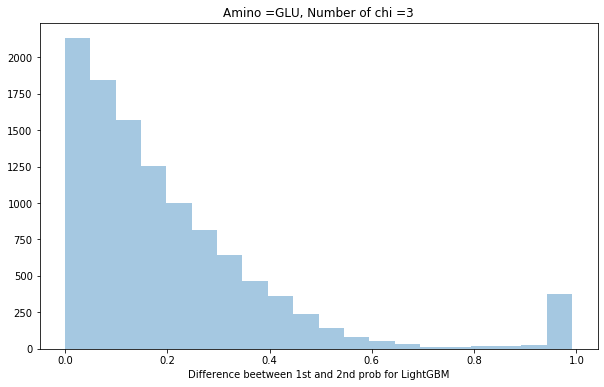

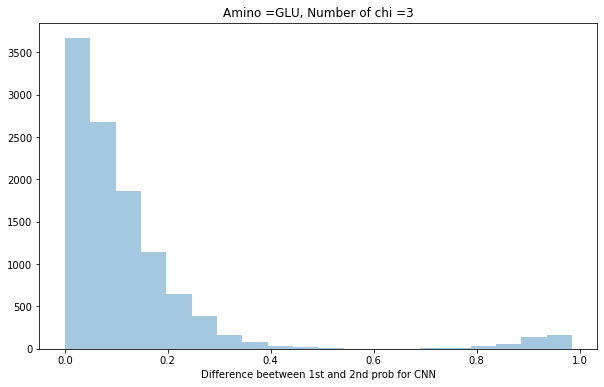

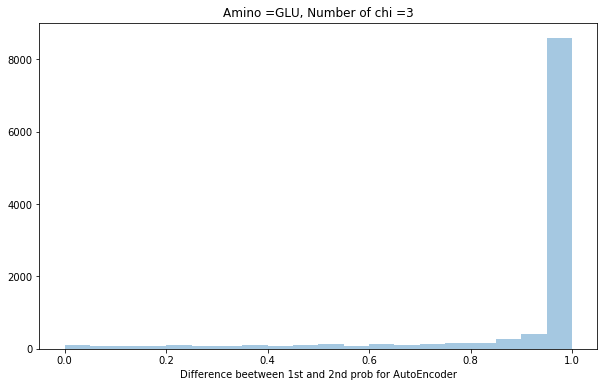

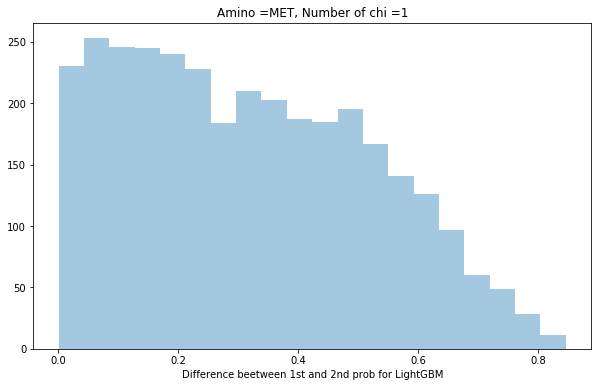

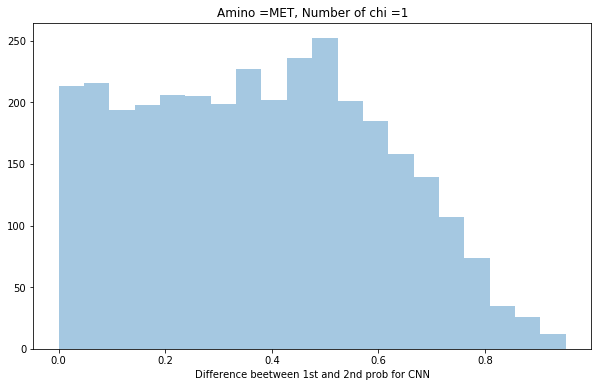

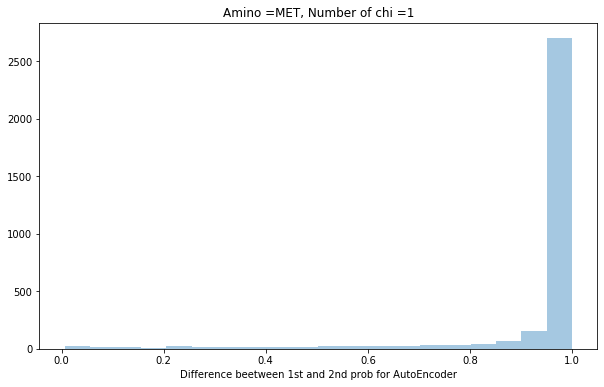

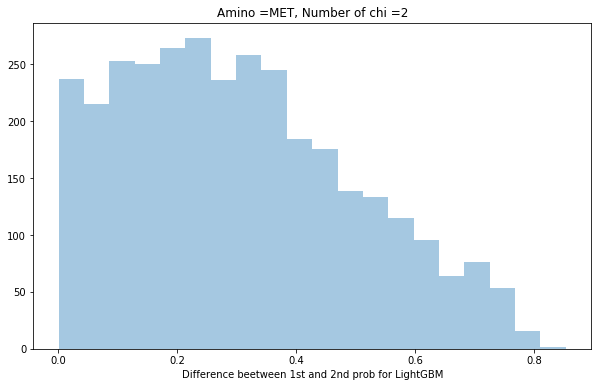

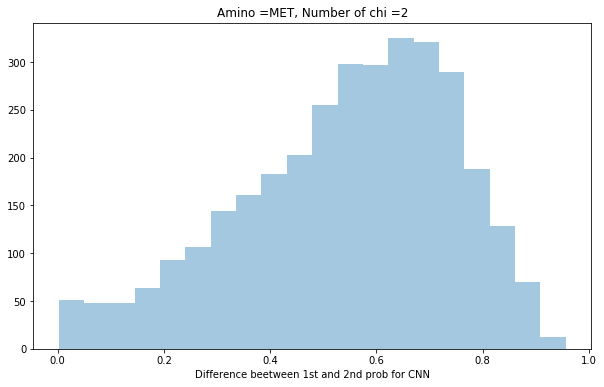

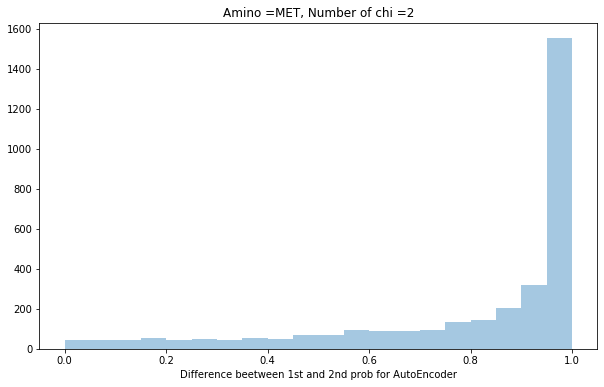

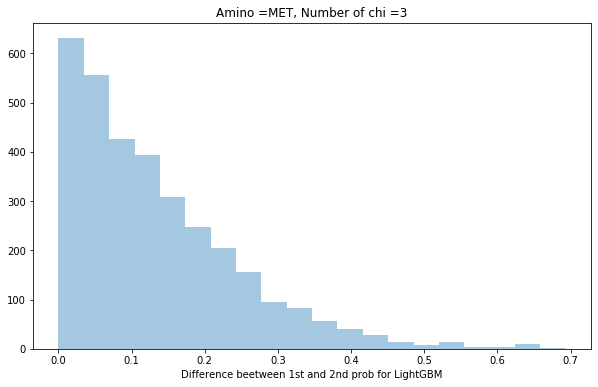

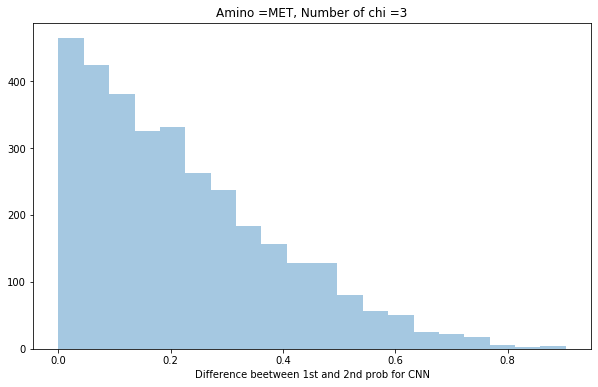

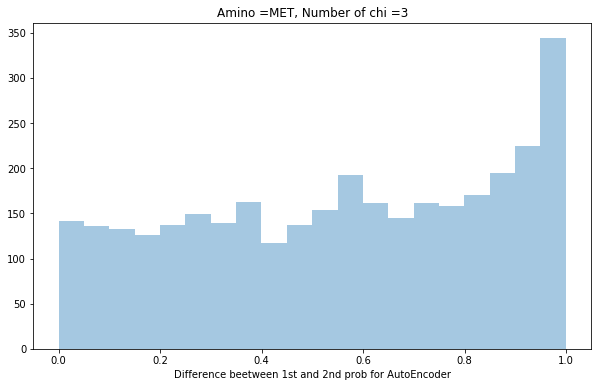

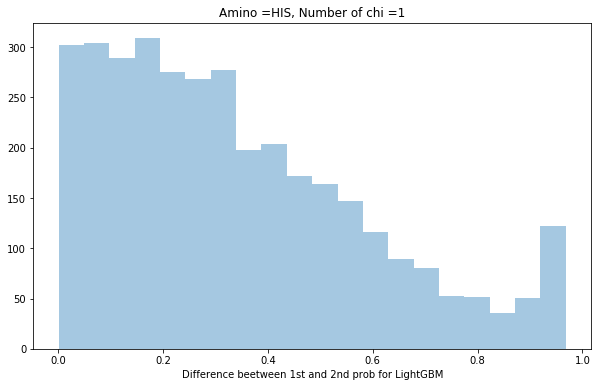

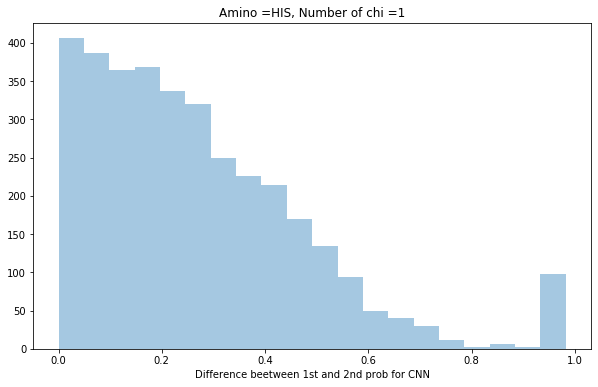

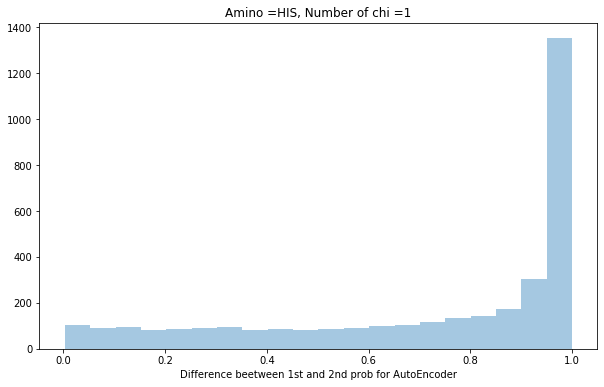

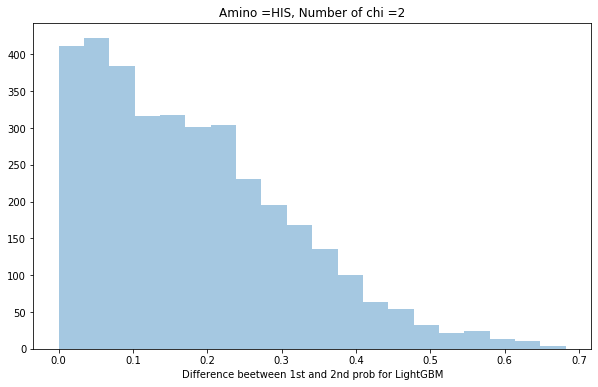

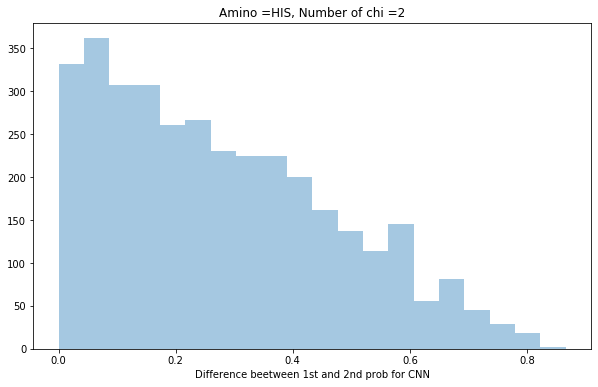

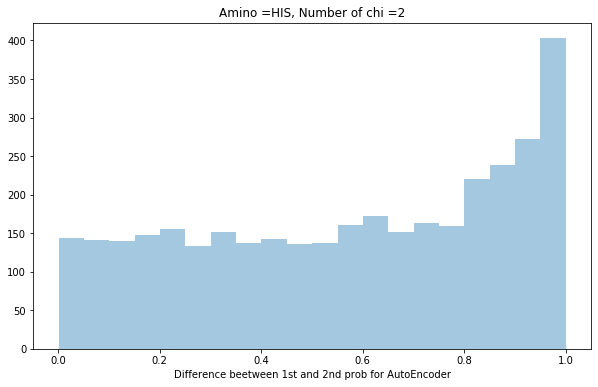

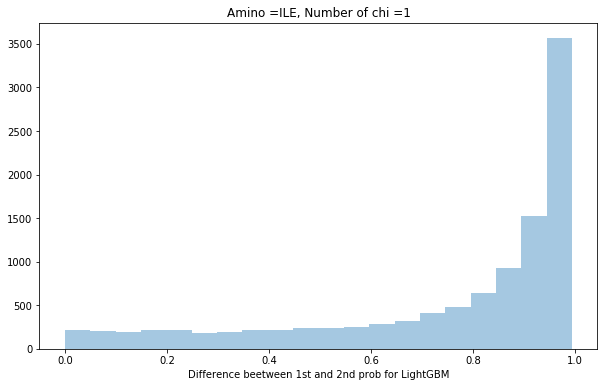

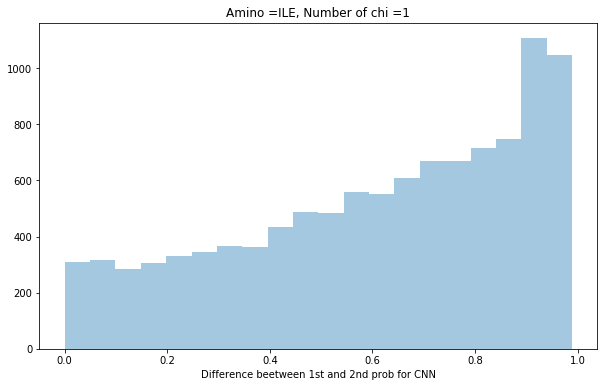

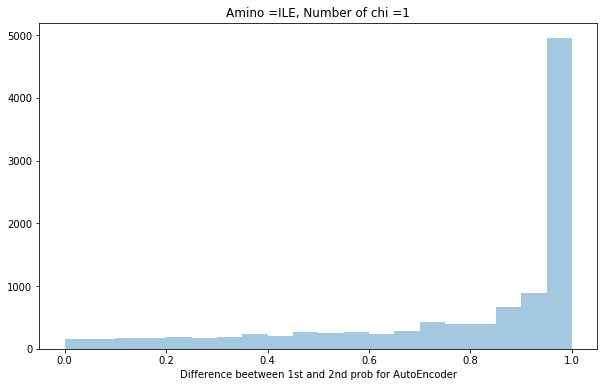

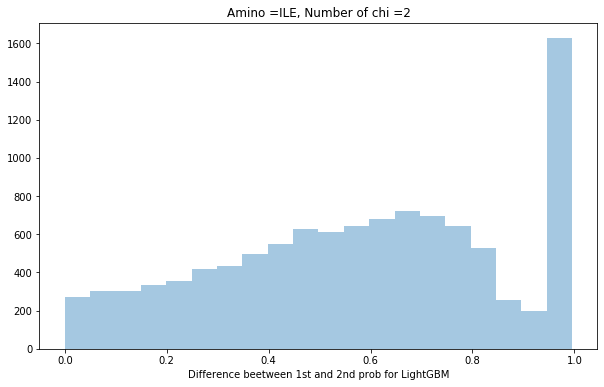

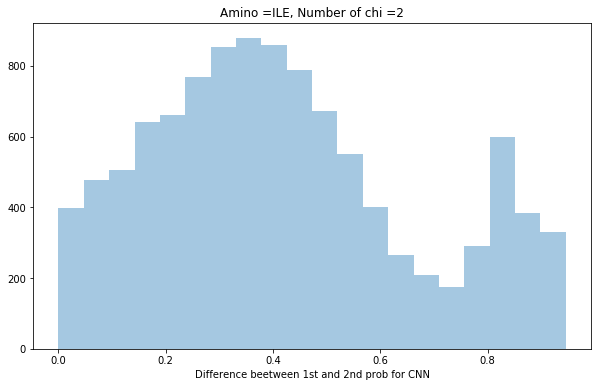

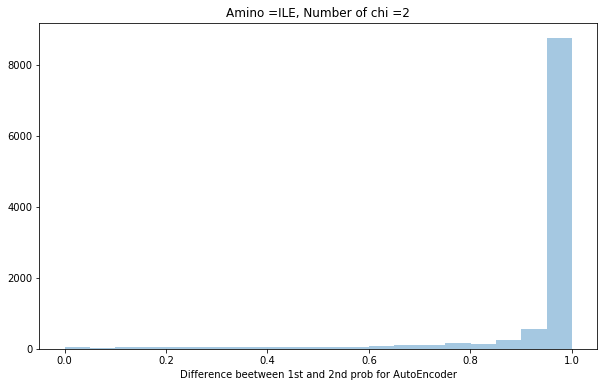

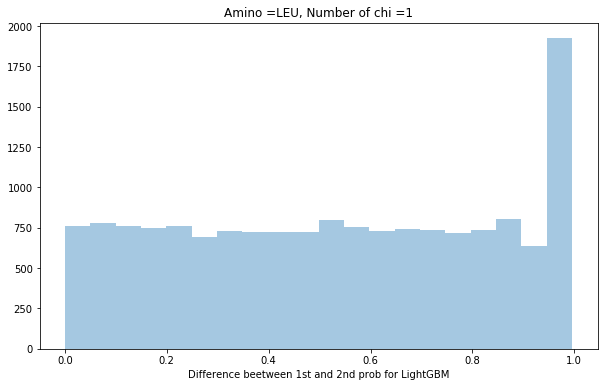

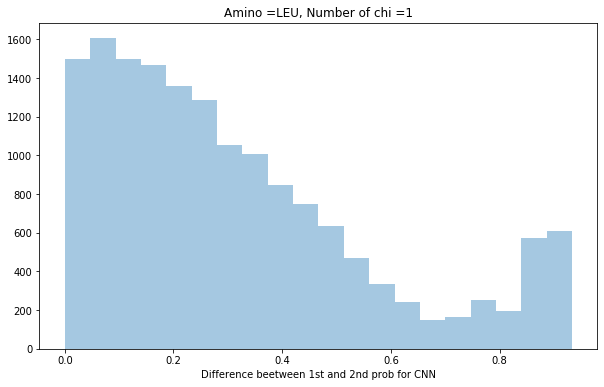

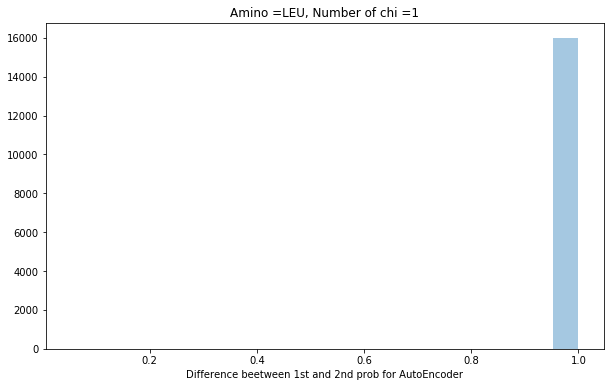

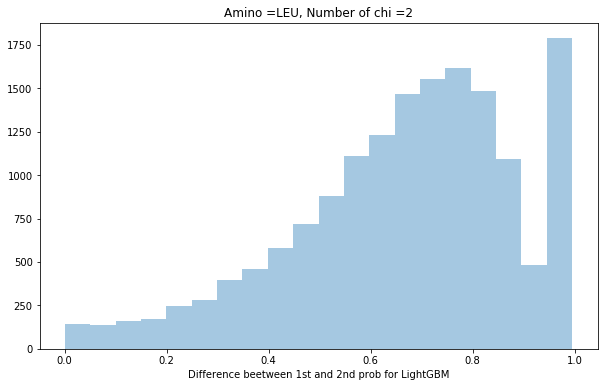

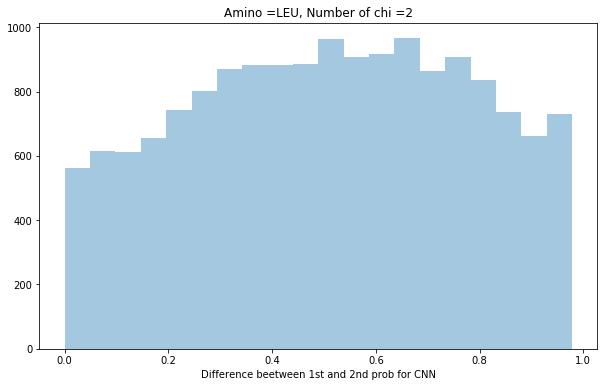

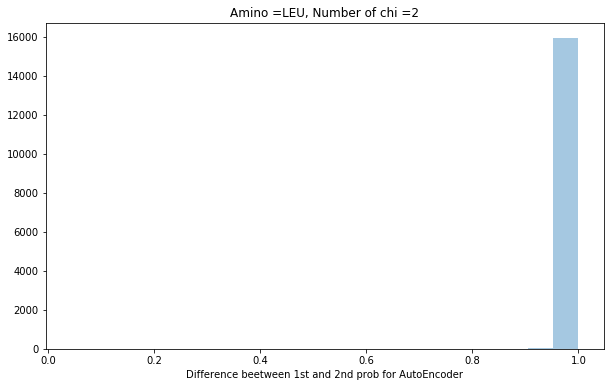

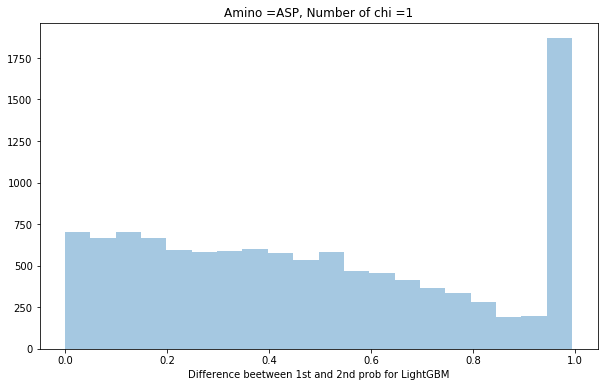

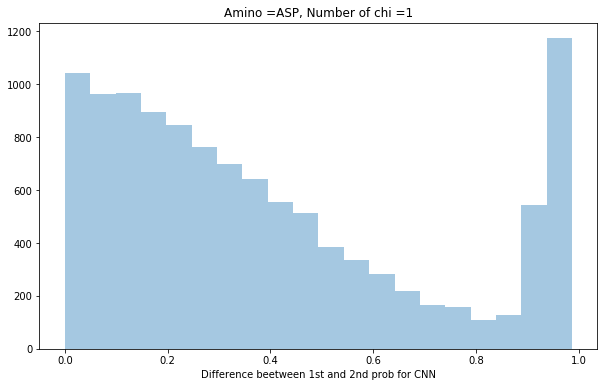

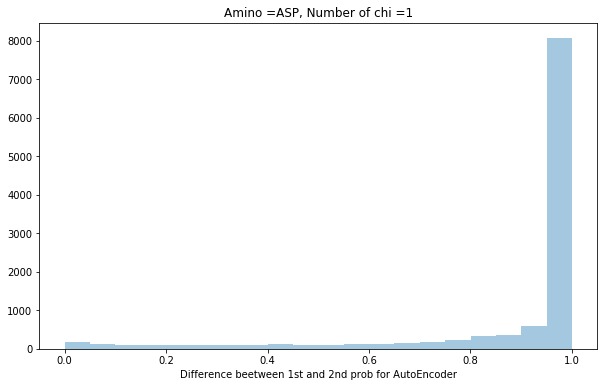

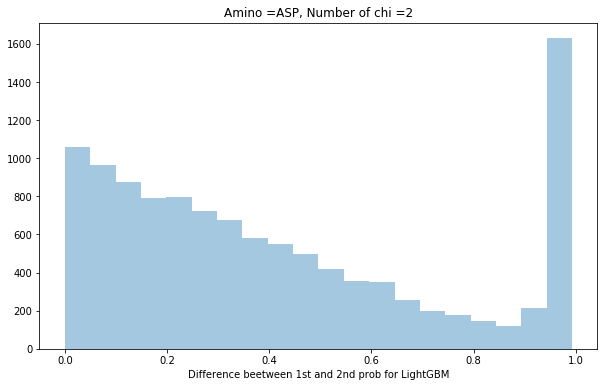

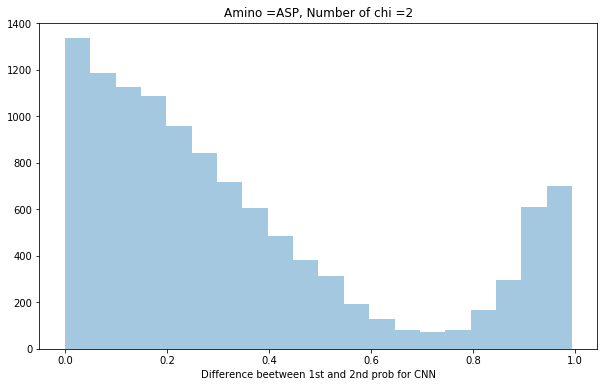

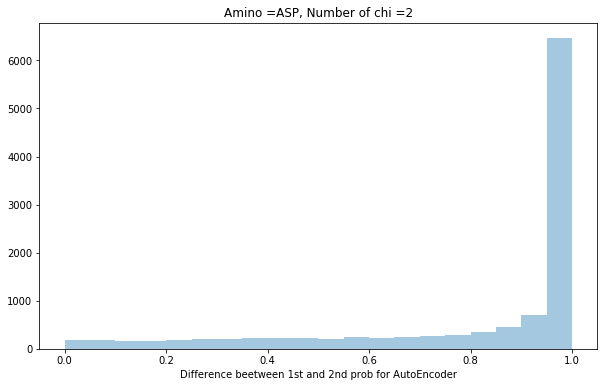

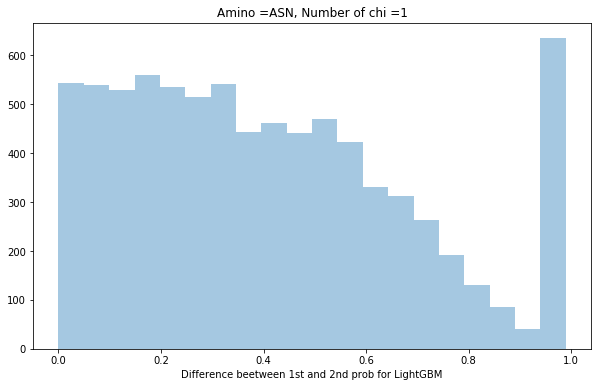

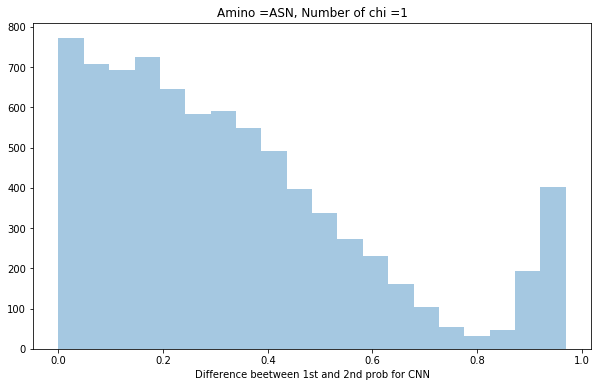

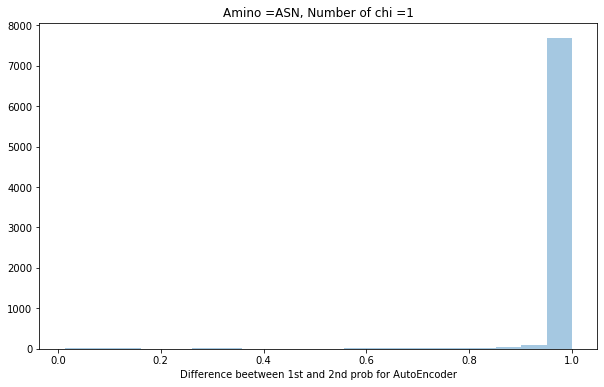

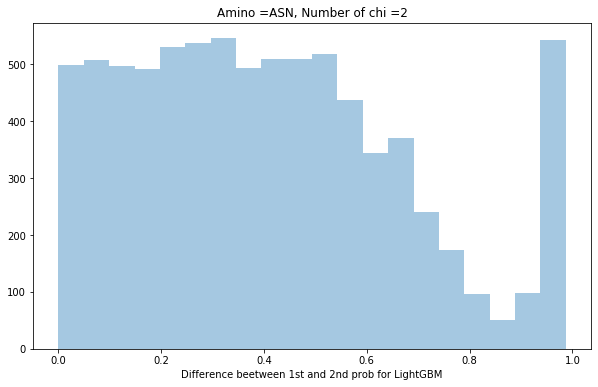

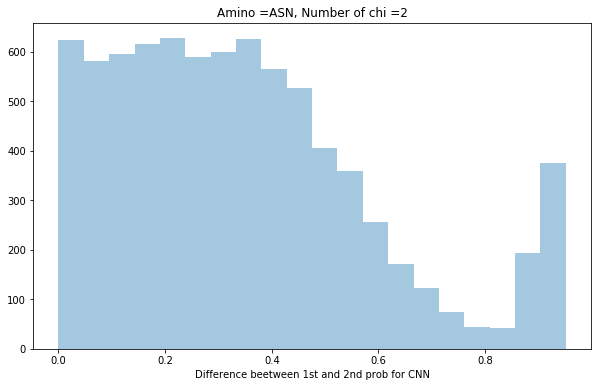

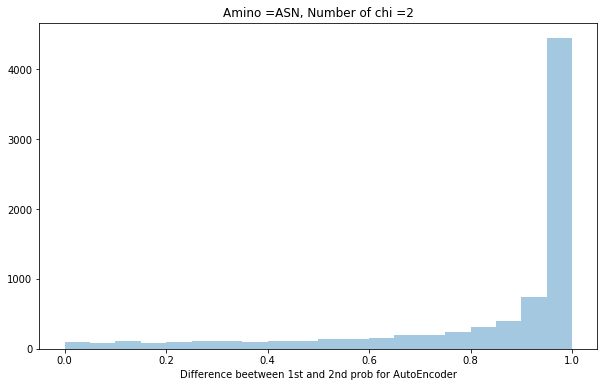

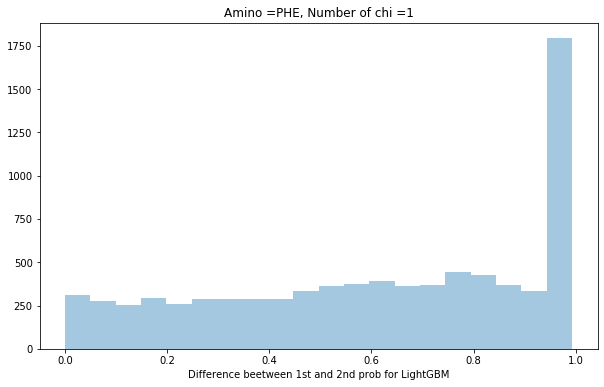

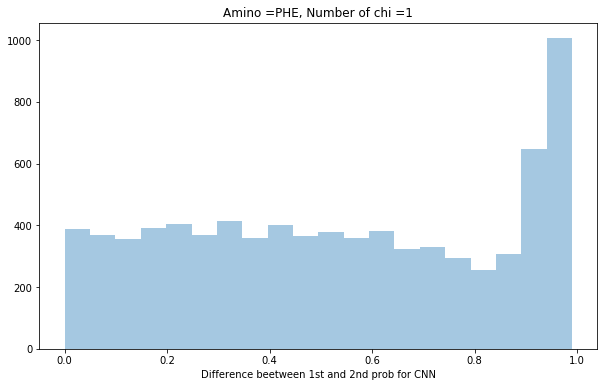

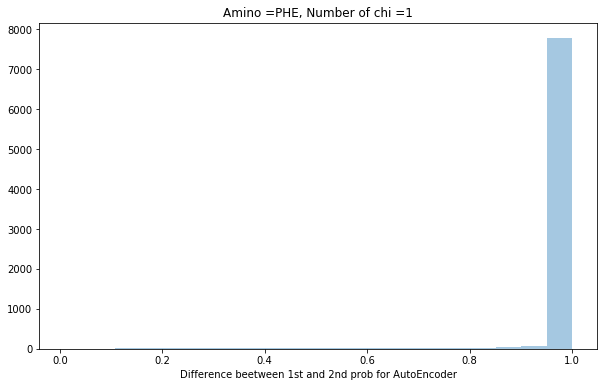

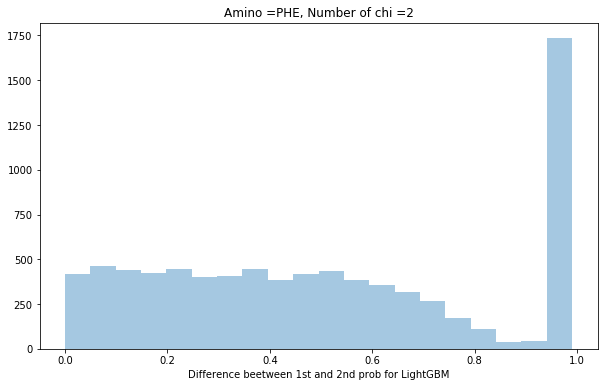

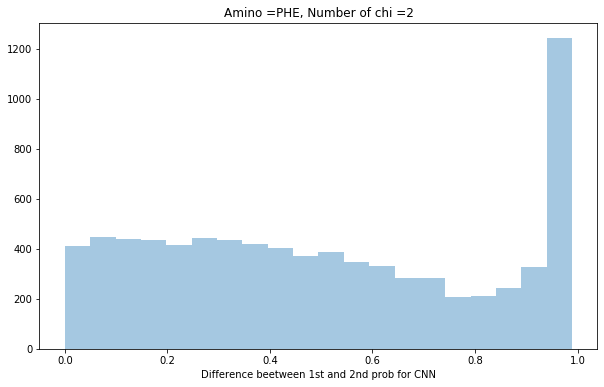

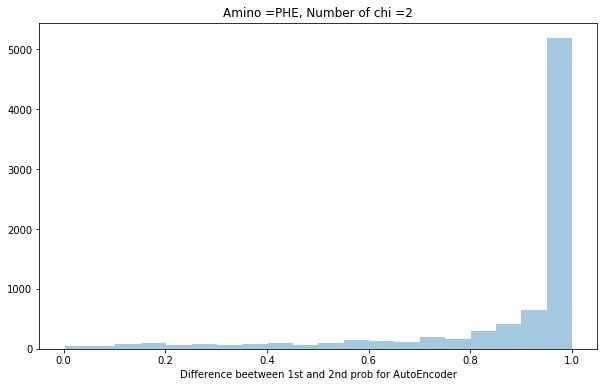

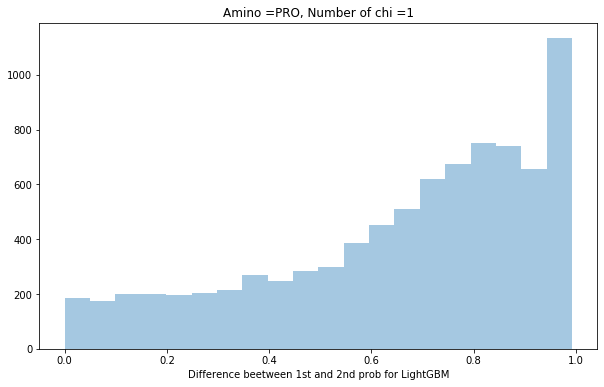

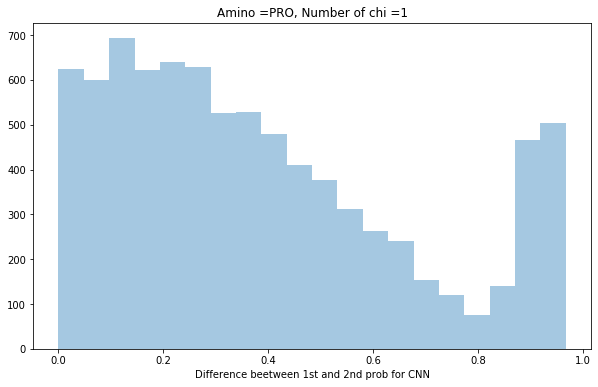

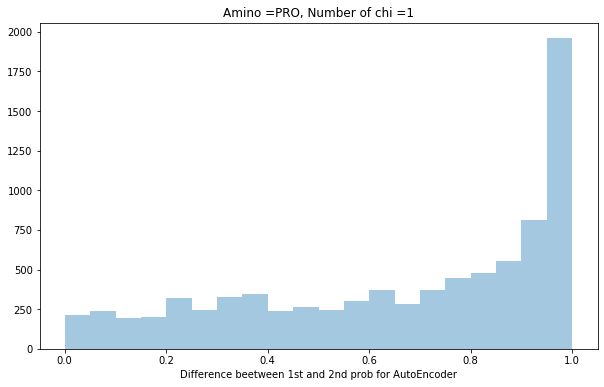

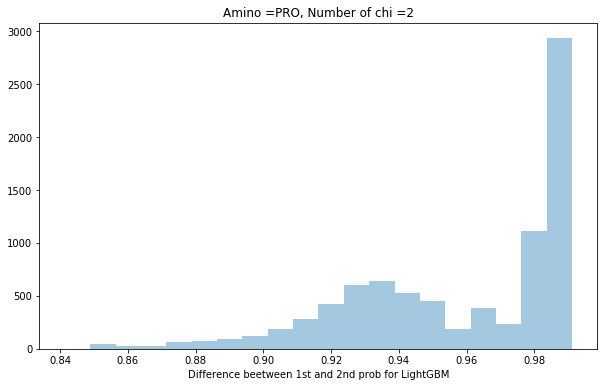

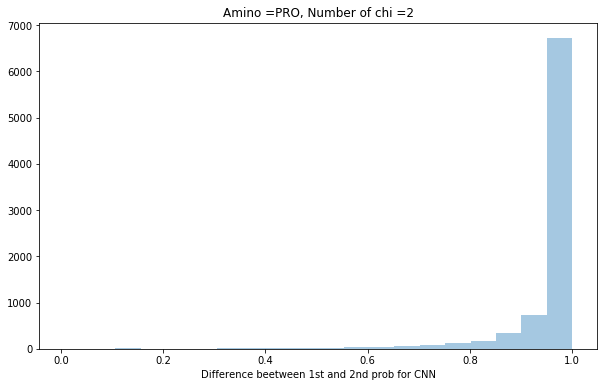

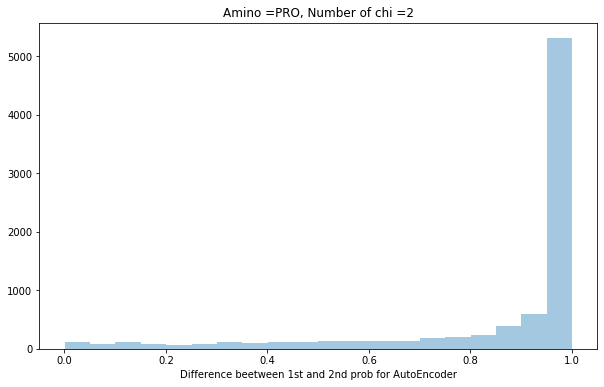

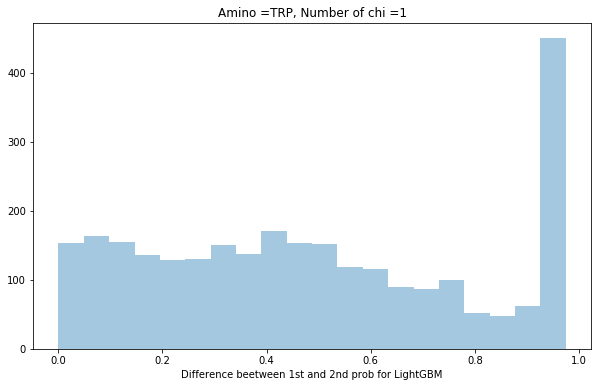

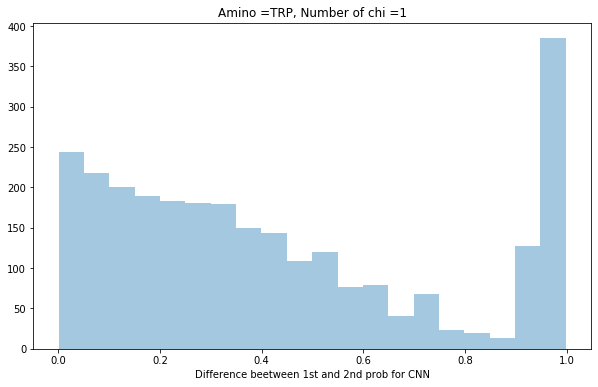

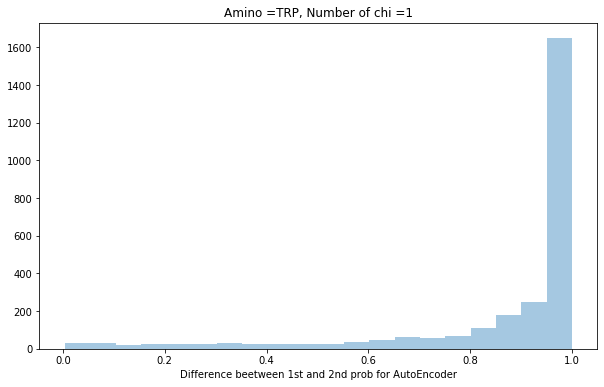

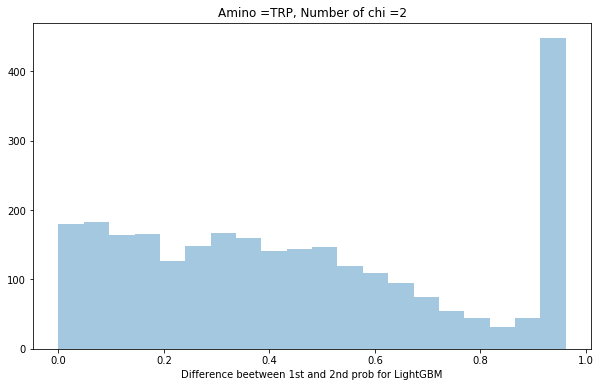

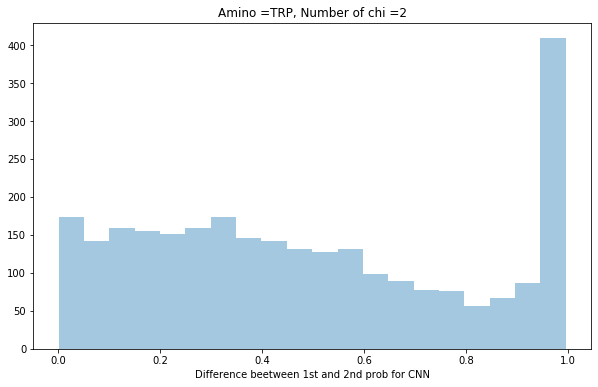

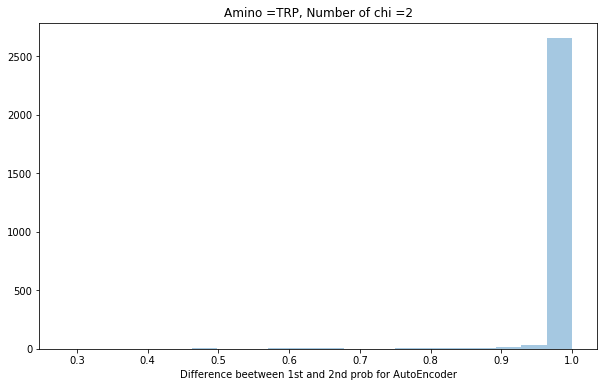

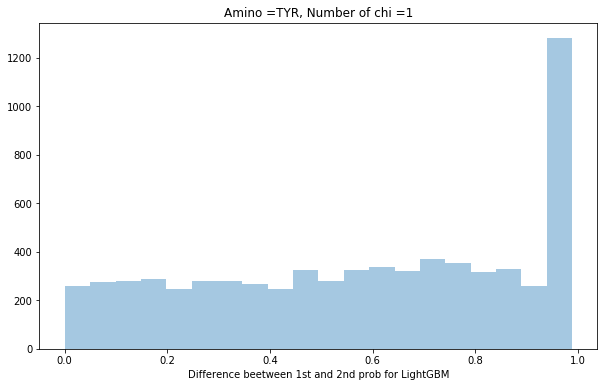

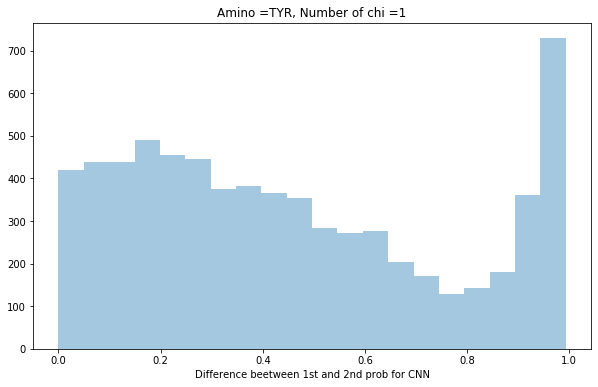

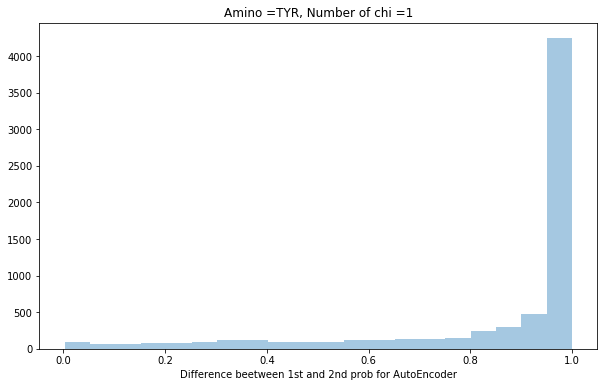

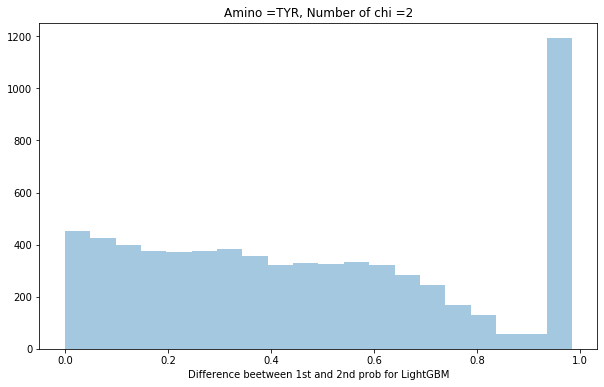

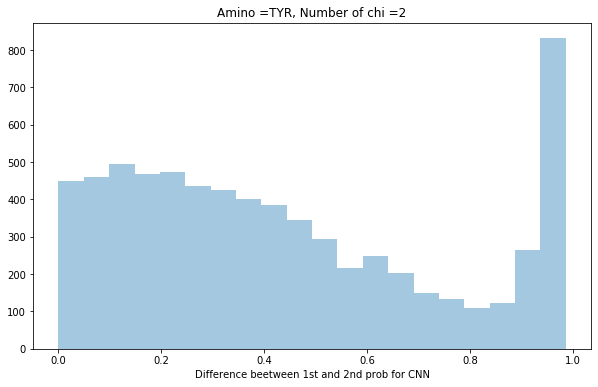

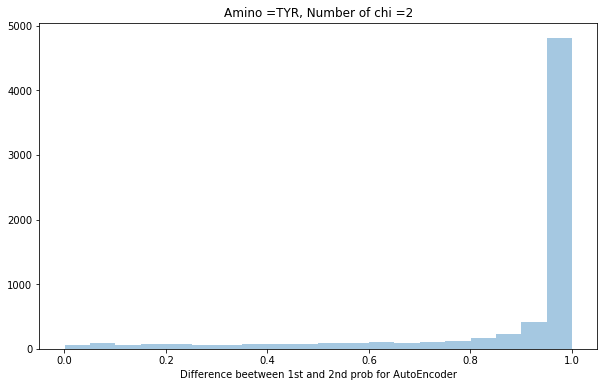

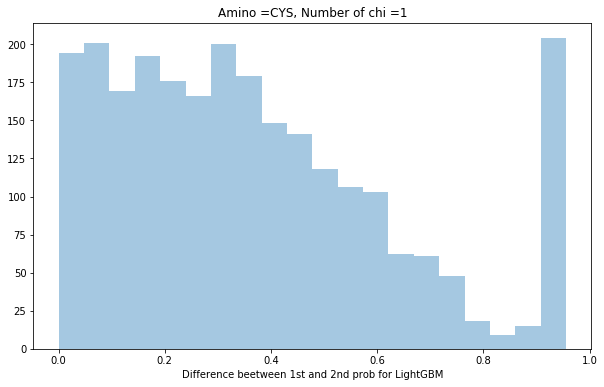

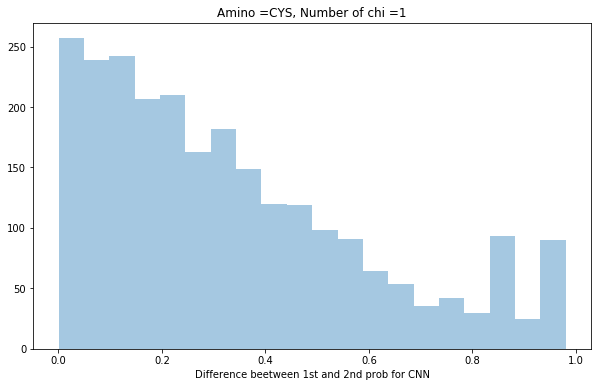

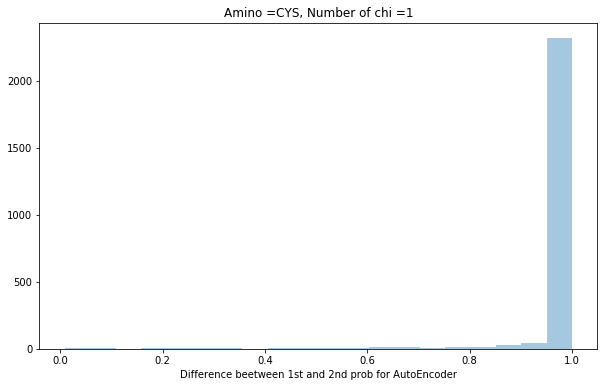

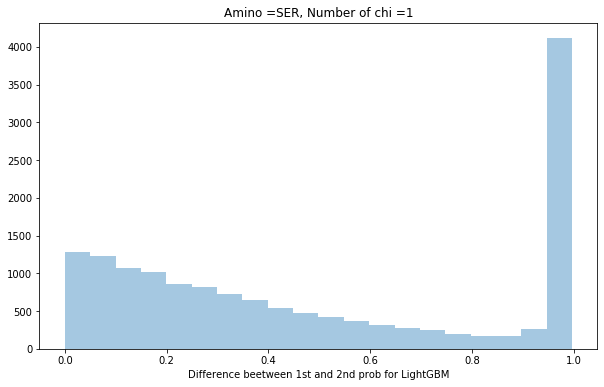

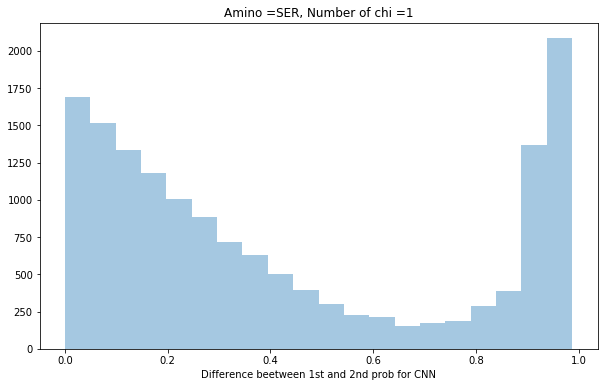

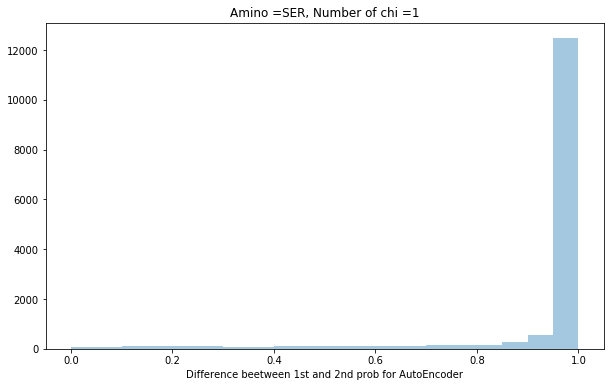

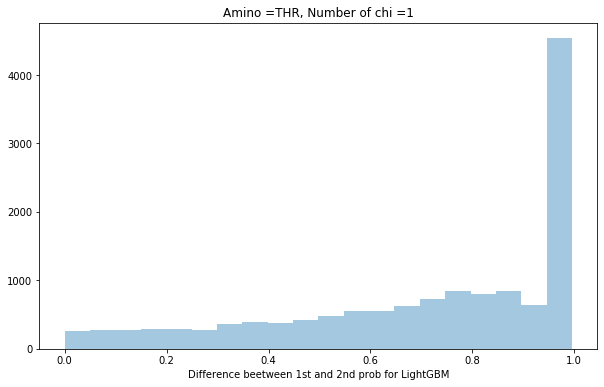

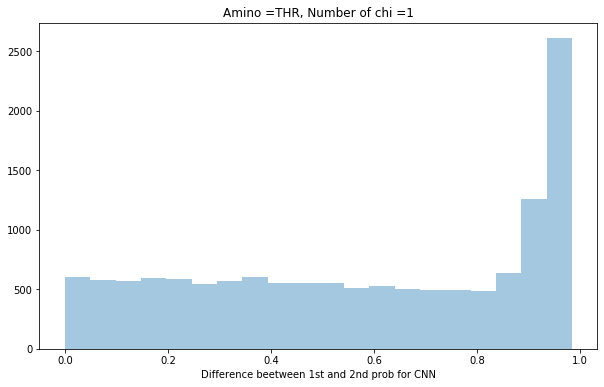

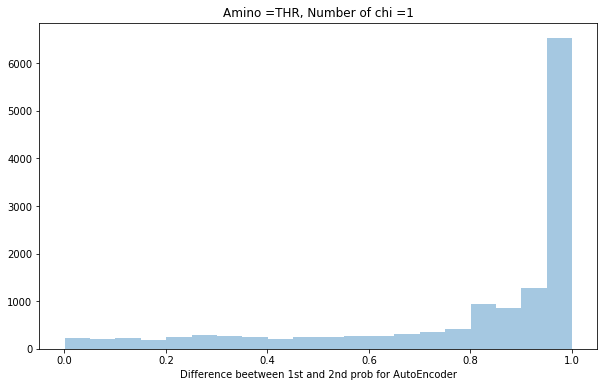

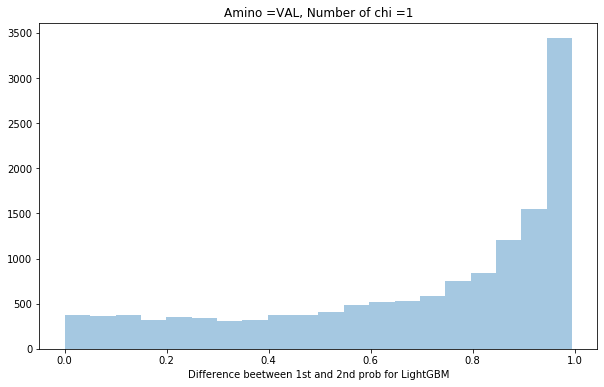

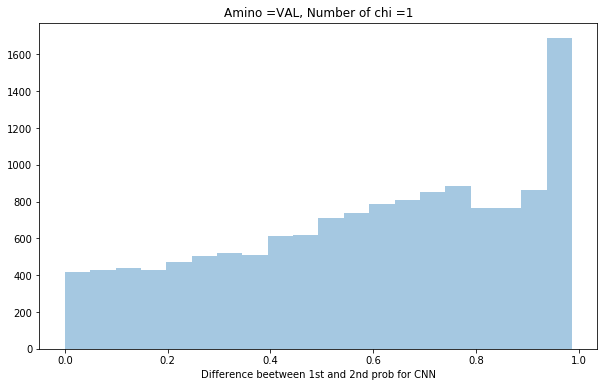

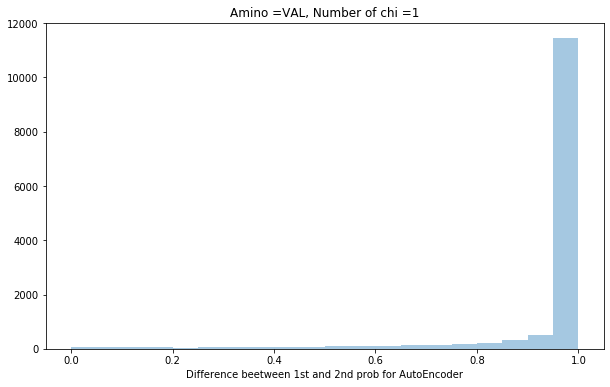

In [289]:
for amino in amino_arr:
    train_data = pd.read_csv(amino + '_train_data.csv')
    count = 0
    cols = train_data.columns.tolist()
    
    for i in range(len(cols)):
        words = cols[i].split('_')
        if ('chi' in words):
            count += 1
    for chi in range(count):
        df = pd.read_csv(amino + 'probas_chi_' + str(chi + 1) + '.csv')
        cols = df.columns
        if cols.size == 13:
            L_arr = np.sort(np.asarray([df['L_1'].to_numpy(), df['L_2'].to_numpy(), df['L_3'].to_numpy(), df['L_4'].to_numpy()]).T, axis=1).T
            C_arr = np.sort(np.asarray([df['C_1'].to_numpy(), df['C_2'].to_numpy(), df['C_3'].to_numpy(), df['C_4'].to_numpy()]).T, axis=1).T
            A_arr = np.sort(np.asarray([df['A_1'].to_numpy(), df['A_2'].to_numpy(), df['A_3'].to_numpy(), df['A_4'].to_numpy()]).T, axis=1).T
            L_arr_diff = L_arr[3] - L_arr[2]
            C_arr_diff = C_arr[3] - C_arr[2]
            A_arr_diff = A_arr[3] - A_arr[2]
            plt.figure(figsize=(10, 6))
            sns.distplot(L_arr_diff, kde=False, bins=20)
            plt.xlabel('Difference beetween 1st and 2nd prob for LightGBM')
            plt.title('Amino =' + amino + ', Number of chi =' + str(chi + 1))
            plt.figure(figsize=(10, 6))
            sns.distplot(C_arr_diff, kde=False, bins=20)
            plt.xlabel('Difference beetween 1st and 2nd prob for CNN')
            plt.title('Amino =' + amino + ', Number of chi =' + str(chi + 1))
            plt.figure(figsize=(10, 6))
            sns.distplot(A_arr_diff, kde=False, bins=20)
            plt.xlabel('Difference beetween 1st and 2nd prob for AutoEncoder')
            plt.title('Amino =' + amino + ', Number of chi =' + str(chi + 1))
        if cols.size == 10:
            L_arr = np.sort(np.asarray([df['L_1'].to_numpy(), df['L_2'].to_numpy(), df['L_3'].to_numpy()]).T, axis=1).T
            C_arr = np.sort(np.asarray([df['C_1'].to_numpy(), df['C_2'].to_numpy(), df['C_3'].to_numpy()]).T, axis=1).T
            A_arr = np.sort(np.asarray([df['A_1'].to_numpy(), df['A_2'].to_numpy(), df['A_3'].to_numpy()]).T, axis=1).T
            L_arr_diff = L_arr[2] - L_arr[1]
            C_arr_diff = C_arr[2] - C_arr[1]
            A_arr_diff = A_arr[2] - A_arr[1]
            plt.figure(figsize=(10, 6))
            sns.distplot(L_arr_diff, kde=False, bins=20)
            plt.xlabel('Difference beetween 1st and 2nd prob for LightGBM')
            plt.title('Amino =' + amino + ', Number of chi =' + str(chi + 1))
            plt.figure(figsize=(10, 6))
            sns.distplot(C_arr_diff, kde=False, bins=20)
            plt.xlabel('Difference beetween 1st and 2nd prob for CNN')
            plt.title('Amino =' + amino + ', Number of chi =' + str(chi + 1))
            plt.figure(figsize=(10, 6))
            sns.distplot(A_arr_diff, kde=False, bins=20)
            plt.xlabel('Difference beetween 1st and 2nd prob for AutoEncoder')
            plt.title('Amino =' + amino + ', Number of chi =' + str(chi + 1))

        if cols.size == 7:
            L_arr = np.sort(np.asarray([df['L_1'].to_numpy(), df['L_2'].to_numpy()]).T, axis=1).T
            C_arr = np.sort(np.asarray([df['C_1'].to_numpy(), df['C_2'].to_numpy()]).T, axis=1).T
            A_arr = np.sort(np.asarray([df['A_1'].to_numpy(), df['A_2'].to_numpy()]).T, axis=1).T
            L_arr_diff = L_arr[1] - L_arr[0]
            C_arr_diff = C_arr[1] - C_arr[0]
            A_arr_diff = A_arr[1] - A_arr[0]
            plt.figure(figsize=(10, 6))
            sns.distplot(L_arr_diff, kde=False, bins=20)
            plt.xlabel('Difference beetween 1st and 2nd prob for LightGBM')
            plt.title('Amino =' + amino + ', Number of chi =' + str(chi + 1))
            plt.figure(figsize=(10, 6))
            sns.distplot(C_arr_diff, kde=False, bins=20)
            plt.xlabel('Difference beetween 1st and 2nd prob for CNN')
            plt.title('Amino =' + amino + ', Number of chi =' + str(chi + 1))
            plt.figure(figsize=(10, 6))
            sns.distplot(A_arr_diff, kde=False, bins=20)
            plt.xlabel('Difference beetween 1st and 2nd prob for AutoEncoder')
            plt.title('Amino =' + amino + ', Number of chi =' + str(chi + 1))

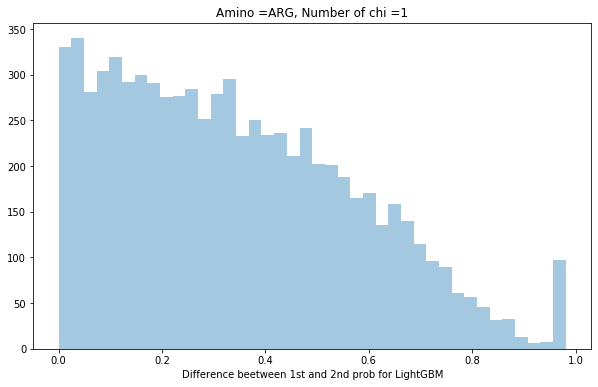

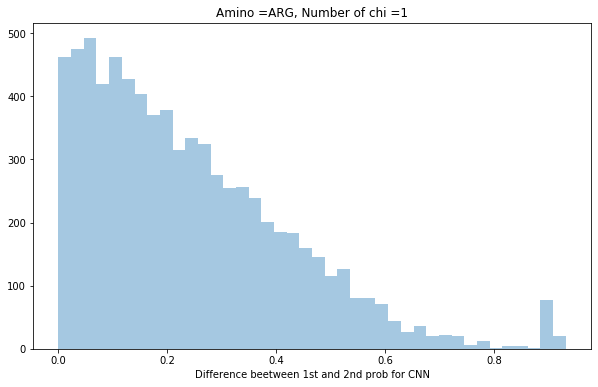

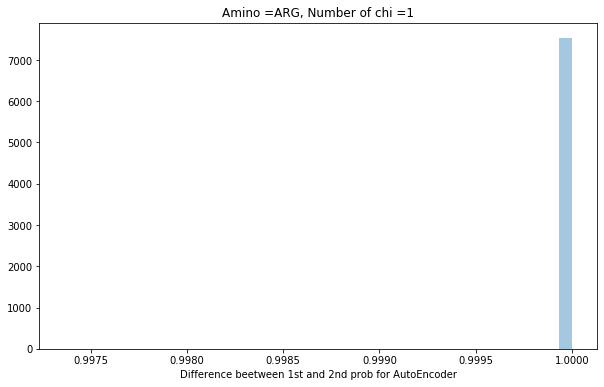

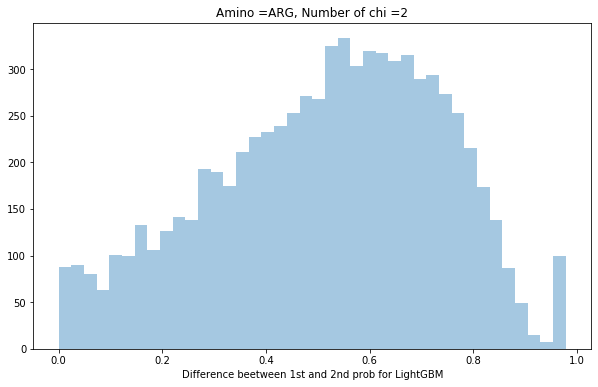

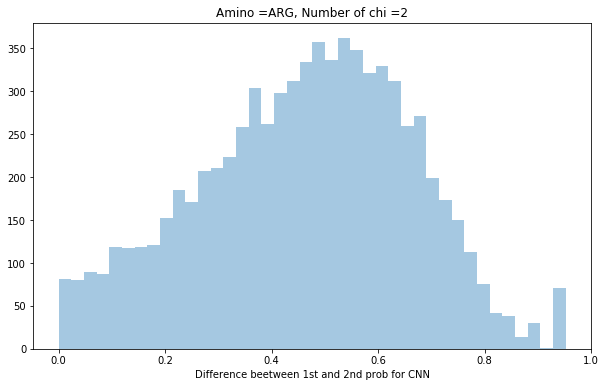

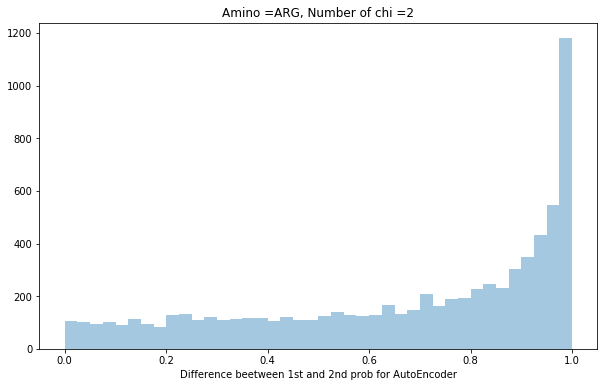

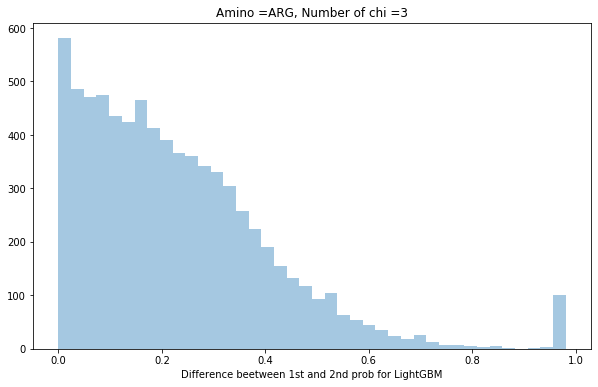

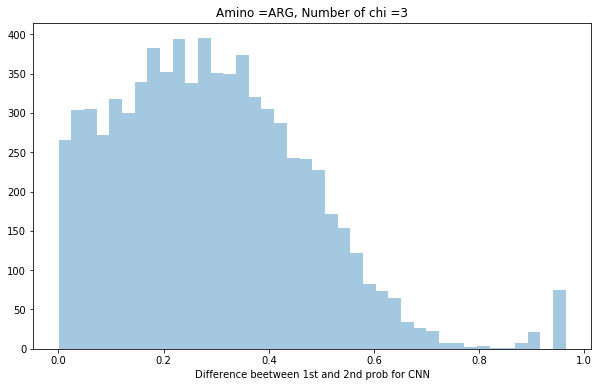

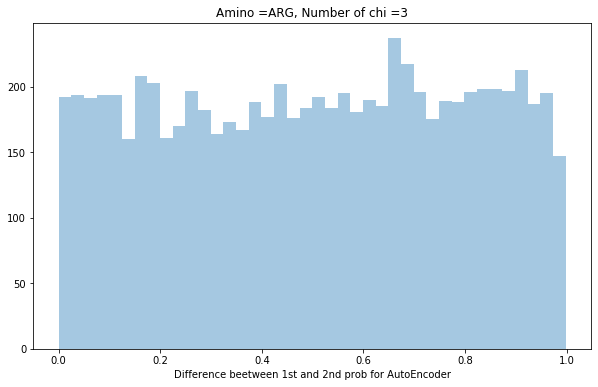

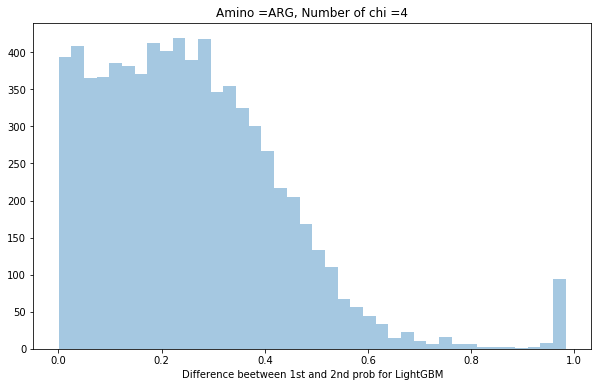

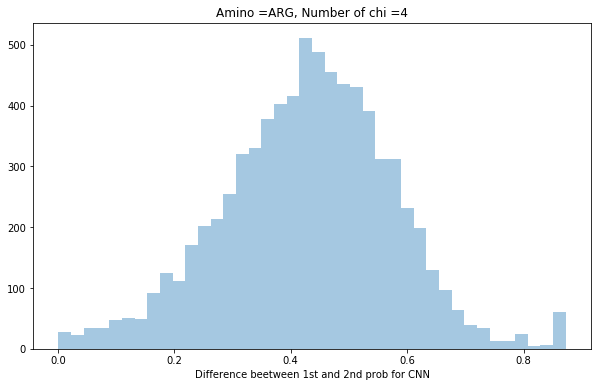

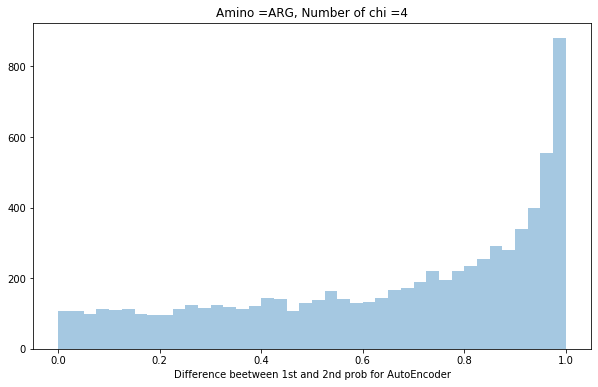

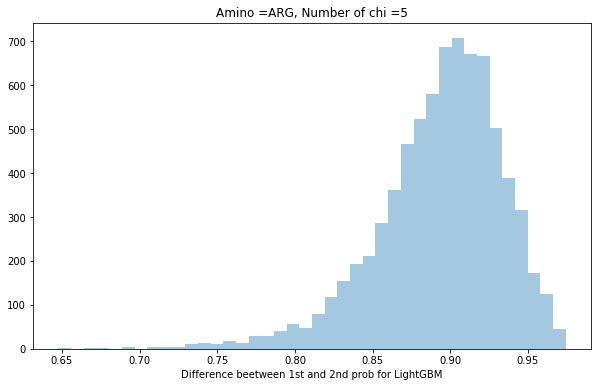

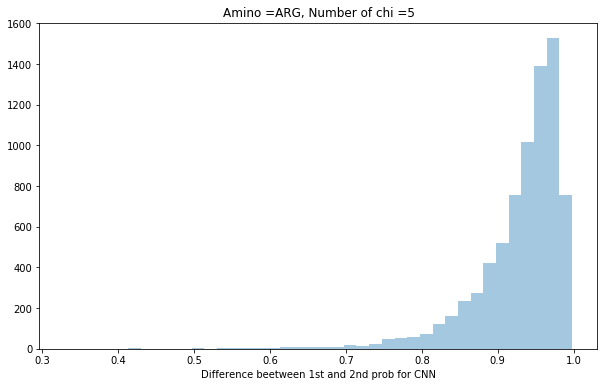

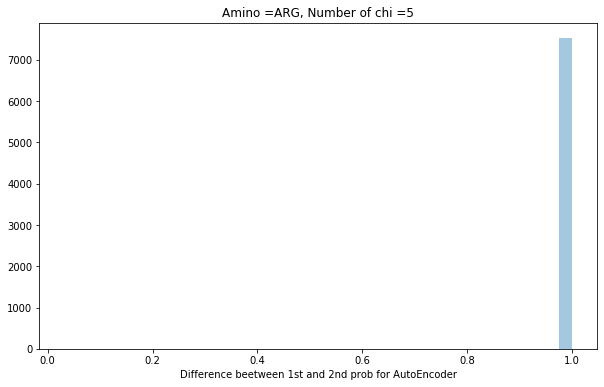

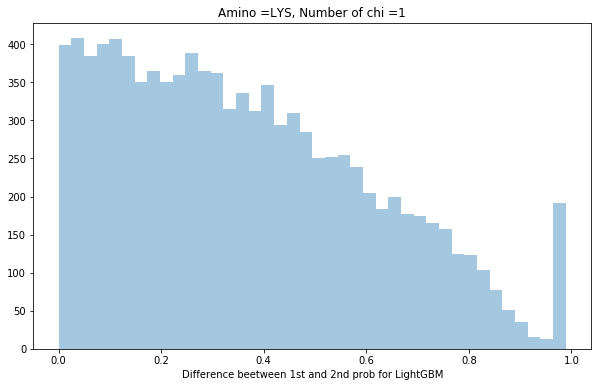

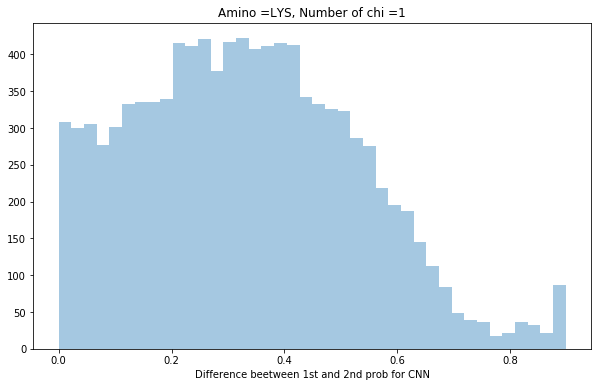

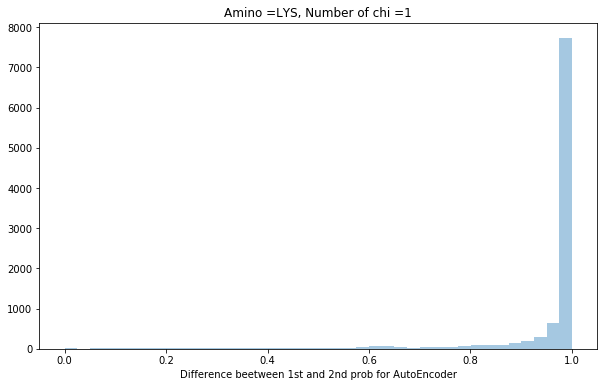

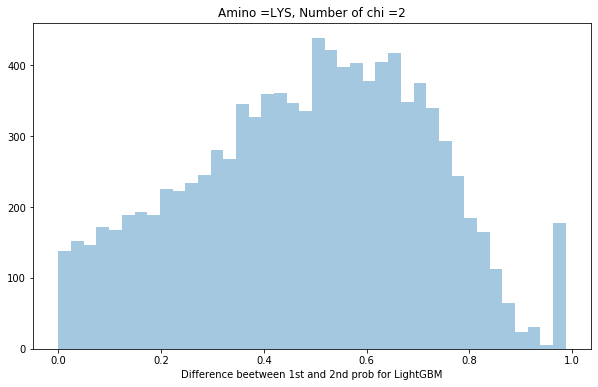

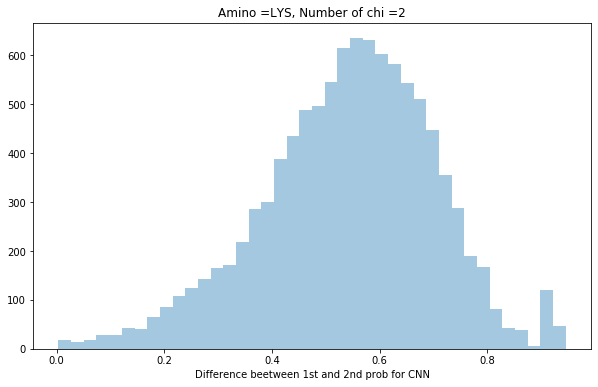

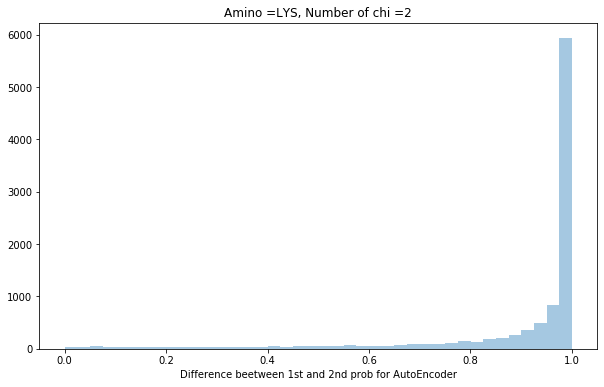

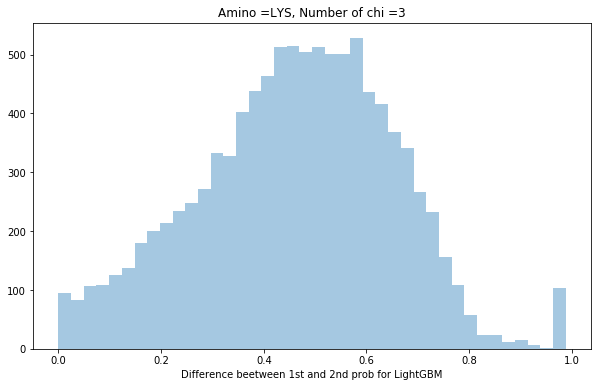

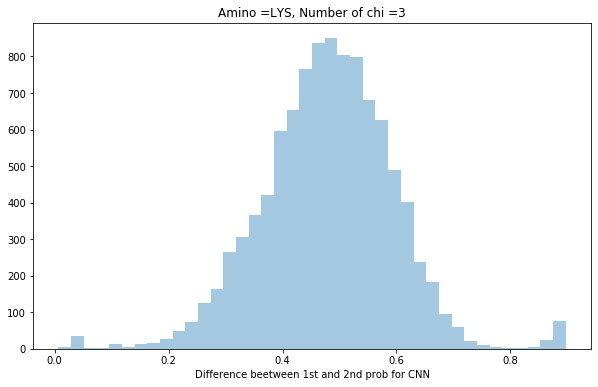

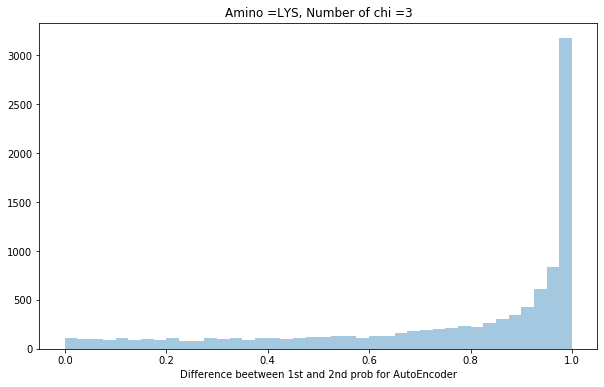

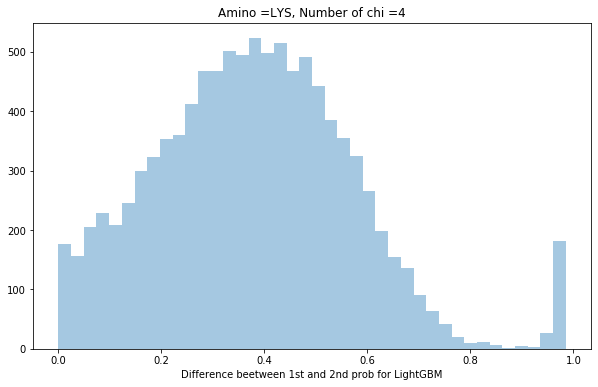

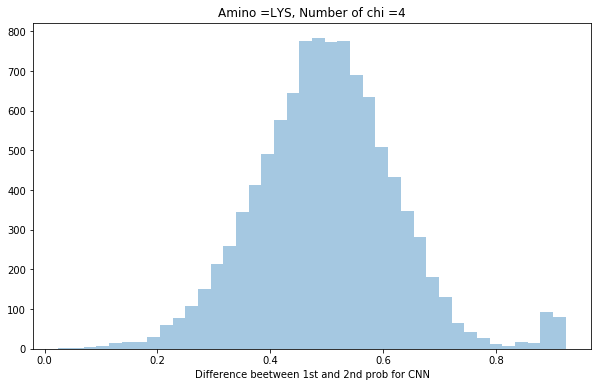

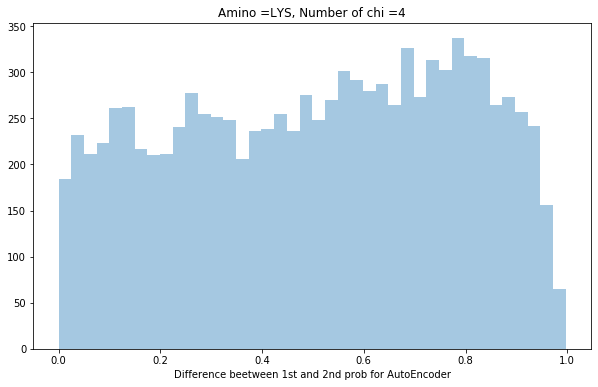

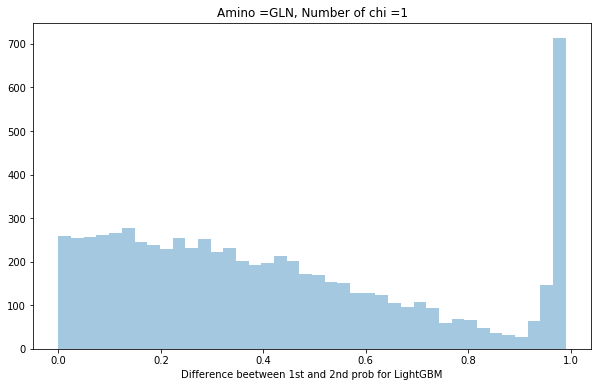

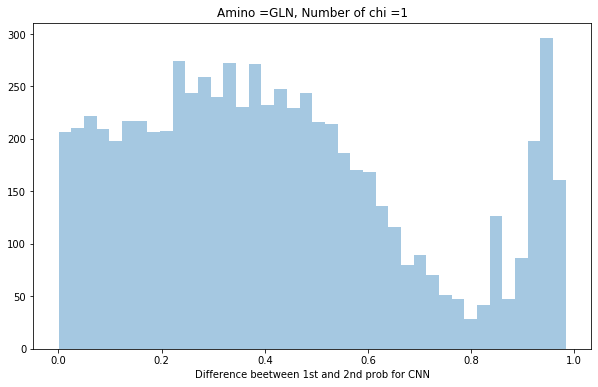

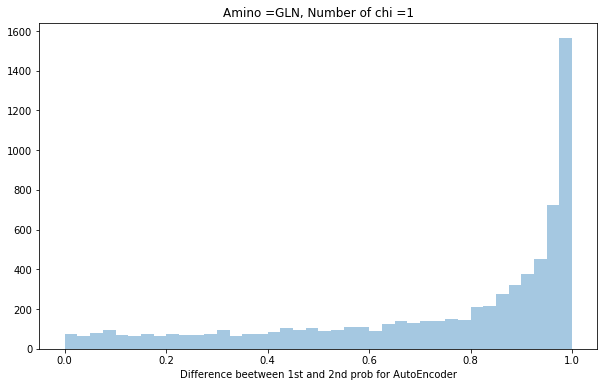

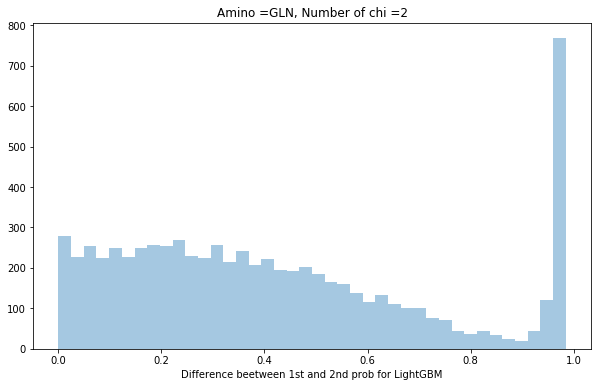

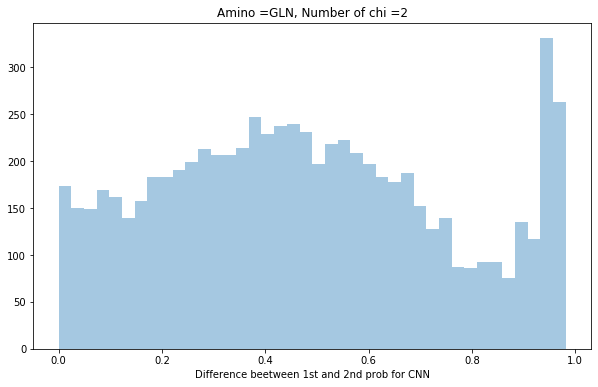

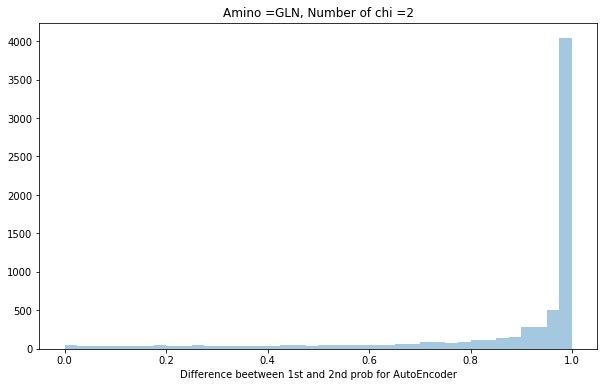

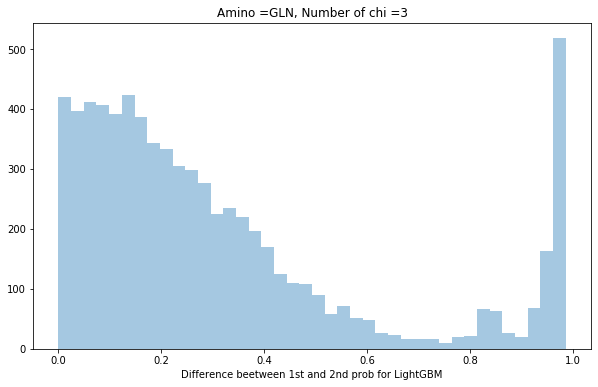

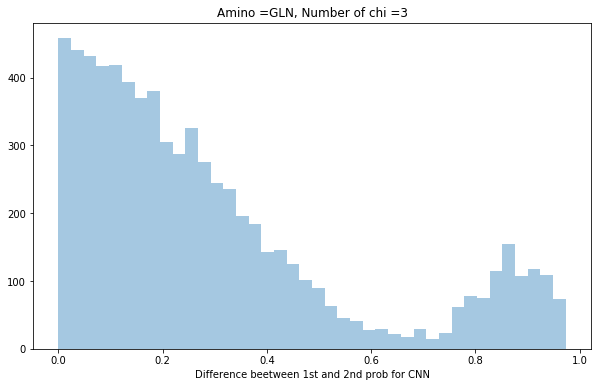

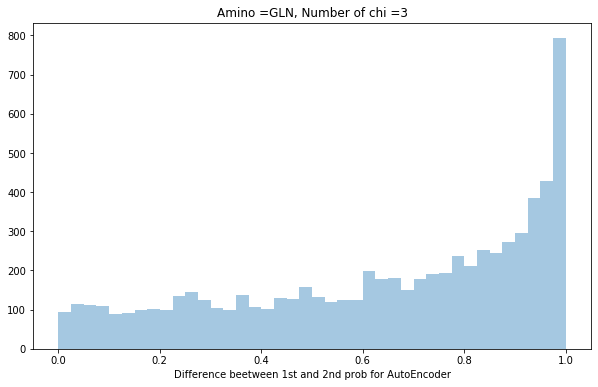

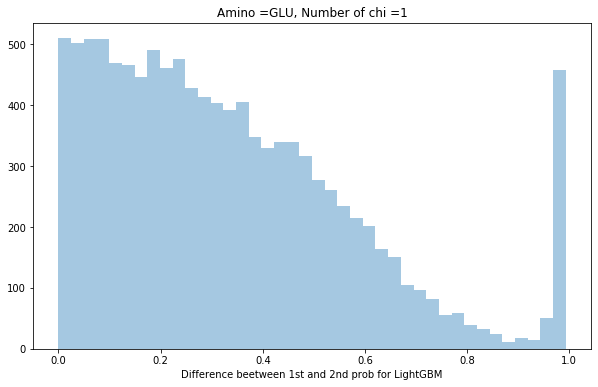

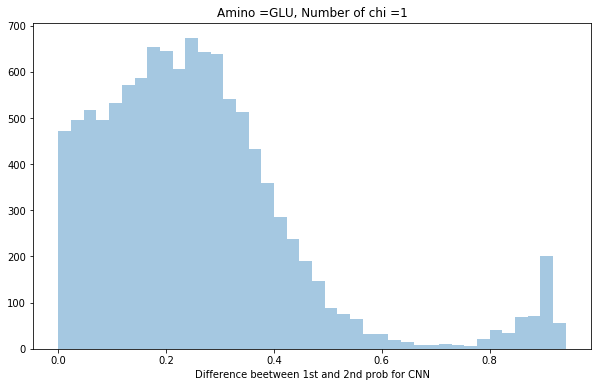

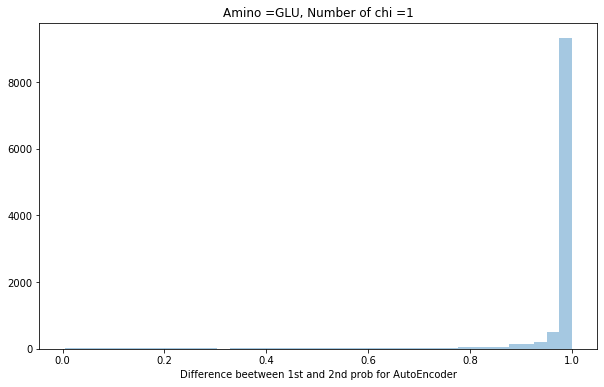

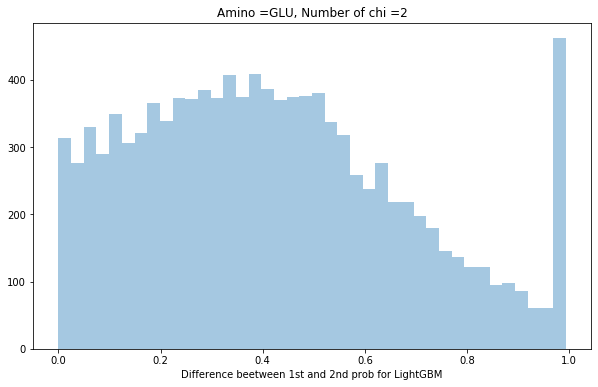

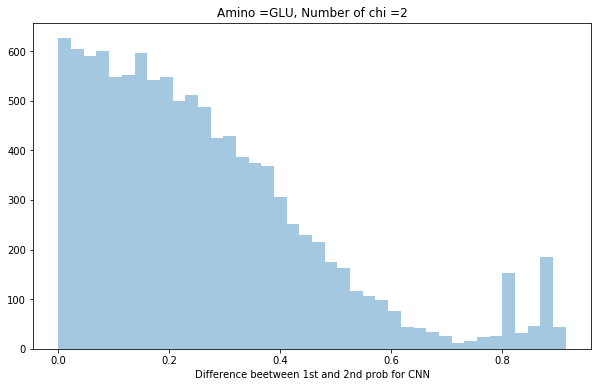

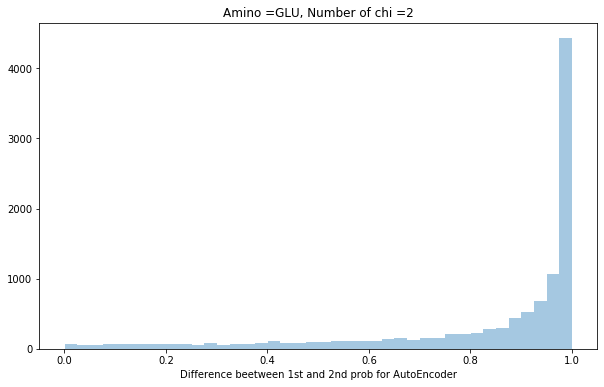

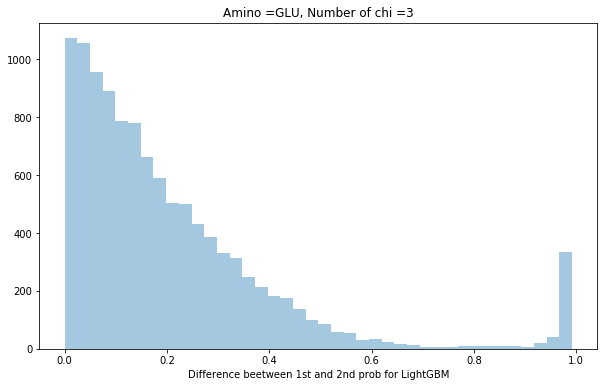

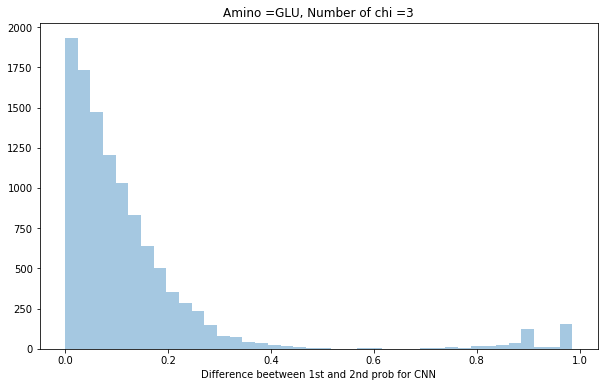

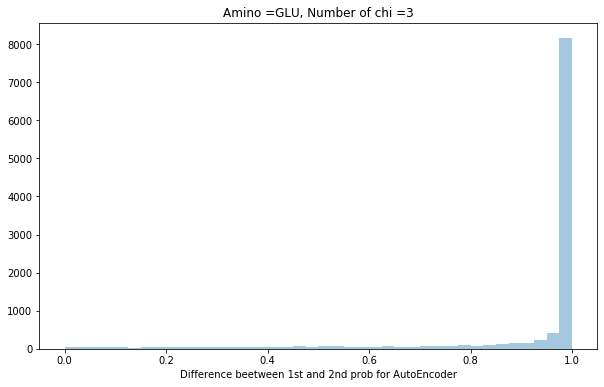

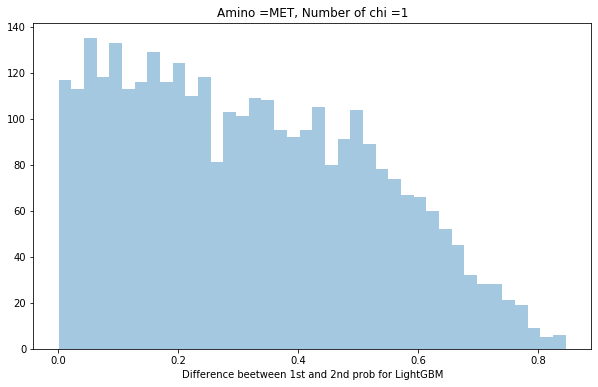

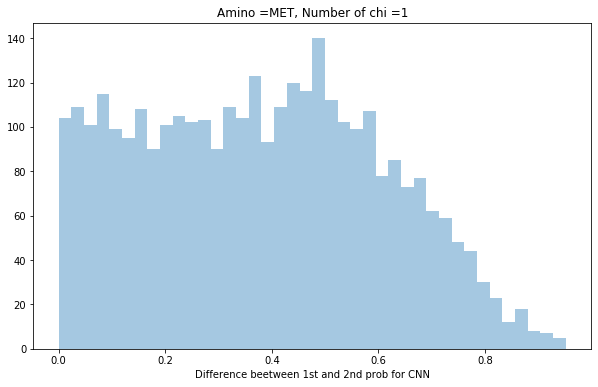

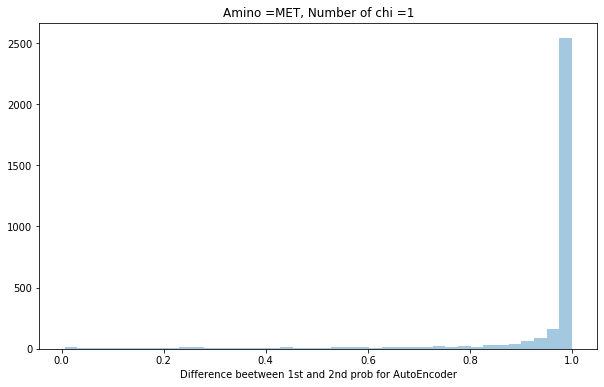

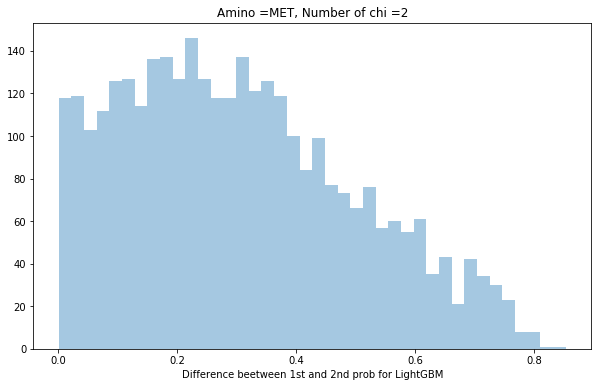

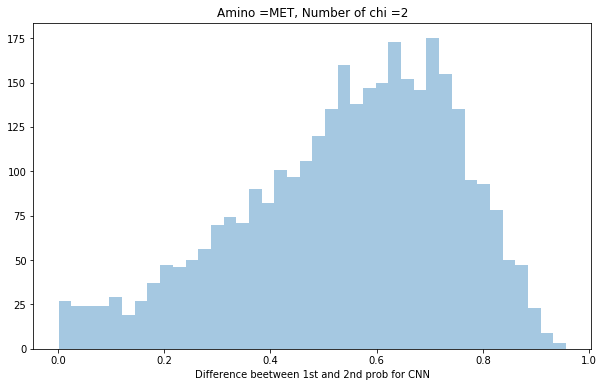

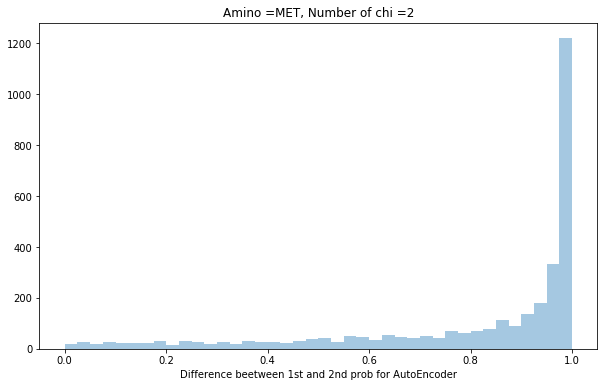

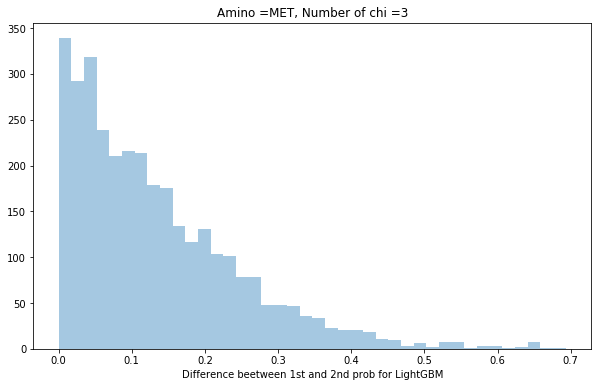

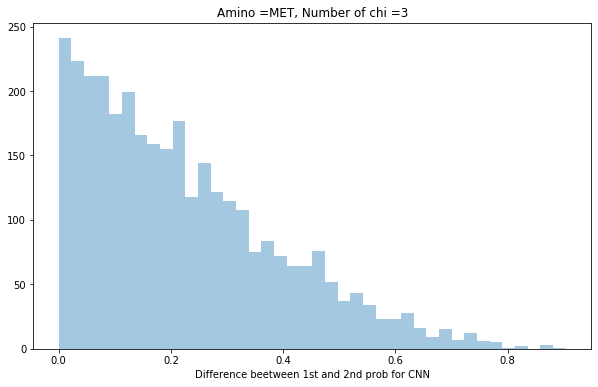

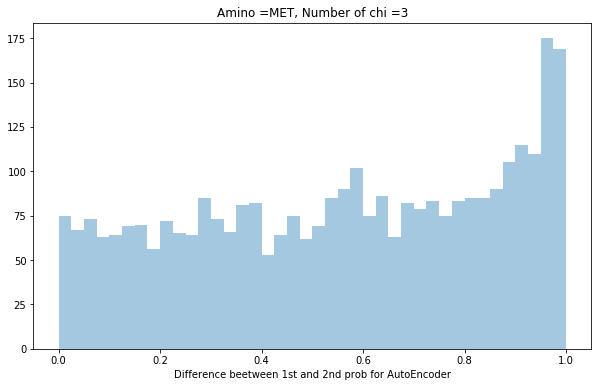

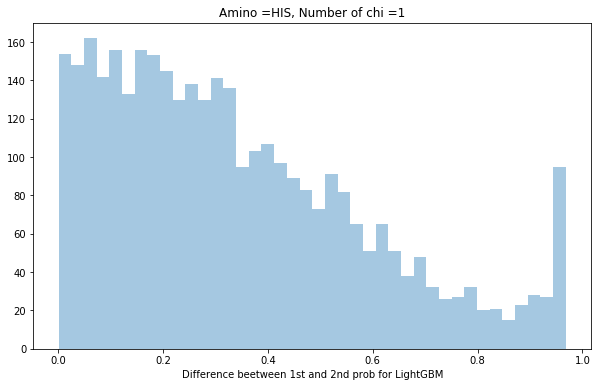

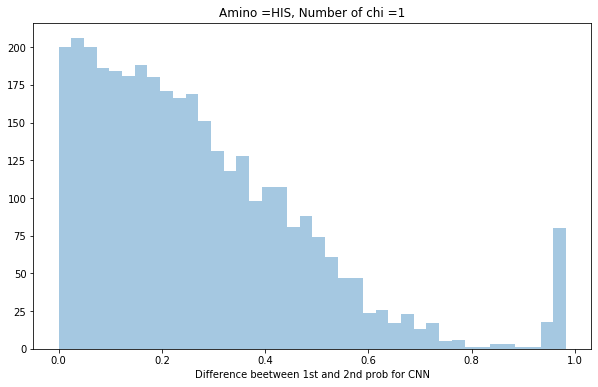

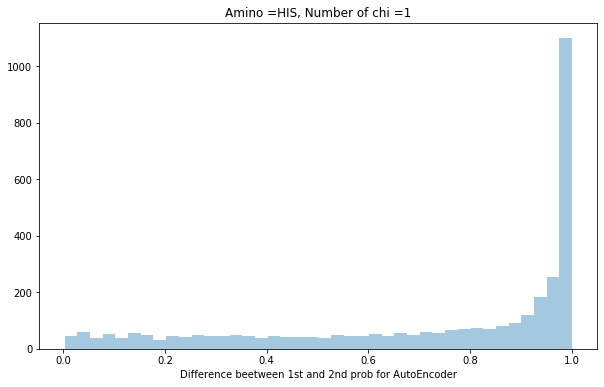

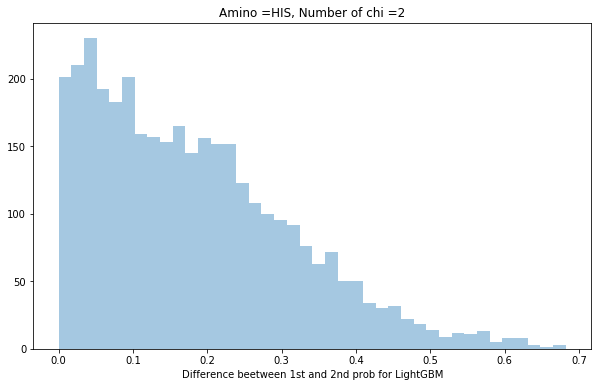

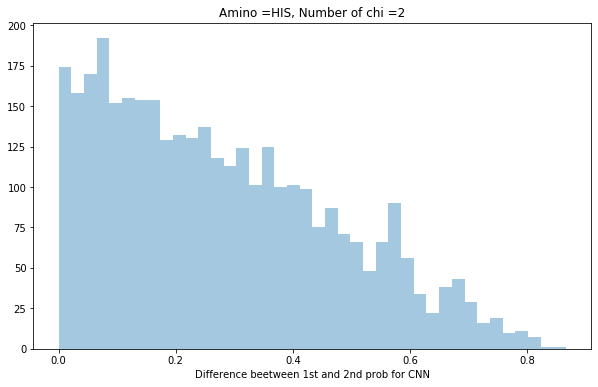

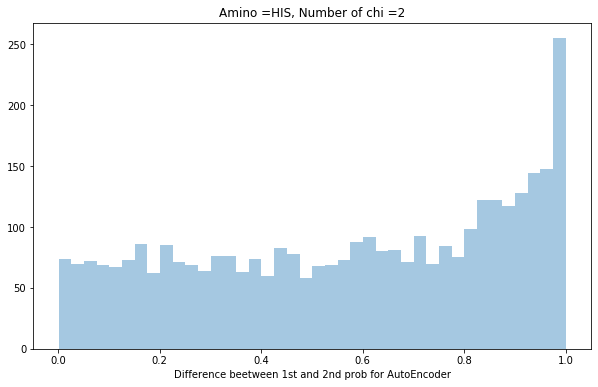

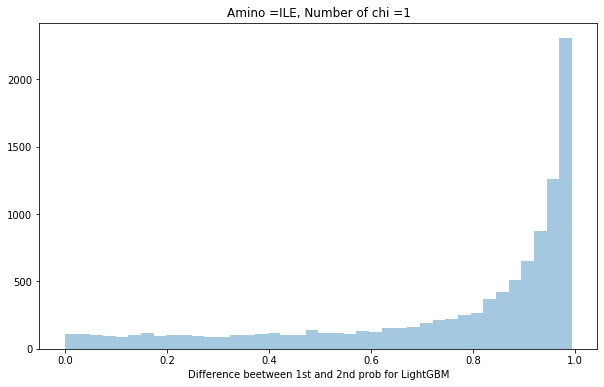

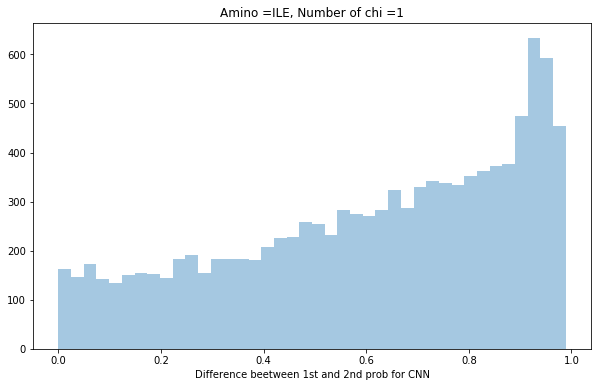

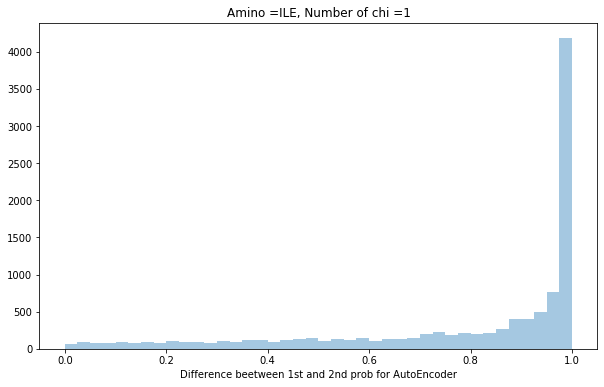

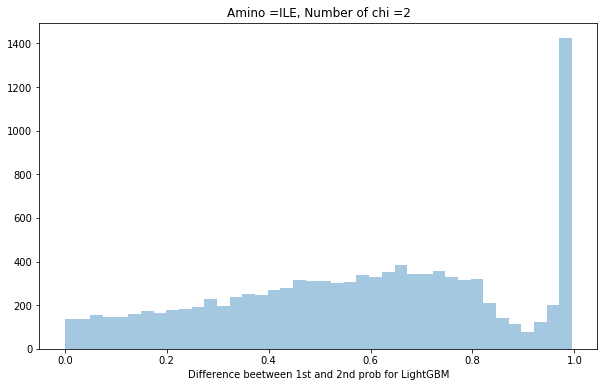

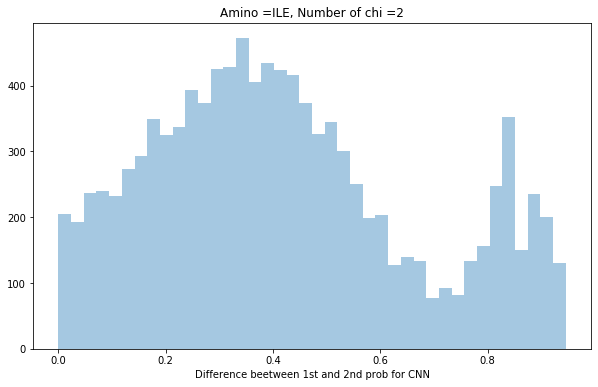

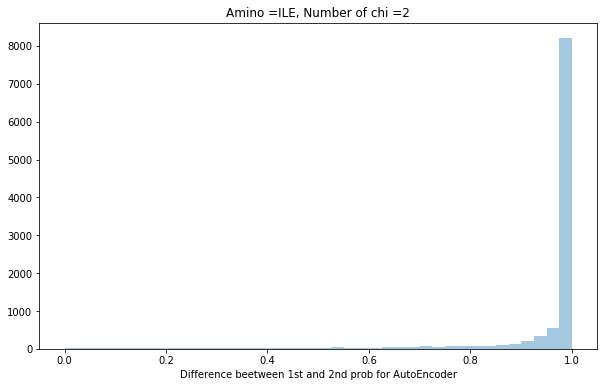

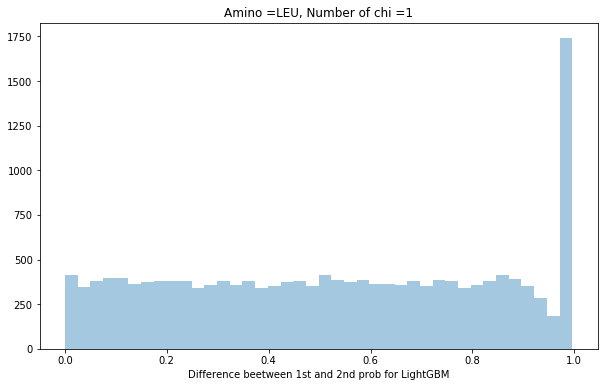

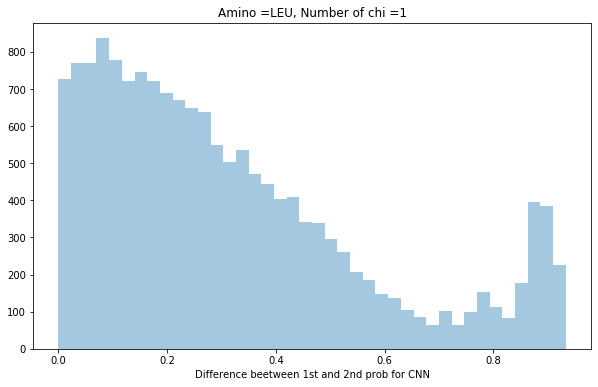

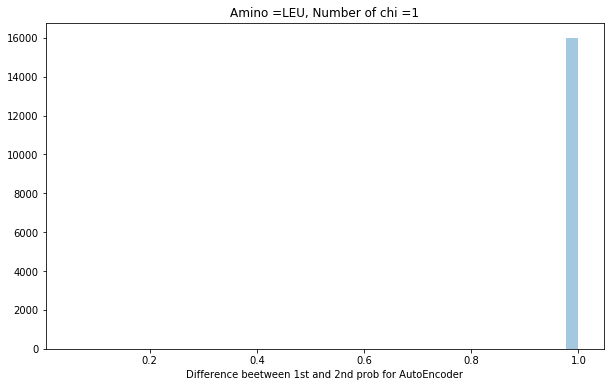

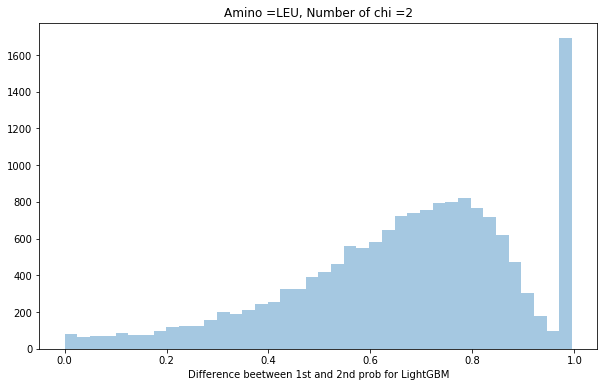

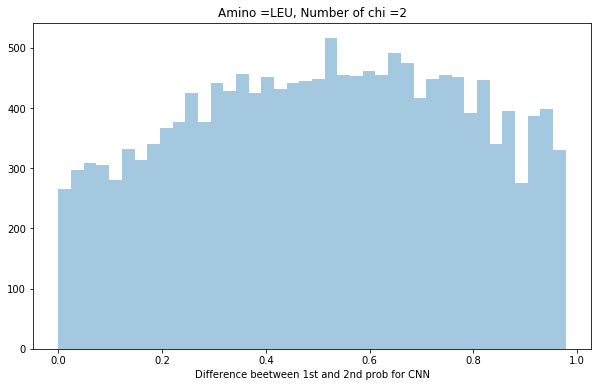

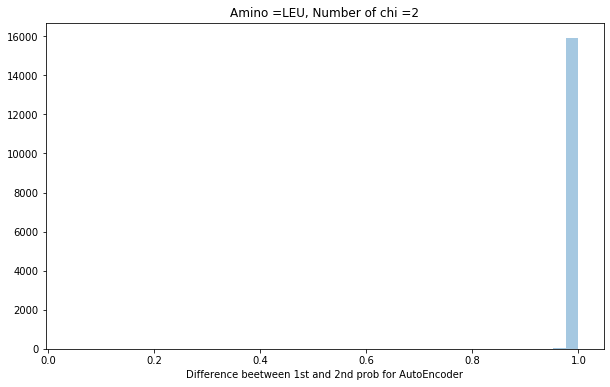

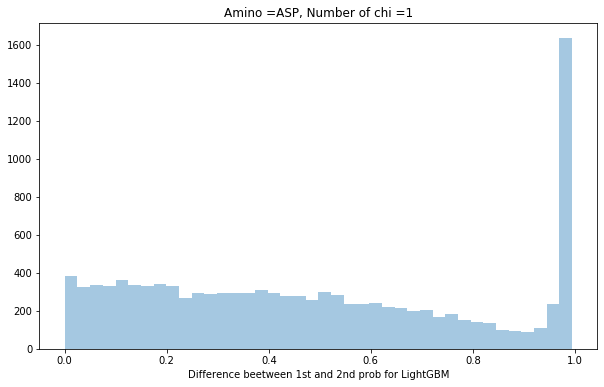

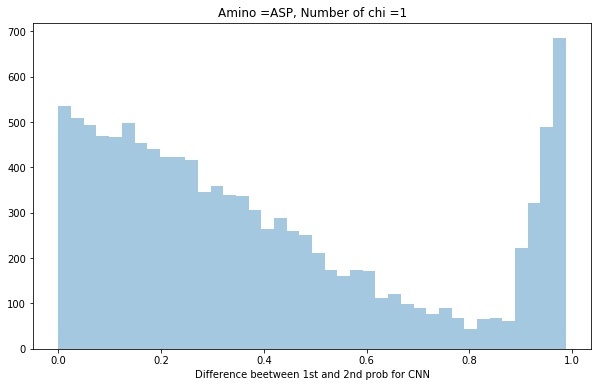

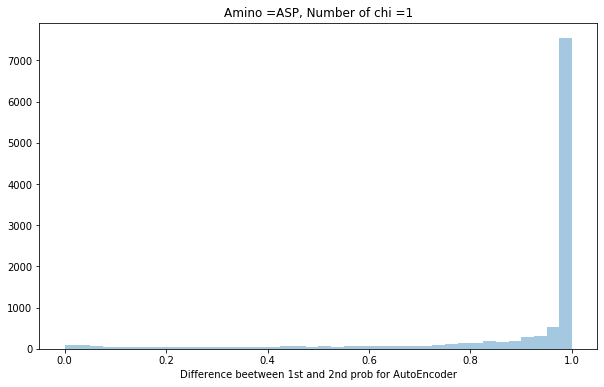

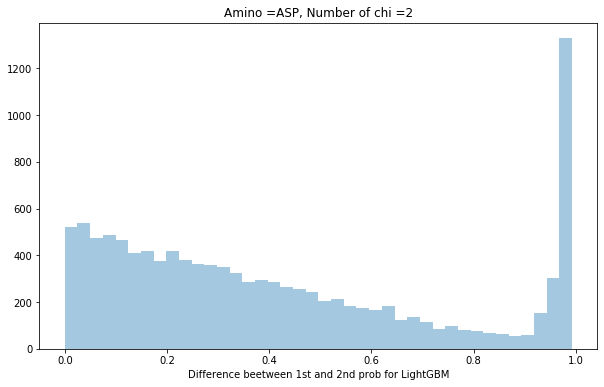

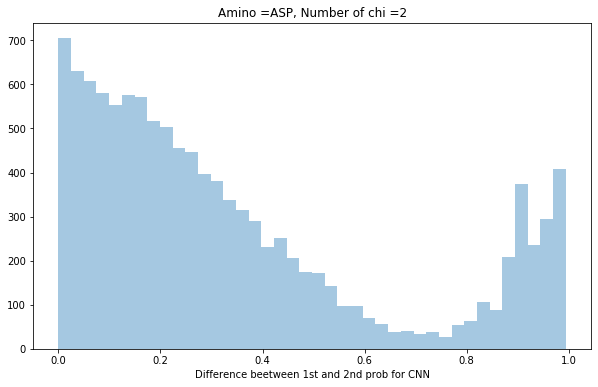

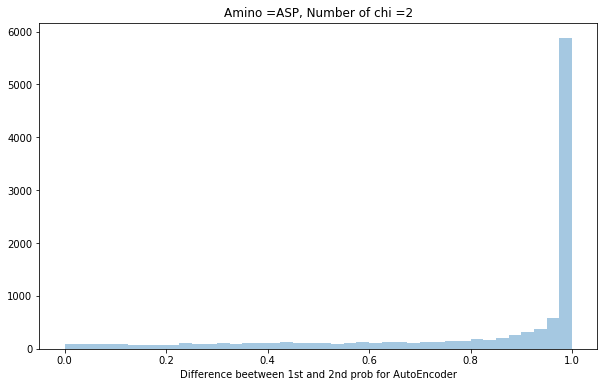

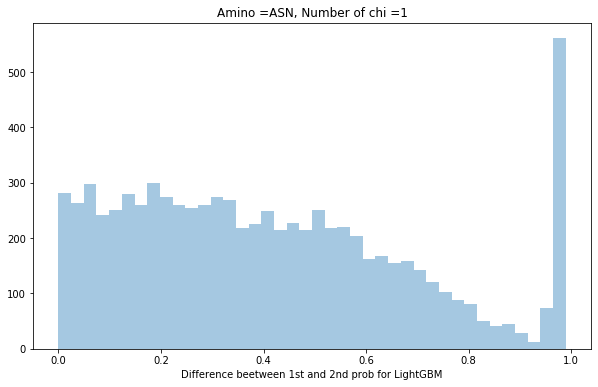

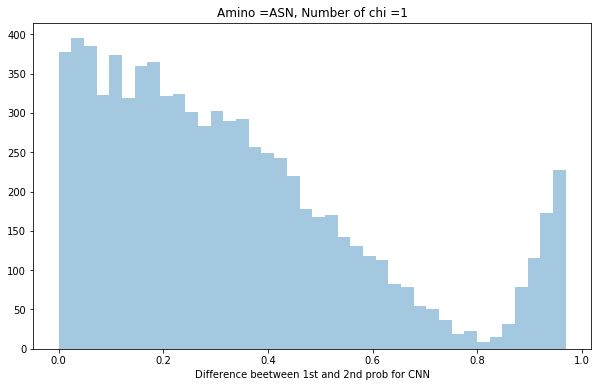

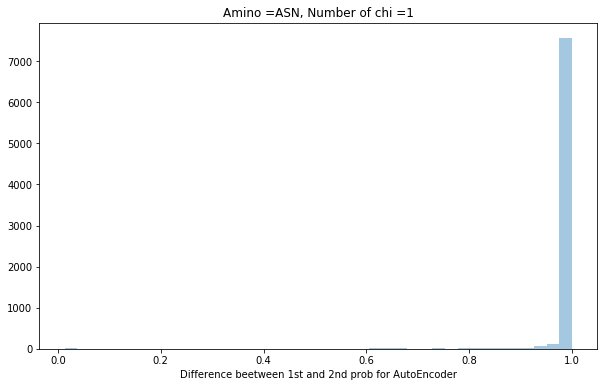

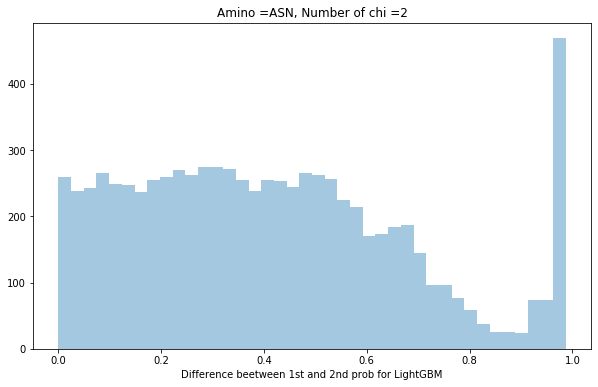

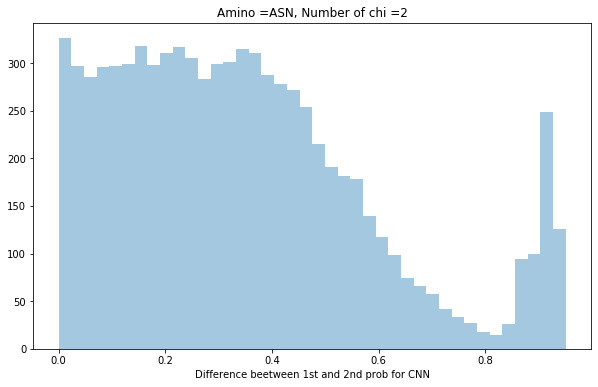

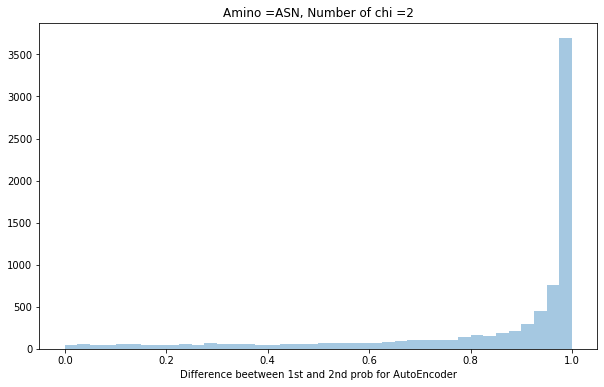

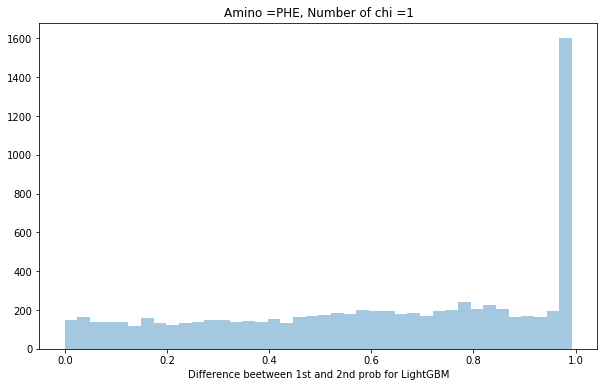

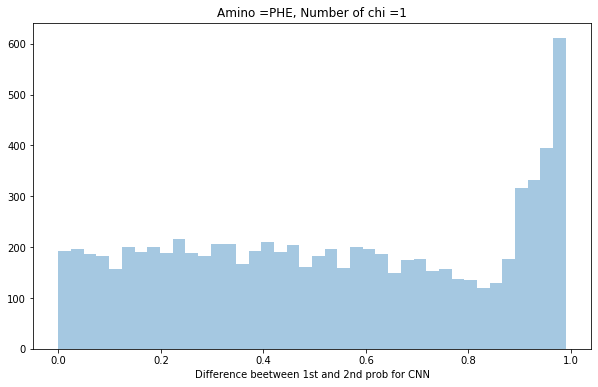

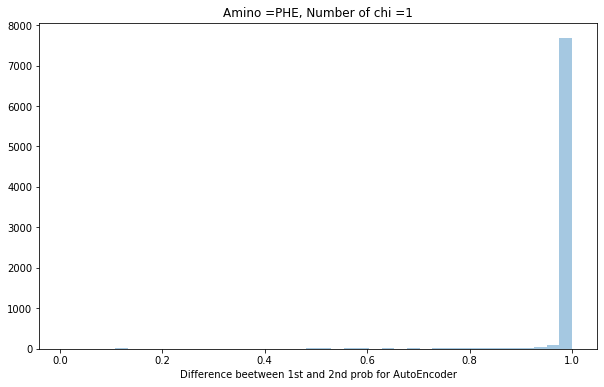

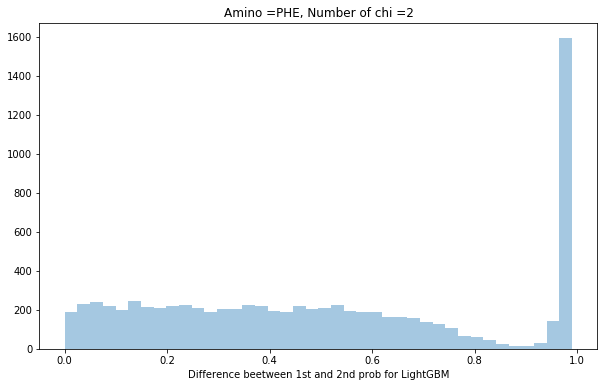

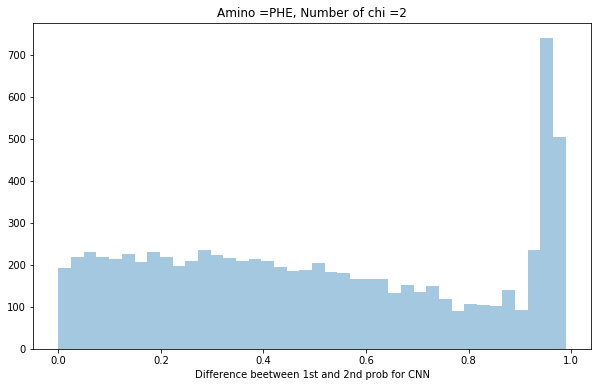

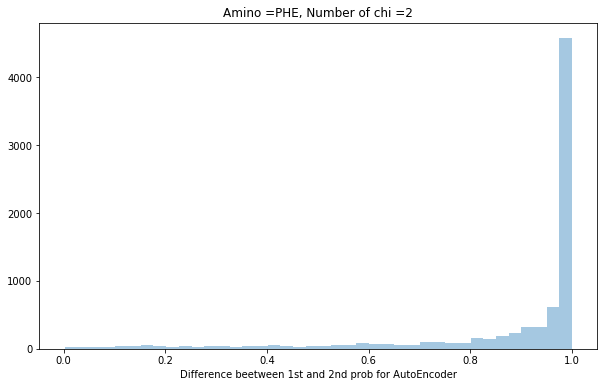

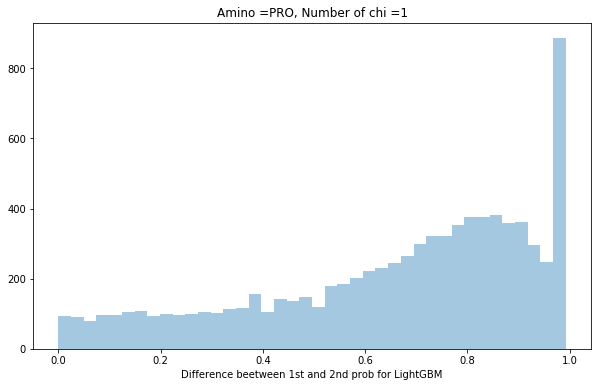

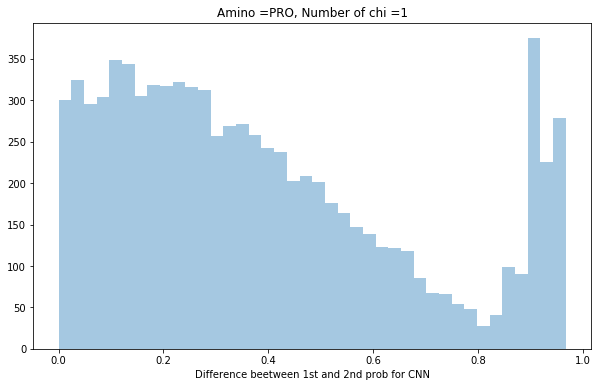

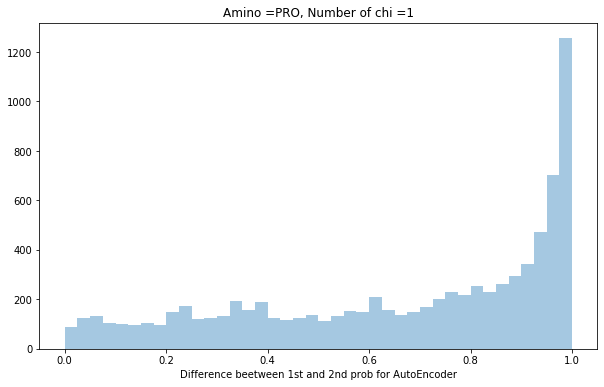

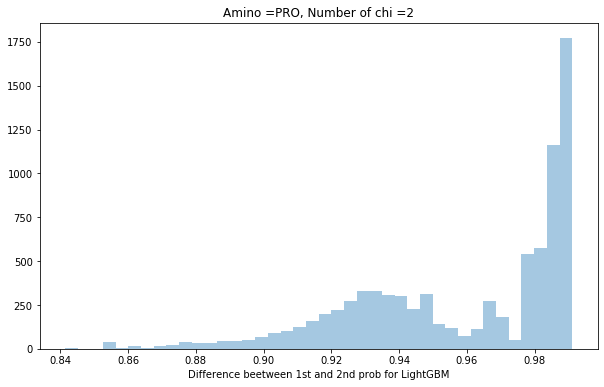

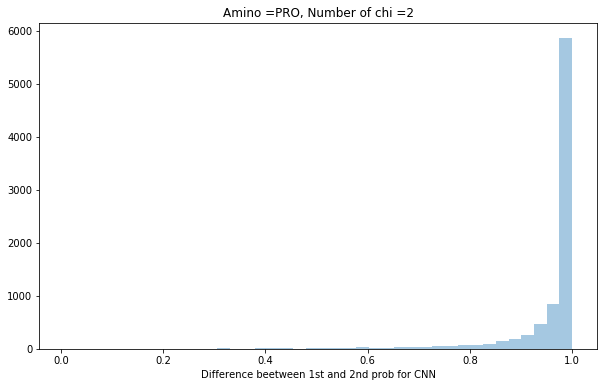

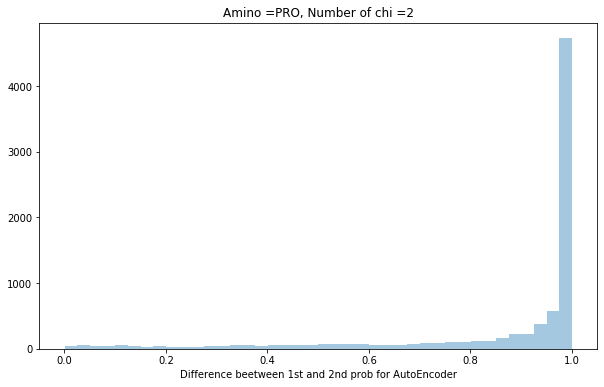

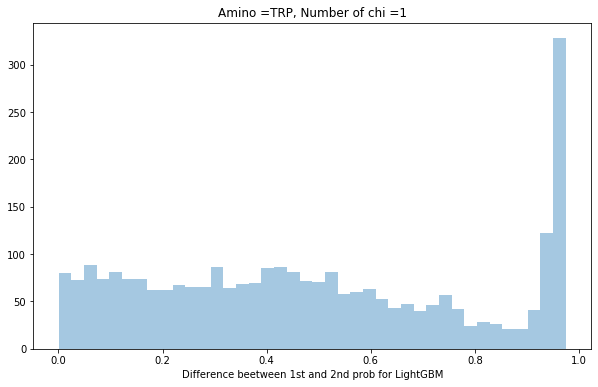

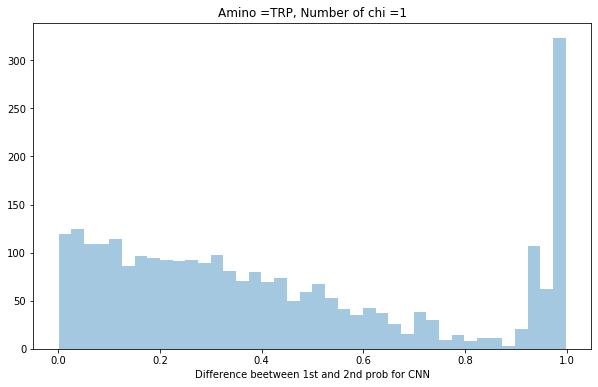

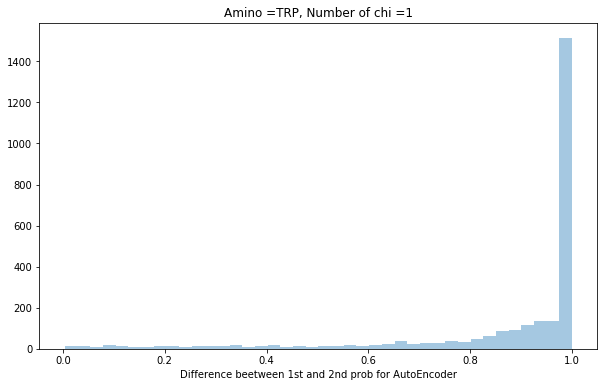

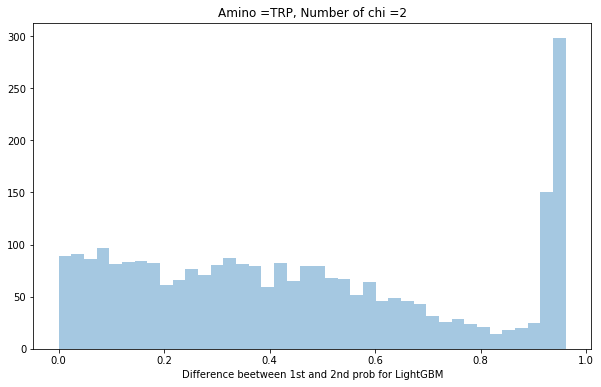

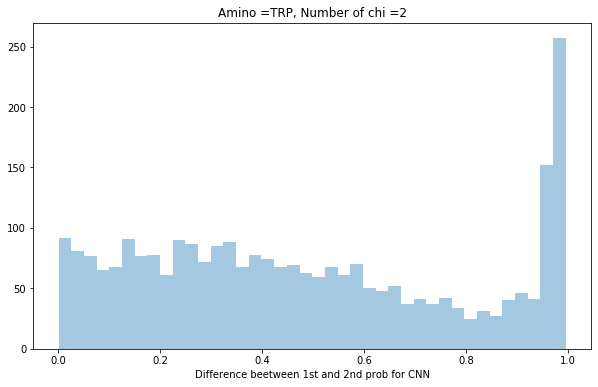

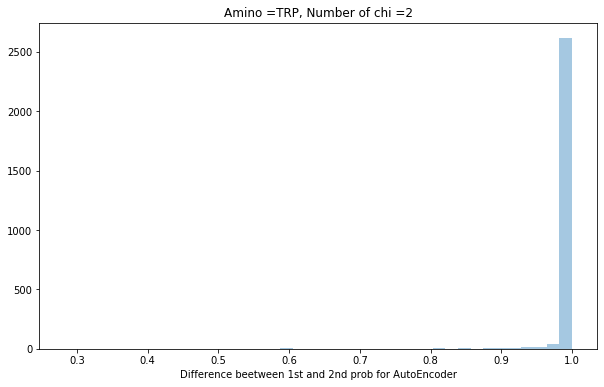

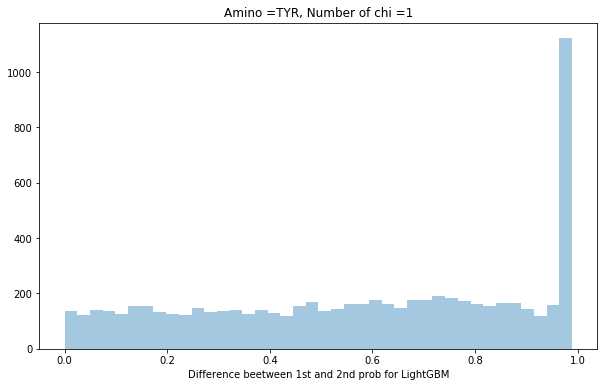

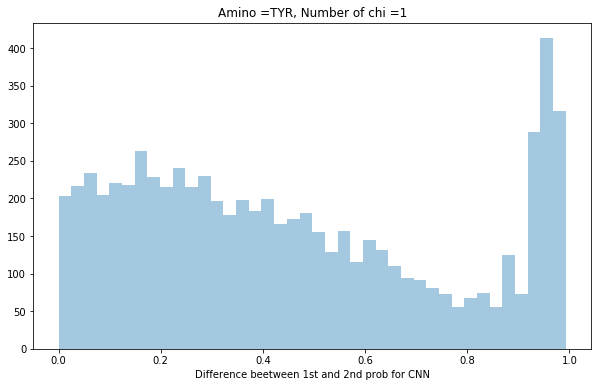

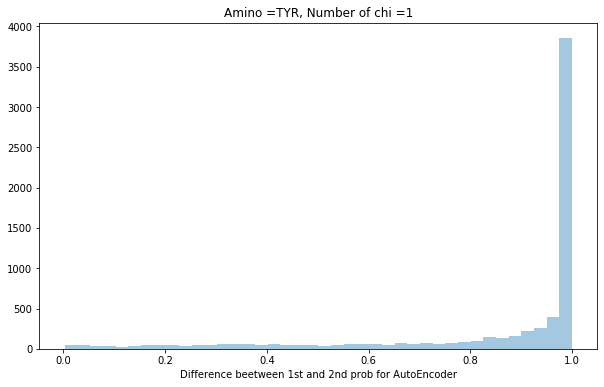

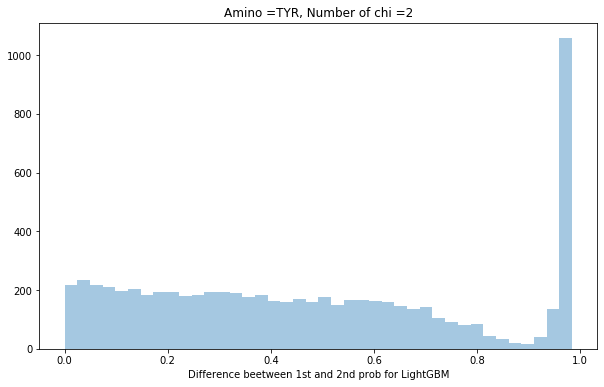

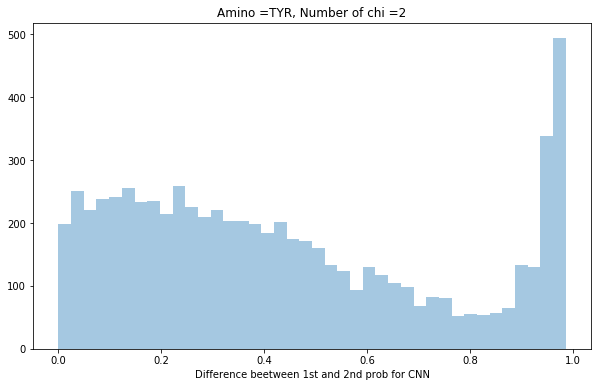

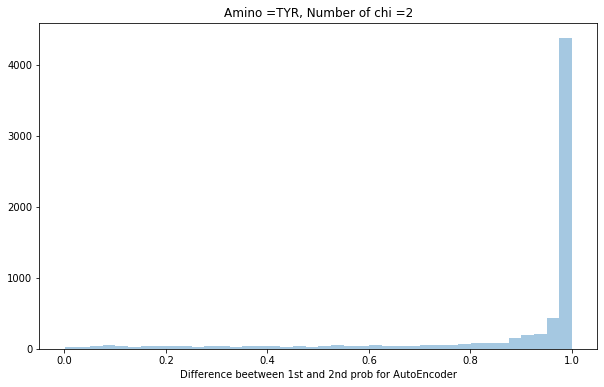

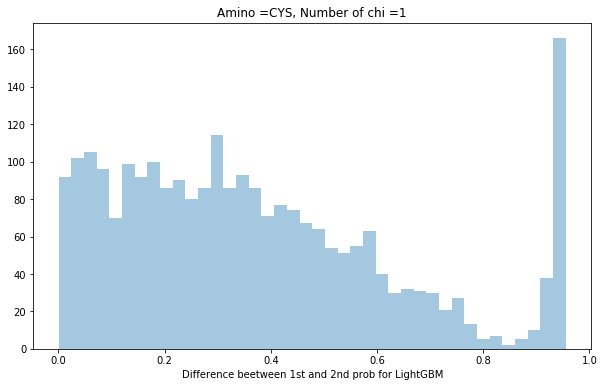

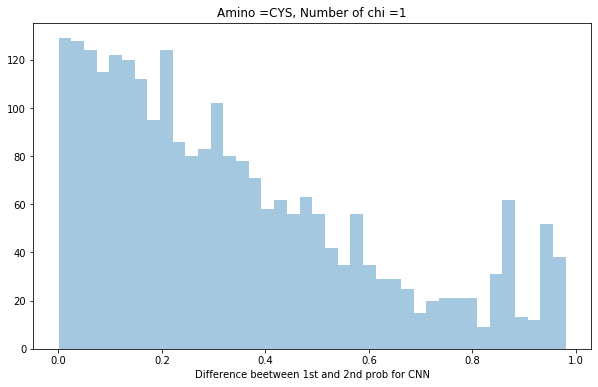

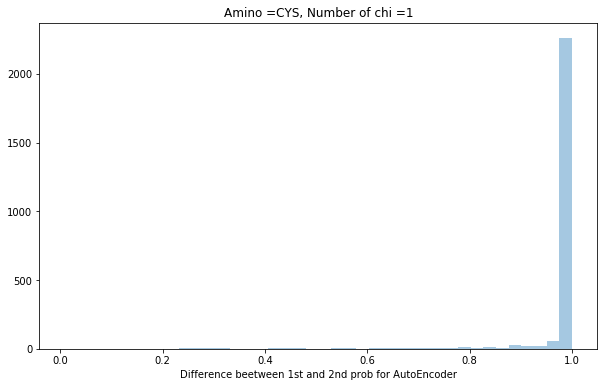

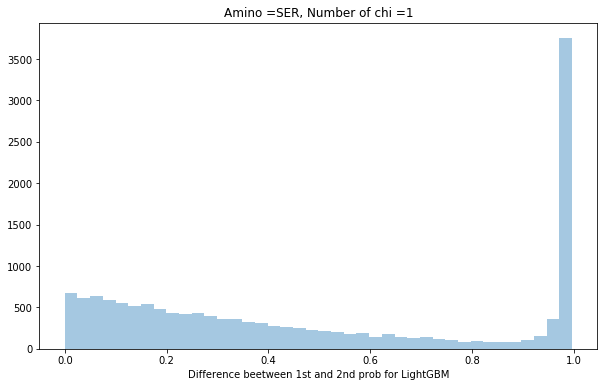

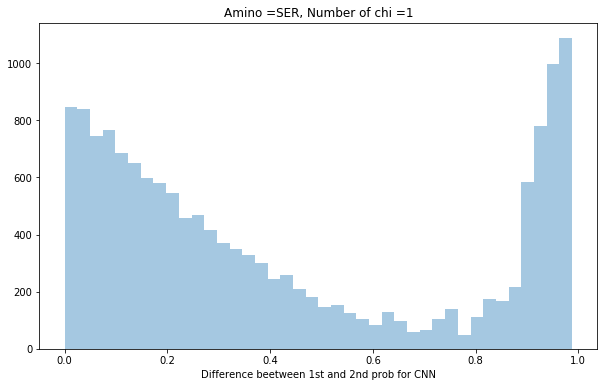

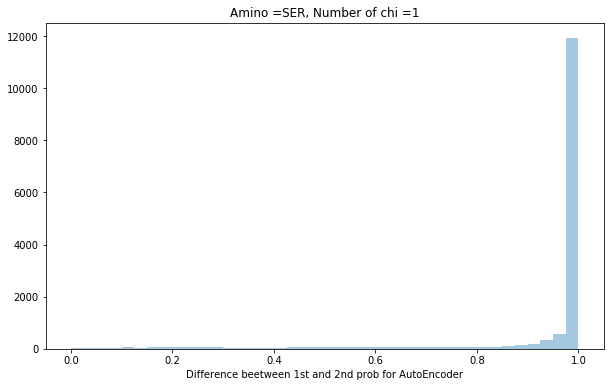

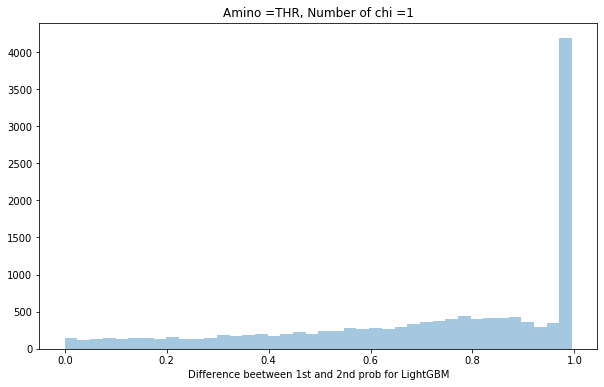

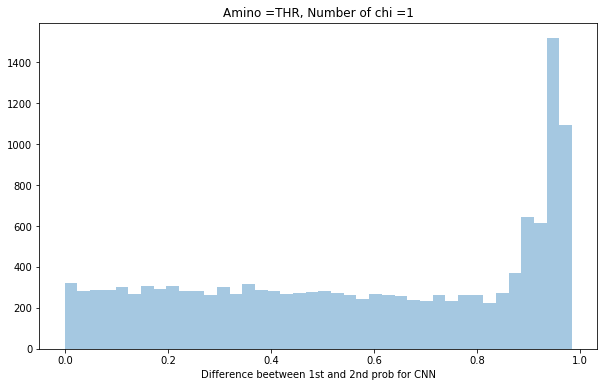

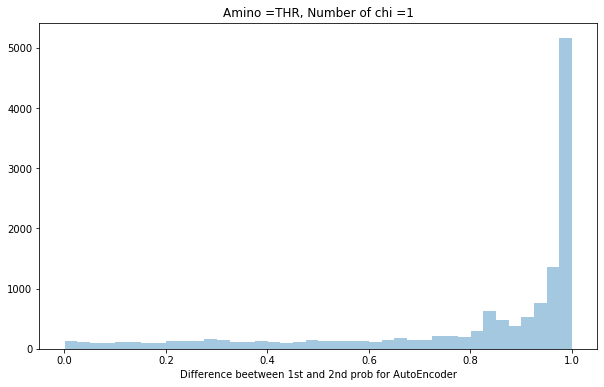

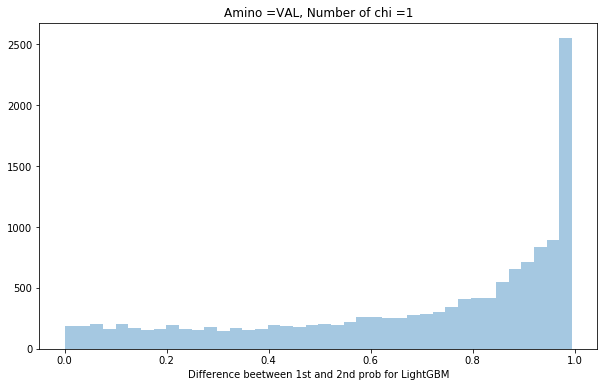

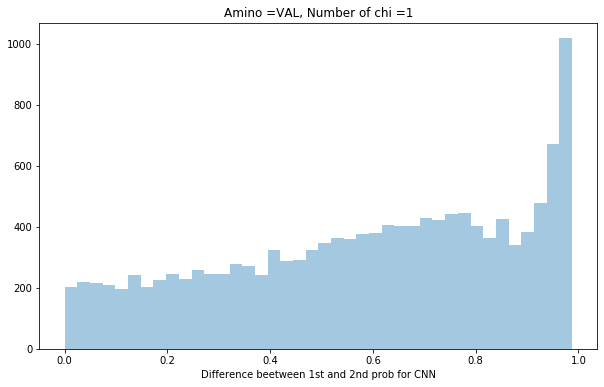

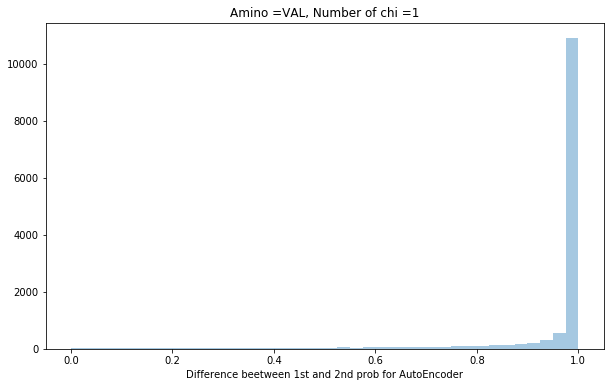

In [290]:
for amino in amino_arr:
    train_data = pd.read_csv(amino + '_train_data.csv')
    count = 0
    cols = train_data.columns.tolist()
    
    for i in range(len(cols)):
        words = cols[i].split('_')
        if ('chi' in words):
            count += 1
    for chi in range(count):
        df = pd.read_csv(amino + 'probas_chi_' + str(chi + 1) + '.csv')
        cols = df.columns
        if cols.size == 13:
            L_arr = np.sort(np.asarray([df['L_1'].to_numpy(), df['L_2'].to_numpy(), df['L_3'].to_numpy(), df['L_4'].to_numpy()]).T, axis=1).T
            C_arr = np.sort(np.asarray([df['C_1'].to_numpy(), df['C_2'].to_numpy(), df['C_3'].to_numpy(), df['C_4'].to_numpy()]).T, axis=1).T
            A_arr = np.sort(np.asarray([df['A_1'].to_numpy(), df['A_2'].to_numpy(), df['A_3'].to_numpy(), df['A_4'].to_numpy()]).T, axis=1).T
            L_arr_diff = L_arr[3] - L_arr[2]
            C_arr_diff = C_arr[3] - C_arr[2]
            A_arr_diff = A_arr[3] - A_arr[2]
            plt.figure(figsize=(10, 6))
            sns.distplot(L_arr_diff, kde=False, bins=40)
            plt.xlabel('Difference beetween 1st and 2nd prob for LightGBM')
            plt.title('Amino =' + amino + ', Number of chi =' + str(chi + 1))
            plt.figure(figsize=(10, 6))
            sns.distplot(C_arr_diff, kde=False, bins=40)
            plt.xlabel('Difference beetween 1st and 2nd prob for CNN')
            plt.title('Amino =' + amino + ', Number of chi =' + str(chi + 1))
            plt.figure(figsize=(10, 6))
            sns.distplot(A_arr_diff, kde=False, bins=40)
            plt.xlabel('Difference beetween 1st and 2nd prob for AutoEncoder')
            plt.title('Amino =' + amino + ', Number of chi =' + str(chi + 1))
        if cols.size == 10:
            L_arr = np.sort(np.asarray([df['L_1'].to_numpy(), df['L_2'].to_numpy(), df['L_3'].to_numpy()]).T, axis=1).T
            C_arr = np.sort(np.asarray([df['C_1'].to_numpy(), df['C_2'].to_numpy(), df['C_3'].to_numpy()]).T, axis=1).T
            A_arr = np.sort(np.asarray([df['A_1'].to_numpy(), df['A_2'].to_numpy(), df['A_3'].to_numpy()]).T, axis=1).T
            L_arr_diff = L_arr[2] - L_arr[1]
            C_arr_diff = C_arr[2] - C_arr[1]
            A_arr_diff = A_arr[2] - A_arr[1]
            plt.figure(figsize=(10, 6))
            sns.distplot(L_arr_diff, kde=False, bins=40)
            plt.xlabel('Difference beetween 1st and 2nd prob for LightGBM')
            plt.title('Amino =' + amino + ', Number of chi =' + str(chi + 1))
            plt.figure(figsize=(10, 6))
            sns.distplot(C_arr_diff, kde=False, bins=40)
            plt.xlabel('Difference beetween 1st and 2nd prob for CNN')
            plt.title('Amino =' + amino + ', Number of chi =' + str(chi + 1))
            plt.figure(figsize=(10, 6))
            sns.distplot(A_arr_diff, kde=False, bins=40)
            plt.xlabel('Difference beetween 1st and 2nd prob for AutoEncoder')
            plt.title('Amino =' + amino + ', Number of chi =' + str(chi + 1))

        if cols.size == 7:
            L_arr = np.sort(np.asarray([df['L_1'].to_numpy(), df['L_2'].to_numpy()]).T, axis=1).T
            C_arr = np.sort(np.asarray([df['C_1'].to_numpy(), df['C_2'].to_numpy()]).T, axis=1).T
            A_arr = np.sort(np.asarray([df['A_1'].to_numpy(), df['A_2'].to_numpy()]).T, axis=1).T
            L_arr_diff = L_arr[1] - L_arr[0]
            C_arr_diff = C_arr[1] - C_arr[0]
            A_arr_diff = A_arr[1] - A_arr[0]
            plt.figure(figsize=(10, 6))
            sns.distplot(L_arr_diff, kde=False, bins=40)
            plt.xlabel('Difference beetween 1st and 2nd prob for LightGBM')
            plt.title('Amino =' + amino + ', Number of chi =' + str(chi + 1))
            plt.figure(figsize=(10, 6))
            sns.distplot(C_arr_diff, kde=False, bins=40)
            plt.xlabel('Difference beetween 1st and 2nd prob for CNN')
            plt.title('Amino =' + amino + ', Number of chi =' + str(chi + 1))
            plt.figure(figsize=(10, 6))
            sns.distplot(A_arr_diff, kde=False, bins=40)
            plt.xlabel('Difference beetween 1st and 2nd prob for AutoEncoder')
            plt.title('Amino =' + amino + ', Number of chi =' + str(chi + 1))

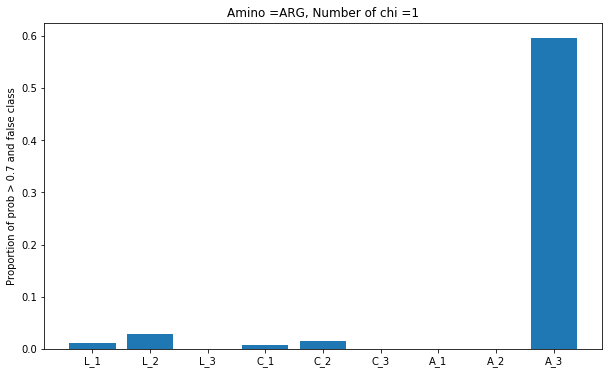

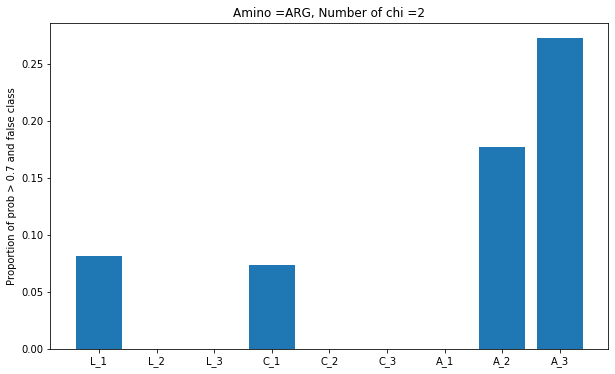

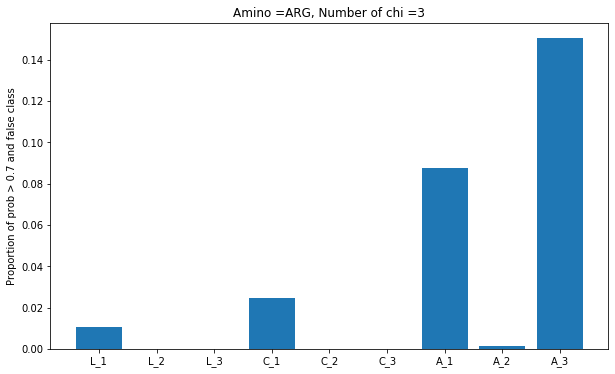

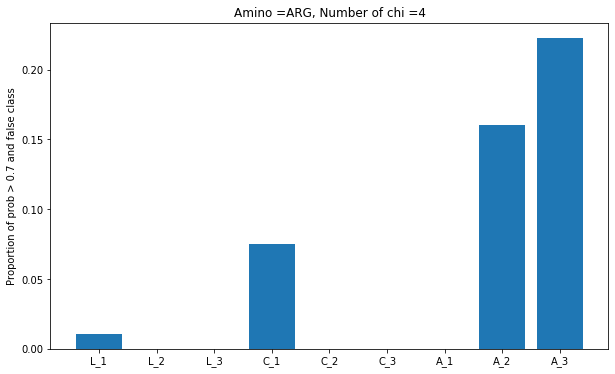

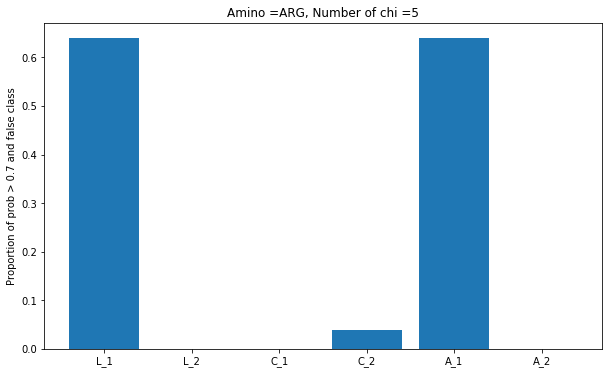

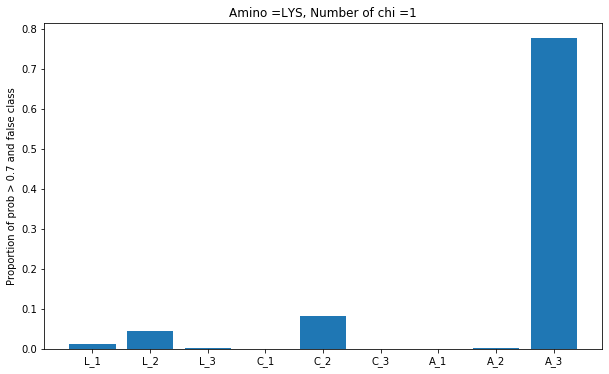

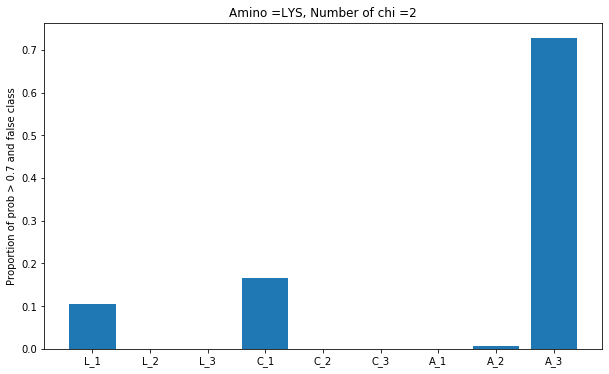

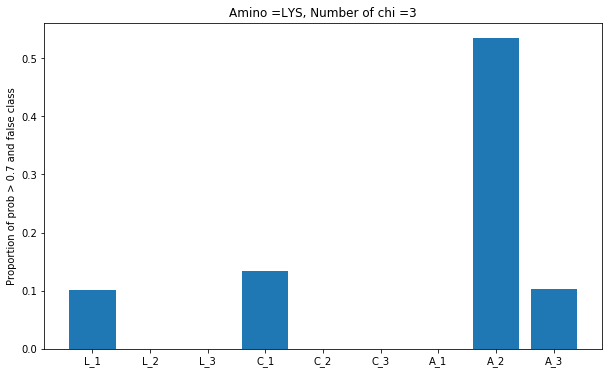

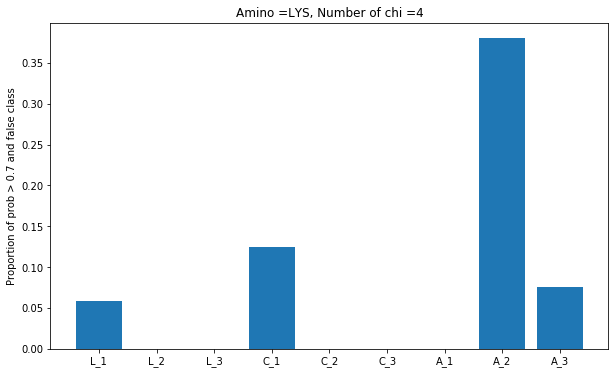

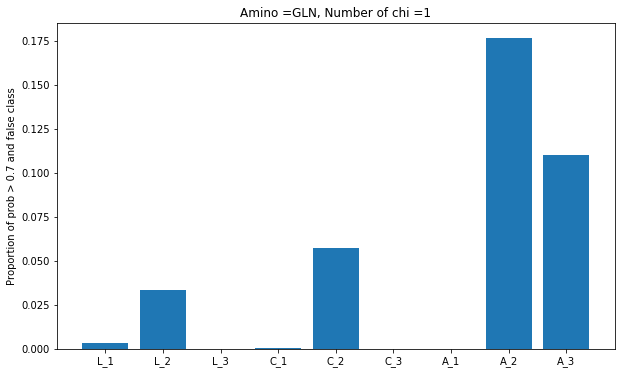

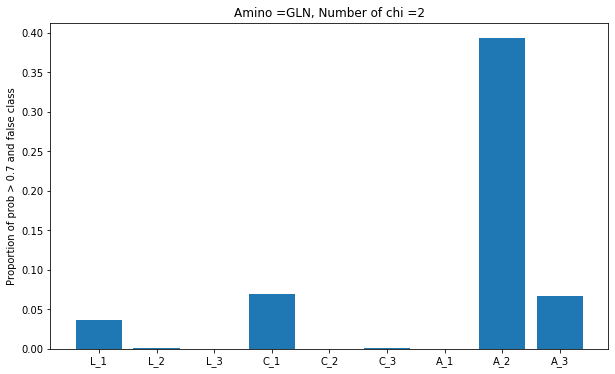

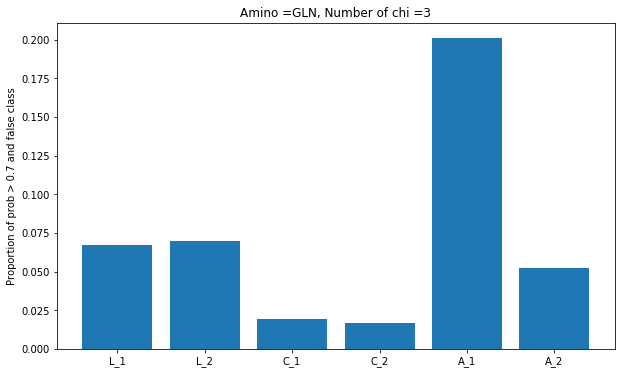

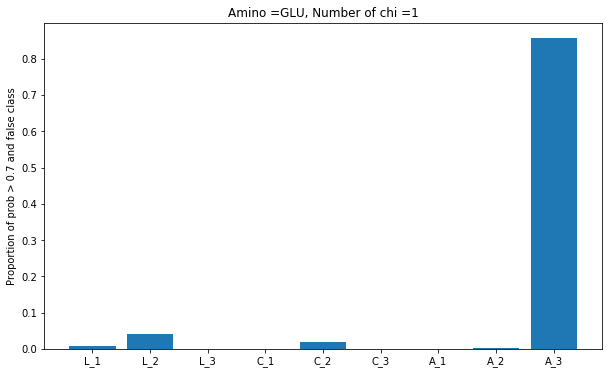

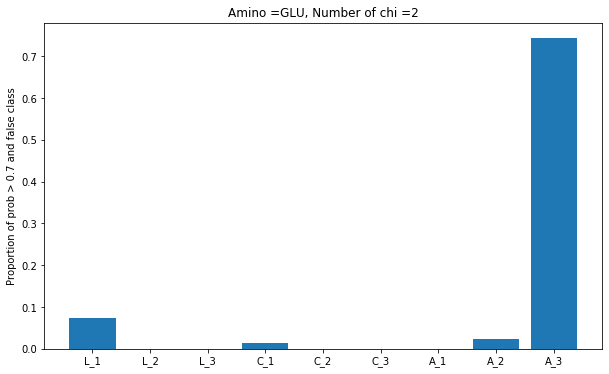

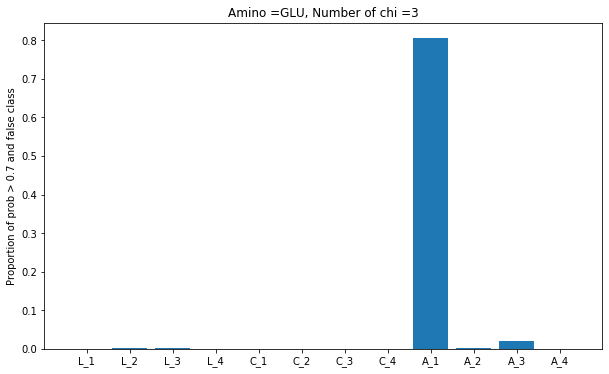

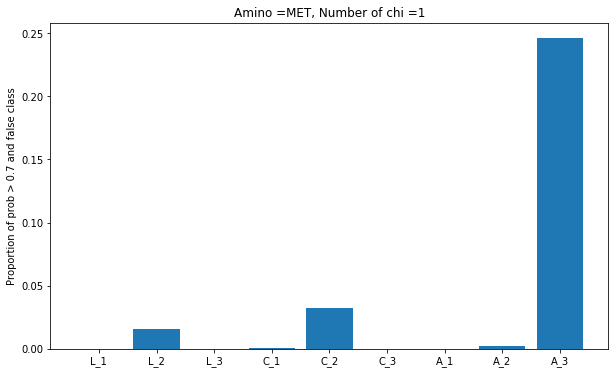

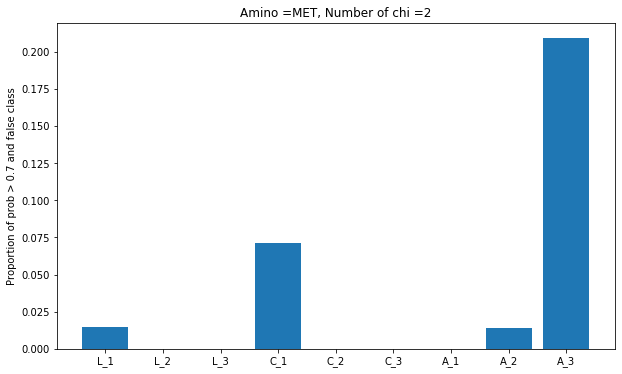

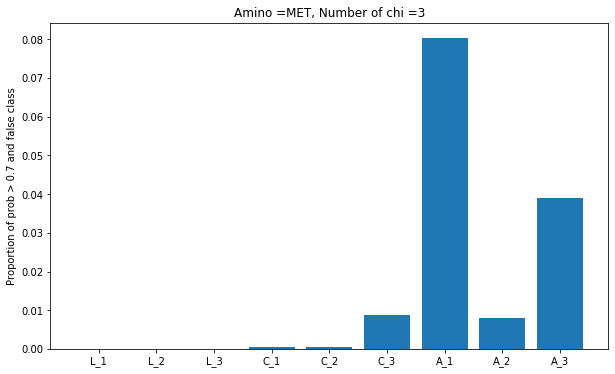

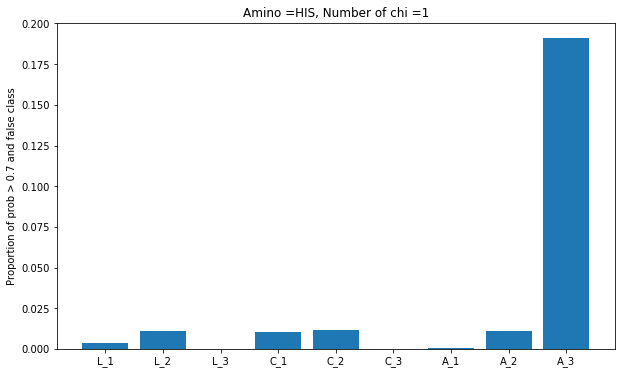

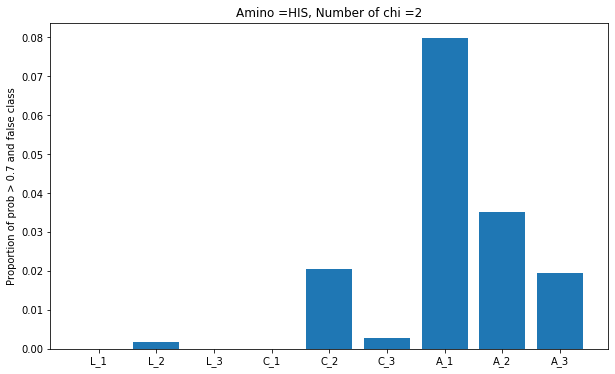

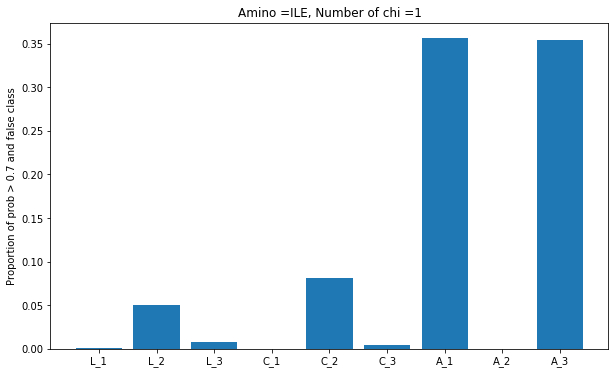

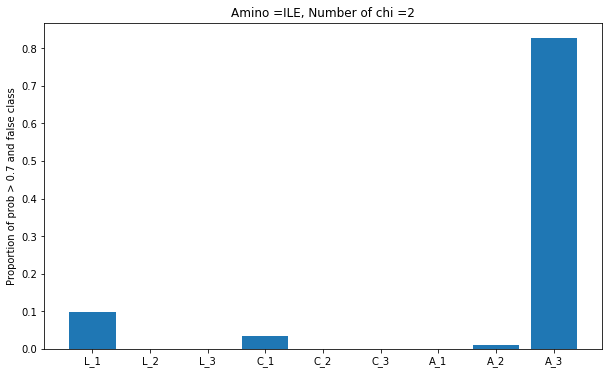

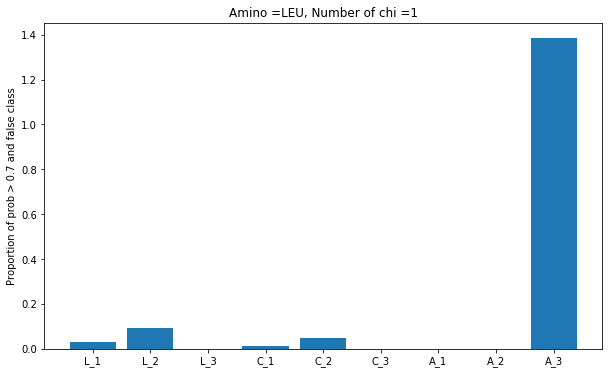

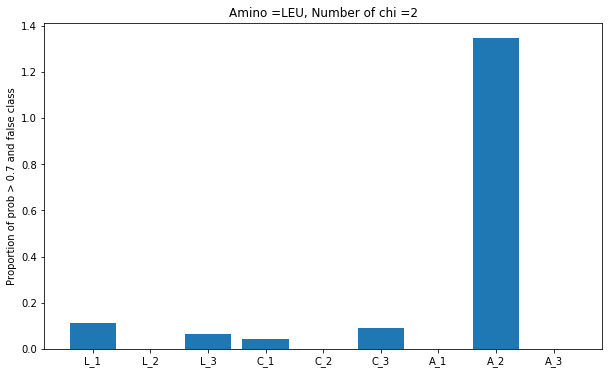

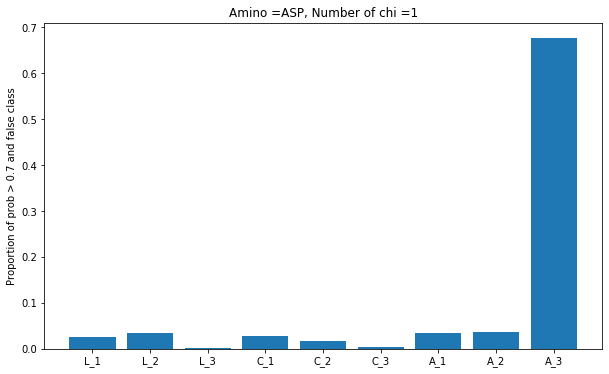

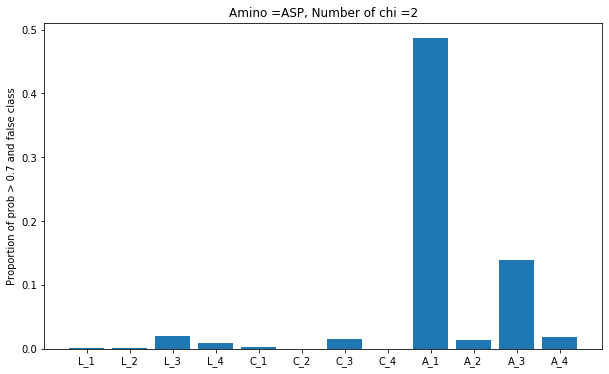

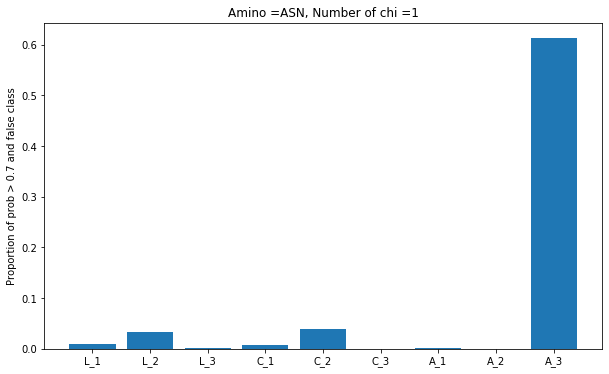

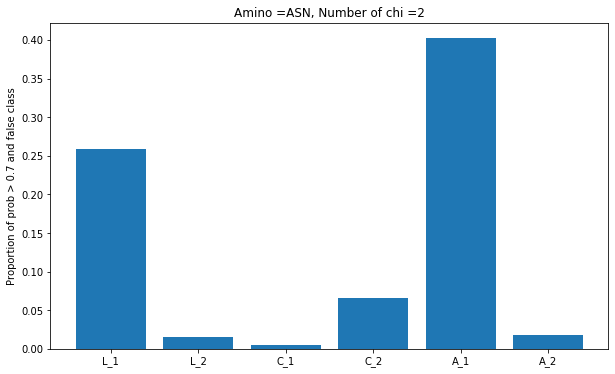

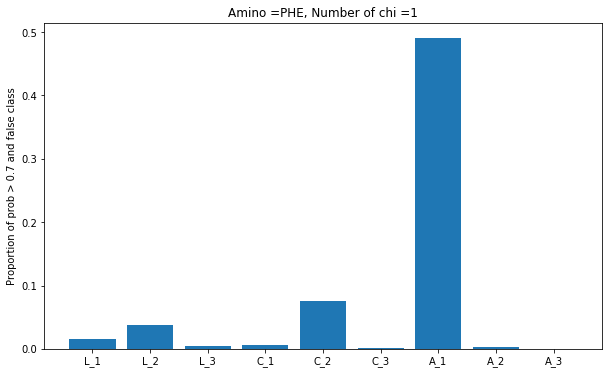

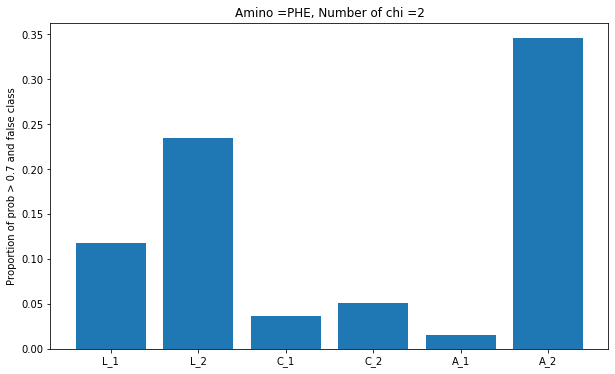

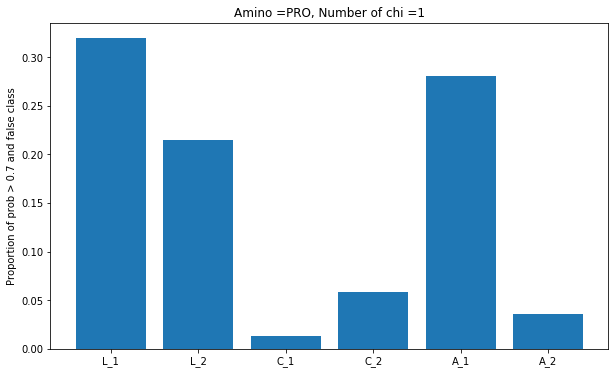

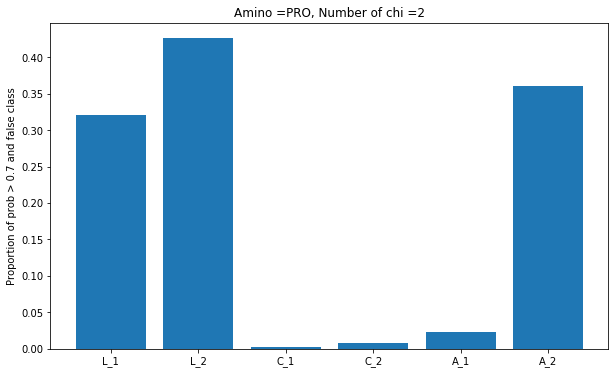

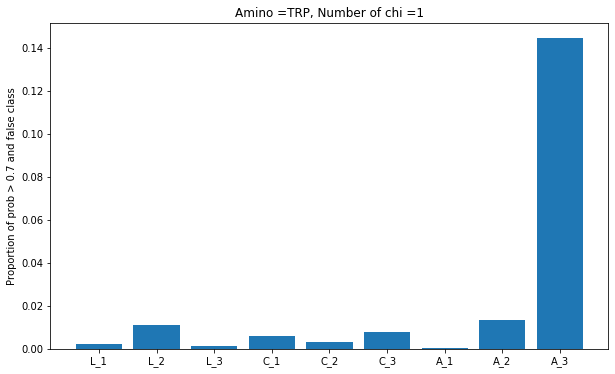

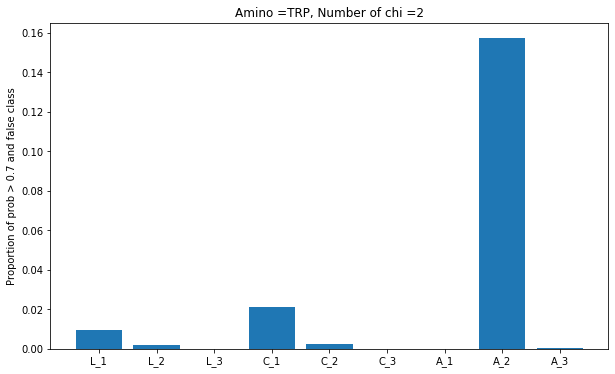

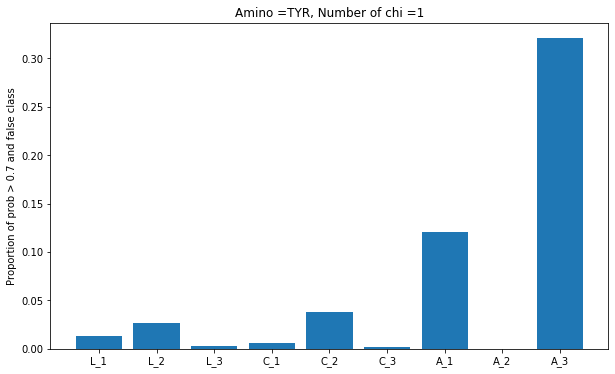

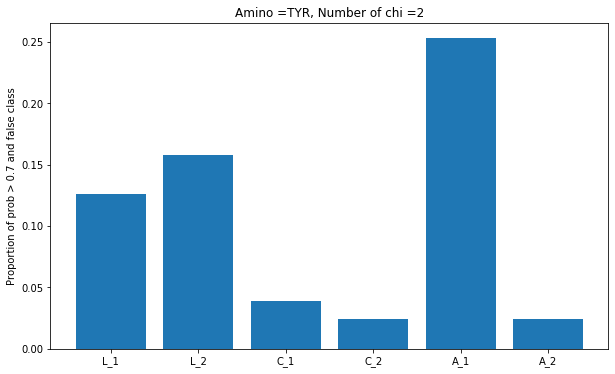

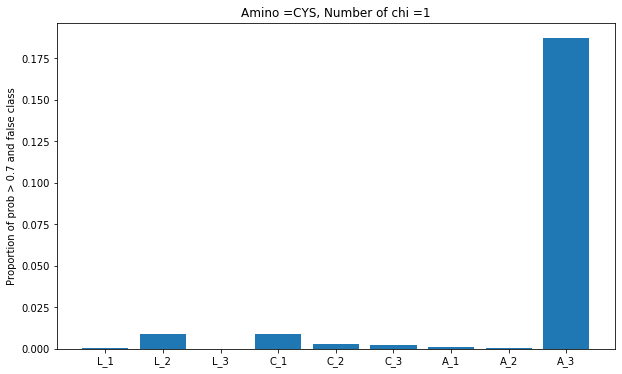

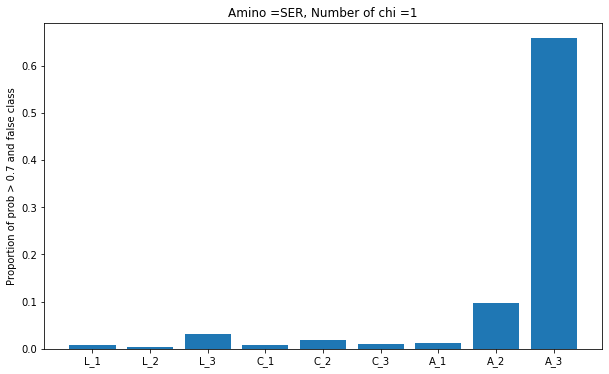

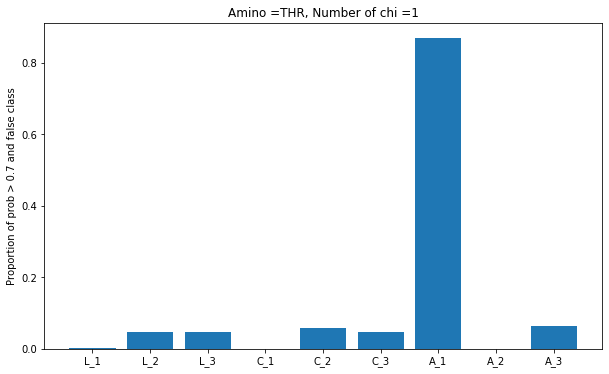

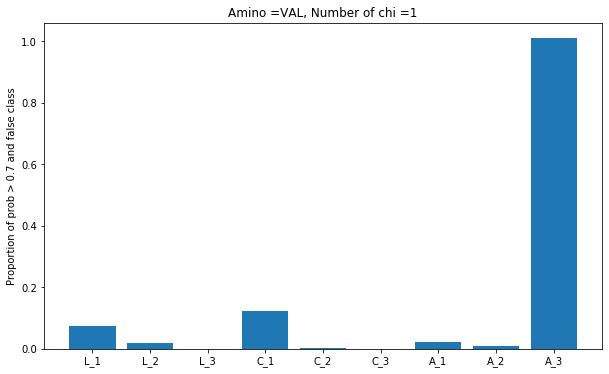

In [284]:
for amino in amino_arr:
    train_data = pd.read_csv(amino + '_train_data.csv')
    train_data = train_data.drop(columns=["Unnamed: 0", "pbd_indx"])
    count = 0
    cols = train_data.columns.tolist()
    for i in range(len(cols)):
        words = cols[i].split('_')
        if ('chi' in words):
            count += 1
    for chi in range(count): # по номерам углов
        proportion = []
        df_prob = pd.read_csv(amino + 'probas_chi_' + str(chi + 1) + '.csv').drop(columns=['Unnamed: 0'])
        df_true = pd.read_csv(amino + '_chi_' + str(chi + 1) + '.csv')['True'].to_numpy()
        for col in df_prob.columns:
            index = (df_prob.loc[df_prob[col] > 0.7].index).to_numpy()
            df_index = df_true[index]
            num_class = int(col.split('_')[1]) - 1
            df_index = df_index[df_index != num_class]
            proportion.append(df_index.shape[0] / size)
        plt.figure(figsize=(10, 6))
#         sns.distplot(proportion)
        bins = []
        if len(proportion) == 6:
            bins = columns_2
        if len(proportion) == 9:
            bins = columns_3
        if len(proportion) == 12:
            bins = columns_4
        plt.bar(bins, proportion)
        plt.ylabel('Proportion of prob > 0.7 and false class')
        plt.title('Amino =' + amino + ', Number of chi =' + str(chi + 1))

### 5. Сравнение точность предсказания для каждого метода в отдельности и для их комбинации. Графики для каждого класса углов.

In [10]:
count = [5, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1]

In [11]:
cnt = 0

In [219]:
cnt = 0
for amino in amino_arr:
    print(amino)
    for i in range(count[cnt]):
        print(i + 1)
        df = pd.read_csv(amino + '_chi_' + str(i + 1) +'_stats.csv')
        print('Same for 3 methods =', df['Same pred'].values[0])
        print('True for 3 methods=', df['True same pred'].values[0])
        df = pd.read_csv(amino + '_chi_' + str(i + 1) +'light_cnn.csv')
        print('Same for 2 methods =', df['Same pred'].values[0])
        print('True for 2 methods=', df['True same pred'].values[0])
    cnt += 1

ARG
1
Same for 3 methods = 0.417009420193711
True for 3 methods= 0.6598790964047089
Same for 2 methods = 0.5963911370571846
True for 2 methods= 0.6440489432703004
2
Same for 3 methods = 0.9306089956216002
True for 3 methods= 0.7299686341602509
Same for 2 methods = 0.9575427889080536
True for 2 methods= 0.7280033254815022
3
Same for 3 methods = 0.4403608862942816
True for 3 methods= 0.5504670081349804
Same for 2 methods = 0.8046968289770465
True for 2 methods= 0.5348722176422094
4
Same for 3 methods = 0.7058511344036089
True for 3 methods= 0.5516917293233082
Same for 2 methods = 0.8581663791959666
True for 2 methods= 0.5431354359925789
5
Same for 3 methods = 0.9956216001061429
True for 3 methods= 0.94136460554371
Same for 2 methods = 1.0
True for 2 methods= 0.9414886559639114
LYS
1
Same for 3 methods = 0.4379634206623826
True for 3 methods= 0.6713318284424379
Same for 2 methods = 0.6471576866040534
True for 2 methods= 0.6555148182095937
2
Same for 3 methods = 0.8910528917449333
True for

In [299]:
cols = ['Amino', 'chi_1', 'chi_2', 'chi_3', 'chi_4', 'chi_5']
chi_1 = np.zeros(len(amino_arr))
chi_2 = np.zeros(len(amino_arr))
chi_3 = np.zeros(len(amino_arr))
chi_4 = np.zeros(len(amino_arr))
chi_5 = np.zeros(len(amino_arr))
res_table = pd.DataFrame(columns=cols)

cnt = 0
for amino in amino_arr:
    for i in range(count[cnt]):
        df = pd.read_csv(amino + '_chi_' + str(i + 1) +'.csv')
        if i == 0:
            chi_1[cnt] = round(accuracy_score(df['True'], df['LightGBM']), 2)
        if i == 1:
            chi_2[cnt] = round(accuracy_score(df['True'], df['LightGBM']), 2)
        if i == 2:
            chi_3[cnt] = round(accuracy_score(df['True'], df['LightGBM']), 2)
        if i == 3:
            chi_4[cnt] = round(accuracy_score(df['True'], df['LightGBM']), 2)
        if i == 4:
            chi_5[cnt] = round(accuracy_score(df['True'], df['LightGBM']), 2)
    cnt += 1

res_table['Amino'] = amino_arr

res_table['chi_1'] = chi_1
res_table['chi_2'] = chi_2
res_table['chi_3'] = chi_3
res_table['chi_4'] = chi_4
res_table['chi_5'] = chi_5

res_table = res_table.replace(0.0, '', regex=True)

res_table.to_csv('LightGBM_accuracy.csv')

In [320]:
cols = ['Amino', 'chi_1', 'chi_2', 'chi_3', 'chi_4', 'chi_5']
chi_1 = np.zeros(len(amino_arr))
chi_2 = np.zeros(len(amino_arr))
chi_3 = np.zeros(len(amino_arr))
chi_4 = np.zeros(len(amino_arr))
chi_5 = np.zeros(len(amino_arr))
res_table = pd.DataFrame(columns=cols)

cnt = 0
for amino in amino_arr:
    for i in range(count[cnt]):
        df = pd.read_csv(amino + '_chi_' + str(i + 1) +'.csv')
        if i == 0:
            chi_1[cnt] = round(accuracy_score(df['True'], df['CNN']), 2)
        if i == 1:
            chi_2[cnt] = round(accuracy_score(df['True'], df['CNN']), 2)
        if i == 2:
            chi_3[cnt] = round(accuracy_score(df['True'], df['CNN']), 2)
        if i == 3:
            chi_4[cnt] = round(accuracy_score(df['True'], df['CNN']), 2)
        if i == 4:
            chi_5[cnt] = round(accuracy_score(df['True'], df['CNN']), 2)
    cnt += 1

res_table['Amino'] = amino_arr

res_table['chi_1'] = chi_1
res_table['chi_2'] = chi_2
res_table['chi_3'] = chi_3
res_table['chi_4'] = chi_4
res_table['chi_5'] = chi_5

res_table = res_table.replace(0.0, '', regex=True)

res_table.to_csv('CNN_accuracy.csv')

In [321]:
cols = ['Amino', 'chi_1', 'chi_2', 'chi_3', 'chi_4', 'chi_5']
chi_1 = np.zeros(len(amino_arr))
chi_2 = np.zeros(len(amino_arr))
chi_3 = np.zeros(len(amino_arr))
chi_4 = np.zeros(len(amino_arr))
chi_5 = np.zeros(len(amino_arr))
res_table = pd.DataFrame(columns=cols)

cnt = 0
for amino in amino_arr:
    for i in range(count[cnt]):
        df = pd.read_csv(amino + '_chi_' + str(i + 1) +'.csv')
        if i == 0:
            chi_1[cnt] = round(accuracy_score(df['True'], df['AutoEncoder']), 2)
        if i == 1:
            chi_2[cnt] = round(accuracy_score(df['True'], df['AutoEncoder']), 2)
        if i == 2:
            chi_3[cnt] = round(accuracy_score(df['True'], df['AutoEncoder']), 2)
        if i == 3:
            chi_4[cnt] = round(accuracy_score(df['True'], df['AutoEncoder']), 2)
        if i == 4:
            chi_5[cnt] = round(accuracy_score(df['True'], df['AutoEncoder']), 2)
    cnt += 1

res_table['Amino'] = amino_arr

res_table['chi_1'] = chi_1
res_table['chi_2'] = chi_2
res_table['chi_3'] = chi_3
res_table['chi_4'] = chi_4
res_table['chi_5'] = chi_5

res_table = res_table.replace(0.0, '', regex=True)

res_table.to_csv('AutoEncoder_accuracy.csv')

In [22]:
light_arr = np.zeros((5, len(amino_arr)))
cnn_arr = np.zeros((5, len(amino_arr)))
coder_arr = np.zeros((5, len(amino_arr)))
three_methods = np.zeros((5, len(amino_arr)))
cnt = 0
for i in range(len(amino_arr)):
    for j in range(count[cnt]):
        df = pd.read_csv(amino_arr[i] + '_chi_' + str(j + 1) + '.csv')
        light_arr[j][i] = accuracy_score(df['True'], df['LightGBM'])
        cnn_arr[j][i] = accuracy_score(df['True'], df['CNN'])
        coder_arr[j][i] = accuracy_score(df['True'], df['AutoEncoder'])
        df_2 = df[df['LightGBM'] == df['CNN']][df['LightGBM'] == df['AutoEncoder']]
        three_methods[j][i] = accuracy_score(df_2['True'], df_2['LightGBM'])
    cnt += 1

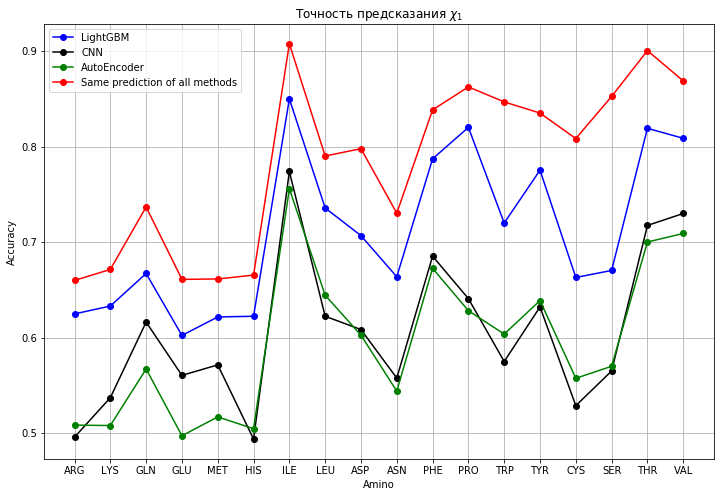

In [45]:
plt.figure(figsize=(12, 8))
plt.plot(amino_arr, light_arr[0], marker = 'o', color='blue', label='LightGBM')
plt.plot(amino_arr, cnn_arr[0], marker = 'o', color='black', label='CNN')
plt.plot(amino_arr, coder_arr[0], marker = 'o', color='green', label='AutoEncoder')
plt.plot(amino_arr, three_methods[0], marker = 'o', color='red', label='Same prediction of all methods')
plt.title('Точность предсказания $\chi_1$')
plt.xlabel("Amino")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.savefig('accuracy_plot_1.png')
plt.show()

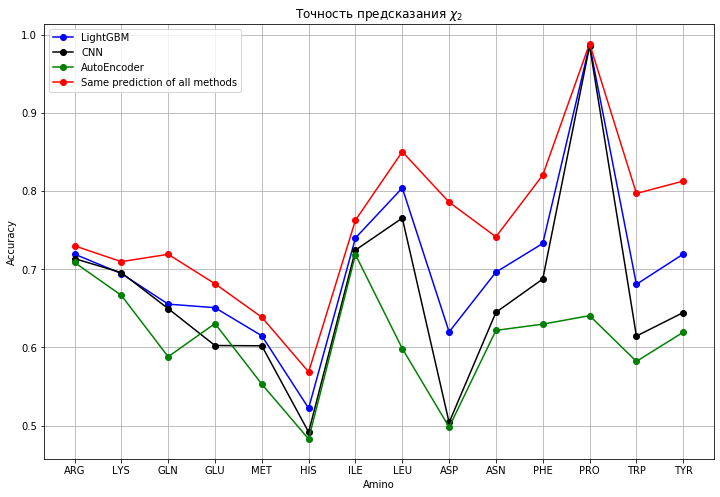

In [51]:
plt.figure(figsize=(12, 8))
plt.plot(amino_arr[:14], light_arr[1][:14], marker = 'o', color='blue', label='LightGBM')
plt.plot(amino_arr[:14], cnn_arr[1][:14], marker = 'o', color='black', label='CNN')
plt.plot(amino_arr[:14], coder_arr[1][:14], marker = 'o', color='green', label='AutoEncoder')
plt.plot(amino_arr[:14], three_methods[1][:14], marker = 'o', color='red', label='Same prediction of all methods')
plt.title('Точность предсказания $\chi_2$')
plt.xlabel("Amino")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.savefig('accuracy_plot_2.png')
plt.show()

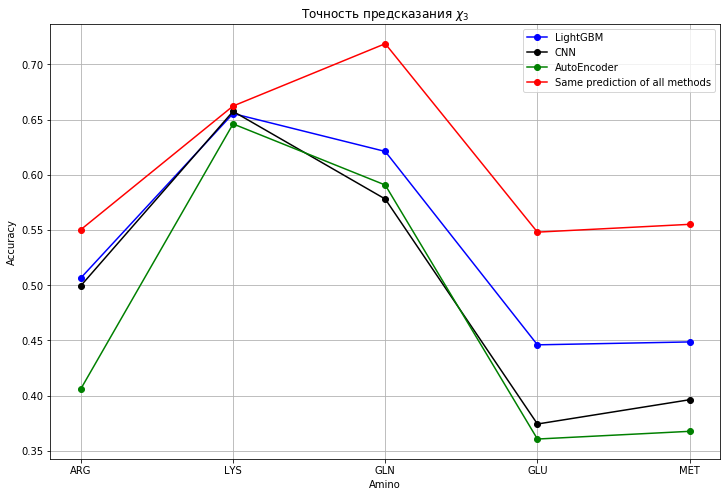

In [53]:
plt.figure(figsize=(12, 8))
plt.plot(amino_arr[:5], light_arr[2][:5], marker = 'o', color='blue', label='LightGBM')
plt.plot(amino_arr[:5], cnn_arr[2][:5], marker = 'o', color='black', label='CNN')
plt.plot(amino_arr[:5], coder_arr[2][:5], marker = 'o', color='green', label='AutoEncoder')
plt.plot(amino_arr[:5], three_methods[2][:5], marker = 'o', color='red', label='Same prediction of all methods')
plt.title('Точность предсказания $\chi_3$')
plt.xlabel("Amino")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.savefig('accuracy_plot_3.png')
plt.show()

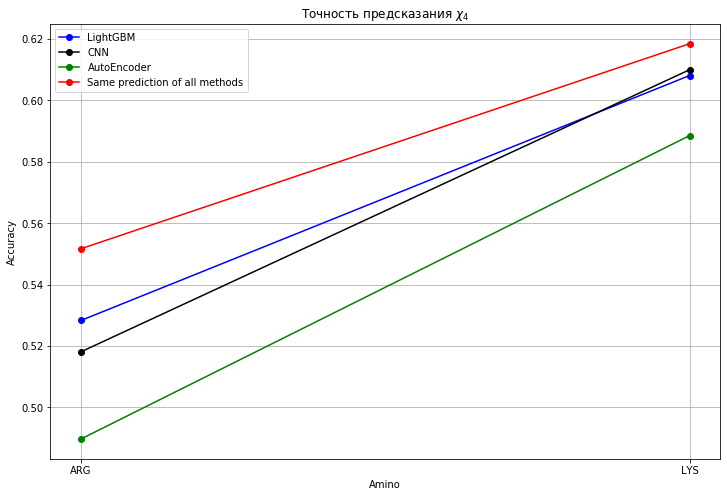

In [57]:
plt.figure(figsize=(12, 8))
plt.plot(amino_arr[:2], light_arr[3][:2], marker = 'o', color='blue', label='LightGBM')
plt.plot(amino_arr[:2], cnn_arr[3][:2], marker = 'o', color='black', label='CNN')
plt.plot(amino_arr[:2], coder_arr[3][:2], marker = 'o', color='green', label='AutoEncoder')
plt.plot(amino_arr[:2], three_methods[3][:2], marker = 'o', color='red', label='Same prediction of all methods')
plt.title('Точность предсказания $\chi_4$')
plt.xlabel("Amino")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.savefig('accuracy_plot_4.png')
plt.show()